<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURJPY/EURJPY_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURJPY=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open     High      Low    Close  Adj Close  Volume
Date                                                             
2009-01-01  126.870  128.180  125.570  126.920    126.920       0
2009-01-02  126.977  128.000  126.033  127.860    127.860       0
2009-01-05  128.460  128.460  126.418  127.110    127.110       0
2009-01-06  127.100  127.120  125.191  126.059    126.059       0
2009-01-07  126.030  127.560  125.899  126.180    126.180       0
...             ...      ...      ...      ...        ...     ...
2018-12-26  126.022  126.214  125.800  126.002    126.002       0
2018-12-27  126.409  126.664  126.024  126.405    126.405       0
2018-12-28  126.774  126.974  126.288  126.768    126.768       0
2018-12-31  126.220  126.422  125.414  126.249    126.249       0
2019-01-01  125.690  126.550  125.660  125.980    125.980       0

[2606 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.000000  2606.0
mean    124.223467   124.773843   123.610884   124.217614   124.217614     0.0
std      12.053407    12.027080    12.088422    12.053273    12.053273     0.0
min      94.224000    95.000000    94.134000    94.210000    94.210000     0.0
25%     114.346250   114.885250   113.741500   114.355000   114.355000     0.0
50%     127.847500   128.419500   127.158000   127.860000   127.860000     0.0
75%     133.216000   133.732250   132.598500   133.212000   133.212000     0.0
max     149.480000   149.518000   148.290000   149.441000   149.441000     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08       SMA_8      TEMA_8    TRIMA_8       WMA_8      MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2009-03-12  124.520  126.380  122.170  125.480    125.480   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  124.175520  120.076711 -126.380000  125.523378  124.455546  121.932978    124.3630    124.1690  126.380000  124.534500  125.346648  124.51755  124.804361  124.534500  125.200667  122.143152              126.232675               124.534500              122.836325              127.081762               124.534500              121.987238              127.930850               124.534500              121.138150              128.779937               124.534500              120.289063  124.455546  125.115628  122.533880              126.153721               124.455546              122.757371              127.002808               124.455546              121.908283              127.851896               124.455546              121.059196              128.700983   
2009-03-13  125.480  127.550  125.467  126.620    126.620   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  125.397760  121.406973  122.170000  126.141175  124.936536  122.271567    124.8670    124.8600  122.170000  124.928625  126.110124  124.83795  125.267806  124.928625  126.050000  122.496206              126.895180               124.928625              122.962070              127.878457               124.928625              121.978793              128.861734               124.928625              120.995516              129.845011               124.928625              120.012239  124.936536  126.160021  122.882180              126.903090               124.936536              122.969981              127.886368               124.936536              121.986704              128.869645               124.936536              121.003426              129.852922   
2009-03-16  126.397  128.650  126.330  127.411    127.411   16         

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000    2556.000000   2556.000000     2556.000000     2556.000000       2556.000000  2556.000000  2556.000000  2556.000000  2556.000000   2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000   
mean    124.302603   124.839874   123.704829   124.296273   124.296273    15.758607     1.999218   185.926448      30.467919      0.033255        0.966745        0.010955          0.989045     6.615806     2.537167    27.008998     1.999218      2.000000    27.008998   124.299268   124.283497    -2.500926   124.298499   124.293019   124.382991   124.263486   124.211699   124.140665   124.294046   124.296006   124.294117   124.294883   124.294046   124.294472   124.279568              126.054461               124.294046              122.533631              126.934669               124.294046              121.653423              127.814877               124.294046              120.773216              128.695084               124.294046              119.893008   124.293019   124.294793   124.282604              126.053435               124.293019              122.532604              126.933642               124.293019              121.652397              127.813850   
std      12.144052    12.122791    12.173783    12.144998    12.144998     8.806999     1.414767   104.411507       0.781481      0.179337        0.179337        0.104110          0.104110     3.414756     1.108139    14.931190     1.414767      1.414214    14.931190    12.119989    12.013536   124.836683    12.160903    12.083363    12.101785    12.096438    12.091921    12.157869    12.103193    12.153476    12.111992    12.109650    12.103193    12.133016    12.029661               12.094894                12.103193               12.188597               12.119767                12.103193               12.259767               12.163859                12.103193               12.349508               12.226964                12.103193               12.457417    12.083363    12.127306    12.040509               12.076634                12.083363               12.167335               12.102334                12.083363               12.237847               12.147277   
min      94.224000    95.000000    94.134000    94.210000    94.210000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.548284  0.575590  0.517690  0.566168   0.566168   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.547559  0.471022  0.078111  0.570075  0.549670  0.505484    0.545754    0.542373  0.582226  0.552382  0.568730  0.552046  0.556619  0.552382  0.562713  0.506920                0.556161                 0.552382                0.548222                0.553694                 0.552382                0.546763                0.548926                 0.552382                0.543421                0.545664                 0.552382                0.540169  0.549670  0.564459  0.514217                0.552594                 0.549670                0.549106                0.548741                 0.549670                0.547728                0.544677                 0.549670                0.544379                0.541053                 0.549670   
2009-03-13  0.565658  0.597051  0.578569  0.586808   0.586808   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.570777  0.497332  0.917189  0.581453  0.558839  0.512129    0.555247    0.555539  0.506211  0.559867  0.582769  0.558092  0.565367  0.559867  0.578319  0.513848                0.568738                 0.559867                0.550585                0.568698                 0.559867                0.546605                0.566075                 0.559867                0.540804                0.564810                 0.559867                0.535158  0.558839  0.583736  0.521017                0.566907                 0.558839                0.553094                0.565397                 0.558839                0.549184                0.563418                 0.558839                0.543358                0.561773                 0.558839   
2009-03-16  0.582254  0.617227  0.594505  0.601130   0.601130   16          0         75

138236

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 46 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_l60h34
H2O cluster total nodes:    1
H2O cluster free memory:    7.889 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.859829  0.478802              0.236935  0.393933  0.155183
1  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.855922  0.844176              0.221673  0.430235  0.185102
2  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.854945  0.554932              0.213980  0.398985  0.159189
3  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.853785  0.511640              0.225641  0.418058  0.174773
4  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.852686  0.498747              0.215201  0.408756  0.167081
5  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.850977  0.508012              0.241148  0.411483  0.169318
6  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.840842  0.523313              0.244750  0.424178  0.179927
7              DeepLearning_1_AutoML_20190822_151126  0.818254  0.588673              0.248840  0.418682  0.175294
8  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.809463  0.589233              0.271673  0.455292  0.207291
9  DeepLearning_grid_1_AutoML_20190822_151126_mod...  0.500000  0.693984              0.500000  0.500418  0.250418

variable  relative_importance  scaled_importance  percentage
0            CDLGRAVESTONEDOJI             1.000000           1.000000    0.004404
1             CDLDRAGONFLYDOJI             0.801091           0.801091    0.003528
2                    CDLTAKURI             0.790863           0.790863    0.003483
3            CDLINVERTEDHAMMER             0.729605           0.729605    0.003213
4                CDLHANGINGMAN             0.707995           0.707995    0.003118
...                        ...                  ...                ...         ...
1021       CDLXSIDEGAP3METHODS             0.173900           0.173900    0.000766
1022  BBANDS_middleband_30_0_3             0.173836           0.173836    0.000766
1023  BBANDS_middleband_12_2_5             0.173406           0.173406    0.000764
1024   BBANDS_lowerband_14_3_2             0.172205           0.172205    0.000758
1025               CDLMARUBOZU             0.160836           0.160836    0.000708

[1026 rows x 4 columns]

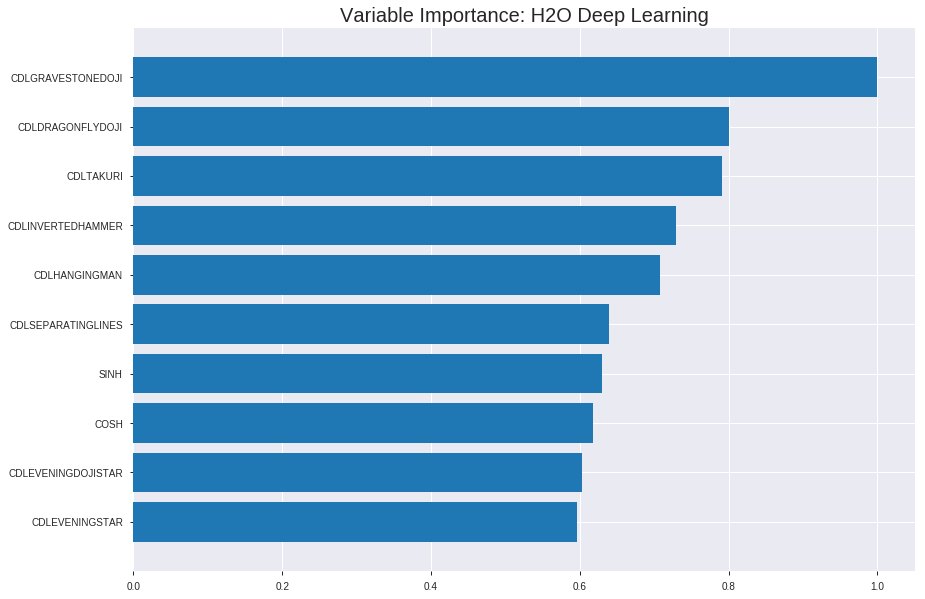

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_151126_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16855175387309382
RMSE: 0.41055054971719845
LogLoss: 0.5028032264608546
Mean Per-Class Error: 0.2518972767320784
AUC: 0.8328794553464157
pr_auc: 0.8353189134410125
Gini: 0.6657589106928314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47871395021817004: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      554  326   0.3705   (326.0/880.0)
1      136  772   0.1498   (136.0/908.0)
Total  690  1098  0.2584   (462.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478714     0.769691  228
max f2                       0.192096     0.865517  329
max f0point5                 0.669452     0.768229  139
max accuracy                 0.54784      0.748322  194
max precision                0.962274     0.982759  22
max recall                   0.00559968   1         395
max specificity              0.999309     0.998864  0
max absolute_mcc             0.54784      0.496463  194
max min_per_class_accuracy   0.558464     0.744318  189
max mean_per_class_accuracy  0.54784      0.748103  194

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 53.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.996364           1.85977    1.85977            0.944444         0.998131   0.944444                    0.998131            0.0187225       0.0187225                  85.9765   85.9765
    2        0.0201342                   0.993486           1.96916    1.91446            1                0.994909   0.972222                    0.99652             0.0198238       0.0385463                  96.9163   91.4464
    3        0.0302013                   0.991765           1.85977    1.89623            0.944444         0.992485   0.962963                    0.995175            0.0187225       0.0572687                  85.9765   89.6231
    4        0.0402685                   0.989279           1.96916    1.91446            1                0.990536   0.972222                    0.994015            0.0198238       0.0770925                  96.9163   91.4464
    5        0.0503356                   0.986378           1.96916    1.9254             1                0.987942   0.977778                    0.992801            0.0198238       0.0969163                  96.9163   92.5404
    6        0.100112                    0.958789           1.92491    1.92516            0.977528         0.973534   0.977654                    0.983221            0.095815        0.192731                   92.4912   92.5159
    7        0.150447                    0.887938           1.83789    1.89596            0.933333         0.929317   0.962825                    0.965186            0.092511        0.285242                   83.7885   89.596
    8        0.200224                    0.812177           1.52665    1.80415            0.775281         0.846221   0.916201                    0.935611            0.0759912       0.361233                   52.6654   80.4149
    9        0.300336                    0.71564            1.44112    1.68314            0.731844         0.759479   0.854749                    0.8769              0.144273        0.505507                   44.1119   68.3139
    10       0.399888                    0.638045           1.31646    1.59185            0.668539         0.67517    0.808392                    0.826679            0.131057        0.636564                   31.6463   59.1855
    11       0.5                         0.562945           1.04509    1.48238            0.530726         0.601767   0.752796                    0.781646            0.104626        0.741189                   4.50865   48.2379
    12       0.600112                    0.488635           0.96808    1.39658            0.49162          0.522591   0.709226                    0.73843             0.0969163       0.838106                   -3.19199  39.6583
    13       0.699664                    0.385401           0.6527     1.29074            0.331461         0.44368    0.655476                    0.696491            0.064978        0.903084                   -34.73    29.0738
    14       0.799776                    0.242769           0.528044   1.19527            0.268156         0.325486   0.606993                    0.650051            0.0528634       0.955947                   -47.1956  19.5268
    15       0.899888                    0.0425278          0.374031   1.10391            0.189944         0.129097   0.560597                    0.592095            0.0374449       0.993392                   -62.5969  10.3906
    16       1                           0.000115492        0.0660055  1                  0.0335196        0.0156883  0.50783   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17584354553516218
RMSE: 0.4193370309609708
LogLoss: 0.5665723160239181
Mean Per-Class Error: 0.25627701646279777
AUC: 0.8174913394034152
pr_auc: 0.8219221429737619
Gini: 0.6349826788068305
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.451602376749645: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      164  85   0.3414   (85.0/249.0)
1      46   216  0.1756   (46.0/262.0)
Total  210  301  0.2564   (131.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451602     0.767318  243
max f2                       0.0448277    0.855131  362
max f0point5                 0.651389     0.772921  137
max accuracy                 0.522518     0.74364   209
max precision                0.999518     1         0
max recall                   0.000273158  1         399
max specificity              0.999518     1         0
max absolute_mcc             0.451602     0.49075   243
max min_per_class_accuracy   0.519992     0.742972  211
max mean_per_class_accuracy  0.522518     0.743723  209

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.997415           1.95038   1.95038            1                0.998662   1                           0.998662            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.994056           1.56031   1.77307            0.8              0.995208   0.909091                    0.997092            0.0152672       0.0381679                  56.0305   77.3074
    3        0.0313112                   0.992636           1.95038   1.82848            1                0.993383   0.9375                      0.995933            0.019084        0.0572519                  95.0382   82.8483
    4        0.0410959                   0.990939           1.95038   1.85751            1                0.991655   0.952381                    0.994914            0.019084        0.0763359                  95.0382   85.7506
    5        0.0508806                   0.988801           1.95038   1.87537            1                0.989821   0.961538                    0.993935            0.019084        0.0954198                  95.0382   87.5367
    6        0.101761                    0.966194           1.80035   1.83786            0.923077         0.979472   0.942308                    0.986703            0.0916031       0.187023                   80.0352   83.786
    7        0.150685                    0.918639           1.79435   1.82373            0.92             0.946844   0.935065                    0.973762            0.0877863       0.274809                   79.4351   82.3734
    8        0.201566                    0.830617           1.72534   1.7989             0.884615         0.875999   0.92233                     0.949084            0.0877863       0.362595                   72.5338   79.8896
    9        0.30137                     0.682527           1.37674   1.65909            0.705882         0.748926   0.850649                    0.882798            0.137405        0.5                        37.674    65.9091
    10       0.401174                    0.583507           1.14728   1.53176            0.588235         0.626339   0.785366                    0.818996            0.114504        0.614504                   14.7283   53.1763
    11       0.500978                    0.523423           1.22377   1.4704             0.627451         0.553775   0.753906                    0.766159            0.122137        0.736641                   22.3769   47.0405
    12       0.600783                    0.442494           0.917827  1.37861            0.470588         0.487742   0.70684                     0.719907            0.0916031       0.828244                   -8.21733  37.8609
    13       0.700587                    0.361691           0.650127  1.27483            0.333333         0.400036   0.653631                    0.674339            0.0648855       0.89313                    -34.9873  27.483
    14       0.800391                    0.146662           0.497156  1.17786            0.254902         0.265629   0.603912                    0.623375            0.0496183       0.942748                   -50.2844  17.7859
    15       0.900196                    0.0271833          0.382428  1.08967            0.196078         0.0718611  0.558696                    0.562229            0.0381679       0.980916                   -61.7572  8.96698
    16       1                           0.000173187        0.191214  1                  0.0980392        0.0085814  0.51272                     0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:14:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:14:25  2 min 56.485 sec  477 obs/sec       0.530761  1             949        0.64057          4.14408             -0.64172       0.611751        0.566854           1.96916          0.49217                          0.591884           2.61763               -0.402216        0.655155          0.638129             1.30025            0.430528
    2019-08-22 15:14:36  3 min  7.896 sec  524 obs/sec       3.6387    7             6506       0.506119         1.28167             -0.0248788     0.777289        0.552396           1.85977          0.311521                         0.505217           1.5888                -0.0216367       0.779009          0.641797             1.95038            0.309198
    2019-08-22 15:14:48  3 min 19.126 sec  532 obs/sec       6.74776   13            12065      0.471599         1.04903             0.110157       0.804992        0.594459           1.85977          0.28915                          0.485815           1.37394               0.0553225        0.80834           0.69113              1.95038            0.272016
    2019-08-22 15:14:59  3 min 30.281 sec  538 obs/sec       9.87248   19            17652      0.514614         1.56527             -0.0595713     0.744438        0.465515           1.85977          0.331096                         0.509571           1.38786               -0.039322        0.765313          0.618915             1.95038            0.324853
    2019-08-22 15:15:10  3 min 41.504 sec  541 obs/sec       13.038    25            23312      0.518142         1.10035             -0.0741484     0.79109         0.687711           1.85977          0.303691                         0.495346           1.02078               0.0178956        0.774641          0.700736             1.62532            0.32681
    2019-08-22 15:15:21  3 min 52.663 sec  545 obs/sec       16.217    31            28996      0.462825         0.817049            0.142963       0.778423        0.640287           1.85977          0.295302                         0.454357           0.761269              0.173705         0.7899            0.727675             1.95038            0.295499
    2019-08-22 15:15:32  4 min  3.750 sec  548 obs/sec       19.4116   37            34708      0.502569         0.780963            -0.0105498     0.734607        0.732989           1.96916          0.394855                         0.459848           0.65855               0.153613         0.785761          0.790623             1.95038            0.334638
    2019-08-22 15:15:43  4 min 14.607 sec  551 obs/sec       22.5587   43            40335      0.410551         0.502803            0.325628       0.832879        0.835319           1.85977          0.258389                         0.419337           0.566572              0.29617          0.817491          0.821922             1.95038            0.25636
    2019-08-22 15:15:54  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI         1.0                    1.0                  0.0044041407131462556
CDLDRAGONFLYDOJI          0.8010908365249634     0.8010908365249634   0.003528116768067983
CDLTAKURI                 0.7908634543418884     0.7908634543418884   0.003483073937806596
CDLINVERTEDHAMMER         0.7296053171157837     0.7296053171157837   0.0032132844816376077
CDLHANGINGMAN             0.7079947590827942     0.7079947590827942   0.003118108543170709
---                       ---                    ---                  ---
CDLXSIDEGAP3METHODS       0.173899844288826      0.173899844288826    0.0007658793842422129
BBANDS_middleband_30_0_3  0.17383649945259094    0.17383649945259094  0.0007656004046699826
BBANDS_middleband_12_2_5  0.17340633273124695    0.17340633273124695  0.0007637058898990709
BBANDS_lowerband_14_3_2   0.17220467329025269    0.17220467329025269  0.0007584136126316515
CDLMARUBOZU               0.16083583235740662    0.16083583235740662  0.0007083436374180204


See the whole table with table.as_data_frame()


('accuracy', 0.77734375)

('F1', 0.7781818181818182)

('auc', 0.8598290598290598)

('logloss', 0.47880238074763093)

('mean_per_class_error', 0.22338217338217348)

('rmse', 0.3939329654583235)

('mse', 0.15518318127478872)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


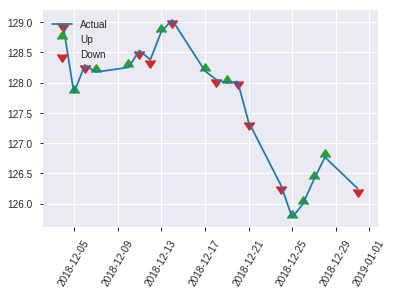


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.15518318127478872
RMSE: 0.3939329654583235
LogLoss: 0.47880238074763093
Mean Per-Class Error: 0.22338217338217348
AUC: 0.8598290598290598
pr_auc: 0.870922257333164
Gini: 0.7196581196581195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46406411857611474: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   42   0.3231   (42.0/130.0)
1      19   107  0.1508   (19.0/126.0)
Total  107  149  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464064     0.778182  148
max f2                       0.374531     0.862573  179
max f0point5                 0.677463     0.821596  74
max accuracy                 0.599139     0.777344  96
max precision                0.995296     1         0
max recall                   0.00119532   1         251
max specificity              0.995296     1         0
max absolute_mcc             0.677463     0.568011  74
max min_per_class_accuracy   0.52561      0.753968  125
max mean_per_class_accuracy  0.560073     0.776618  114

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.985405           2.03175   2.03175            1                0.990247   1                           0.990247            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.982942           2.03175   2.03175            1                0.983689   1                           0.986968            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.981149           2.03175   2.03175            1                0.981466   1                           0.985593            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.977406           2.03175   2.03175            1                0.979123   1                           0.983828            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.976785           2.03175   2.03175            1                0.977018   1                           0.98278             0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.962286           2.03175   2.03175            1                0.971686   1                           0.977233            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.925547           2.03175   2.03175            1                0.942982   1                           0.965816            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.791056           1.87546   1.99267            0.923077         0.870146   0.980769                    0.941898            0.0952381       0.404762                   87.5458   99.2674
    9        0.300781                    0.675014           1.54413   1.84704            0.76             0.719567   0.909091                    0.869713            0.150794        0.555556                   54.4127   84.7042
    10       0.402344                    0.594002           1.09402   1.65696            0.538462         0.622954   0.815534                    0.807424            0.111111        0.666667                   9.40171   65.6958
    11       0.5                         0.518131           0.975238  1.52381            0.48             0.557442   0.75                        0.7586              0.0952381       0.761905                   -2.47619  52.381
    12       0.601562                    0.451017           0.859585  1.41167            0.423077         0.486092   0.694805                    0.712592            0.0873016       0.849206                   -14.0415  41.1668
    13       0.699219                    0.37547            0.812698  1.32801            0.4              0.417431   0.653631                    0.671368            0.0793651       0.928571                   -18.7302  32.8013
    14       0.800781                    0.224249           0.39072   1.20914            0.192308         0.309135   0.595122                    0.625427            0.0396825       0.968254                   -60.928   20.9137
    15       0.898438                    0.0508996          0.16254   1.09538            0.08             0.132412   0.53913                     0.571838            0.015873        0.984127                   -83.746   9.53761
    16       1                           7.99645e-05        0.156288  1                  0.0769231        0.0204134  0.492188                    

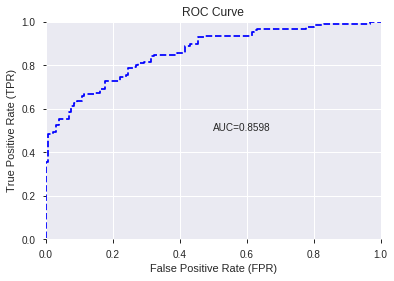

This function is available for GLM models only


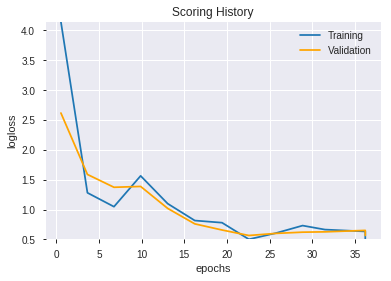

--2019-08-22 15:41:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_151126_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_151126_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_154125_model_9  0.838339  0.504811              0.278022  0.410351  0.168388
1  DeepLearning_grid_1_AutoML_20190822_154125_model_8  0.835714  0.510364              0.285714  0.417674  0.174451
2  DeepLearning_grid_1_AutoML_20190822_154125_model_5  0.834432  0.517307              0.248718  0.419960  0.176366
3  DeepLearning_grid_1_AutoML_20190822_154125_model_6  0.820452  0.499378              0.305311  0.410876  0.168819
4  DeepLearning_grid_1_AutoML_20190822_154125_model_7  0.815995  0.646700              0.241880  0.484765  0.234997
5  DeepLearning_grid_1_AutoML_20190822_154125_model_3  0.810806  0.555337              0.302076  0.431871  0.186512
6  DeepLearning_grid_1_AutoML_20190822_154125_model_2  0.787241  0.598450              0.316972  0.450151  0.202636
7  DeepLearning_grid_1_AutoML_20190822_154125_model_1  0.780647  0.670663              0.343284  0.441316  0.194760
8               DeepLearning_1_AutoML_20190822_154125  0.777473  0.570446              0.316484  0.444970  0.197998
9  DeepLearning_grid_1_AutoML_20190822_154125_model_4  0.763736  0.614096              0.358913  0.453695  0.205839

variable  relative_importance  scaled_importance  percentage
0    CDLGRAVESTONEDOJI             1.000000           1.000000    0.038901
1                CCI_8             0.958287           0.958287    0.037278
2            CDLTAKURI             0.826526           0.826526    0.032152
3     CDLDRAGONFLYDOJI             0.814649           0.814649    0.031690
4   CDLCLOSINGMARUBOZU             0.750228           0.750228    0.029184
5             WILLR_12             0.697816           0.697816    0.027146
6         STOCHF_fastk             0.668357           0.668357    0.026000
7    CDLINVERTEDHAMMER             0.611580           0.611580    0.023791
8        CDLHANGINGMAN             0.603721           0.603721    0.023485
9               ULTOSC             0.591024           0.591024    0.022991
10           PLUS_DI_8             0.565697           0.565697    0.022006
11        HT_TRENDMODE             0.544819           0.544819    0.021194
12                SINH             0.521937           0.521937    0.020304
13           CDLONNECK             0.515562           0.515562    0.020056
14     CDLSHOOTINGSTAR             0.513139           0.513139    0.019961
15              CCI_14             0.511637           0.511637    0.019903
16  CDLSEPARATINGLINES             0.502489           0.502489    0.019547
17                COSH             0.502091           0.502091    0.019532
18        CDLTHRUSTING             0.494468           0.494468    0.019235
19     CDLLADDERBOTTOM             0.493935           0.493935    0.019214
20     CDLADVANCEBLOCK             0.493693           0.493693    0.019205
21     CDLHOMINGPIGEON             0.489200           0.489200    0.019030
22   CDLSTALLEDPATTERN             0.483497           0.483497    0.018808
23             WILLR_8             0.482938           0.482938    0.018787
24      CDLMORNINGSTAR             0.472792           0.472792    0.018392
25                 EXP             0.472449           0.472449    0.018379
26      CDLEVENINGSTAR             0.463483           0.463483    0.018030
27      CDL3LINESTRIKE             0.463150           0.463150    0.018017
28     CDLUNIQUE3RIVER             0.461496           0.461496    0.017953
29          PLUS_DI_12             0.453402           0.453402    0.017638
30  CDLEVENINGDOJISTAR             0.452956           0.452956    0.017620
31  CDLMORNINGDOJISTAR             0.450949           0.450949    0.017542
32        CDLTASUKIGAP             0.450184           0.450184    0.017512
33   CDLDARKCLOUDCOVER             0.440672           0.440672    0.017142
34        is_month_end             0.434058           0.434058    0.016885
35      is_quarter_end             0.431946           0.431946    0.016803
36           CDLHAMMER             0.425180           0.425180    0.016540
37          aroonup_30             0.423223           0.423223    0.016464
38      CDLMATCHINGLOW             0.421555           0.421555    0.016399
39                 SIN             0.415637           0.415637    0.016169
40          weekofyear             0.413752           0.413752    0.016095
41         MINUS_DI_12             0.407321           0.407321    0.015845
42    is_quarter_start             0.405703           0.405703    0.015782
43      is_month_start             0.404315           0.404315    0.015728
44      CDLHARAMICROSS             0.398604           0.398604    0.015506
45               month             0.389456           0.389456    0.015150
46         CDL3OUTSIDE             0.385772           0.385772    0.015007
47           dayofyear             0.380364           0.380364    0.014796
48                week             0.376839           0.376839    0.014659
49             quarter             0.373940           0.373940    0.014547

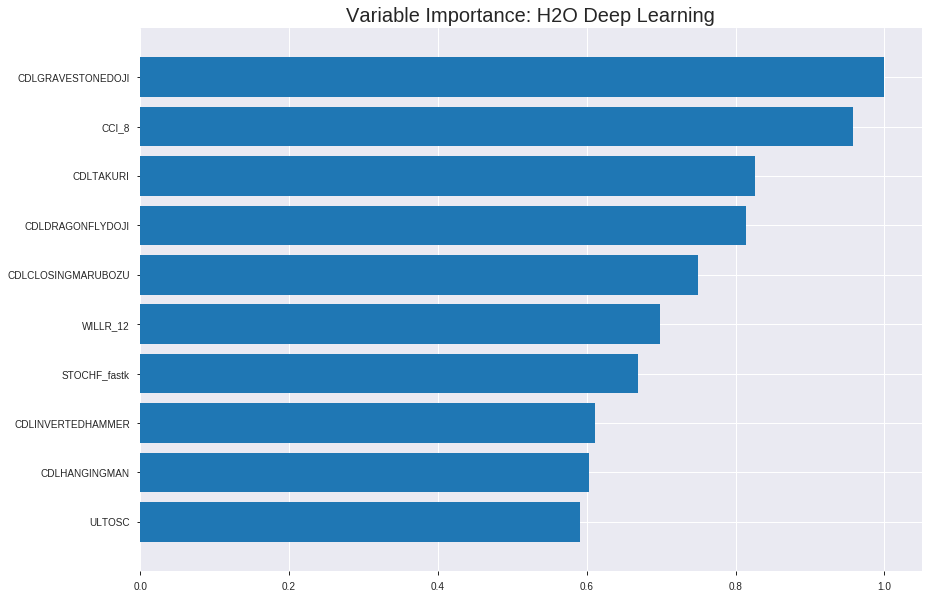

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_154125_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18373675246395807
RMSE: 0.42864525246870294
LogLoss: 0.5406141801948939
Mean Per-Class Error: 0.28244643572286743
AUC: 0.8012302262715258
pr_auc: 0.8126798169797692
Gini: 0.6024604525430517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.450611912299838: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      439  441   0.5011   (441.0/880.0)
1      99   809   0.109    (99.0/908.0)
Total  538  1250  0.302    (540.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450612     0.749768  259
max f2                       0.217307     0.856477  342
max f0point5                 0.57602      0.727326  162
max accuracy                 0.50005      0.718121  227
max precision                0.967634     1         0
max recall                   0.114359     1         391
max specificity              0.967634     1         0
max absolute_mcc             0.50005      0.440606  227
max min_per_class_accuracy   0.521977     0.717045  206
max mean_per_class_accuracy  0.521977     0.717554  206

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 52.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100671                   0.956705           1.96916   1.96916            1                0.959433  1                           0.959433            0.0198238       0.0198238                  96.9163    96.9163
    2        0.0201342                   0.952921           1.96916   1.96916            1                0.954615  1                           0.957024            0.0198238       0.0396476                  96.9163    96.9163
    3        0.0302013                   0.948651           1.96916   1.96916            1                0.95186   1                           0.955303            0.0198238       0.0594714                  96.9163    96.9163
    4        0.0402685                   0.94481            1.96916   1.96916            1                0.946669  1                           0.953144            0.0198238       0.0792952                  96.9163    96.9163
    5        0.0503356                   0.941453           1.85977   1.94728            0.944444         0.943346  0.988889                    0.951185            0.0187225       0.0980176                  85.9765    94.7283
    6        0.100112                    0.904277           1.83641   1.89216            0.932584         0.925567  0.960894                    0.938447            0.0914097       0.189427                   83.641     89.2157
    7        0.150447                    0.753664           1.75037   1.84472            0.888889         0.845178  0.936803                    0.907242            0.0881057       0.277533                   75.0367    84.4718
    8        0.200224                    0.667373           1.4824    1.75465            0.752809         0.69751   0.891061                    0.855102            0.0737885       0.351322                   48.2404    75.4645
    9        0.300336                    0.597157           1.33111   1.61347            0.675978         0.630514  0.819367                    0.780239            0.13326         0.484581                   33.111     61.3467
    10       0.399888                    0.554174           1.10627   1.4872             0.561798         0.574758  0.755245                    0.729085            0.110132        0.594714                   10.6271    48.72
    11       0.5                         0.522508           1.1771    1.42511            0.597765         0.53743   0.723714                    0.690711            0.117841        0.712555                   17.7097    42.511
    12       0.600112                    0.496478           0.990082  1.35254            0.502793         0.510073  0.686859                    0.660576            0.0991189       0.811674                   -0.991805  35.2538
    13       0.699664                    0.448439           0.796515  1.27342            0.404494         0.47443   0.646683                    0.63409             0.0792952       0.890969                   -20.3485   27.3424
    14       0.799776                    0.369548           0.594049  1.18838            0.301676         0.415574  0.603497                    0.606738            0.0594714       0.950441                   -40.5951   18.8383
    15       0.899888                    0.150494           0.352029  1.09534            0.178771         0.235535  0.556246                    0.565442            0.0352423       0.985683                   -64.7971   9.53393
    16       1                           0.081958           0.143012  1                  0.0726257        0.12959   0.50783                     0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17786321666215696
RMSE: 0.4217383272387713
LogLoss: 0.52795536395803
Mean Per-Class Error: 0.2427189674729453
AUC: 0.8231398877954565
pr_auc: 0.837534433641111
Gini: 0.6462797755909131
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5311477809184013: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      187  62   0.249    (62.0/249.0)
1      62   200  0.2366   (62.0/262.0)
Total  249  262  0.2427   (124.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.531148     0.763359  206
max f2                       0.298922     0.857143  331
max f0point5                 0.59786      0.786164  138
max accuracy                 0.531593     0.757339  205
max precision                0.965741     1         0
max recall                   0.112838     1         398
max specificity              0.965741     1         0
max absolute_mcc             0.531593     0.514475  205
max min_per_class_accuracy   0.532296     0.75502   204
max mean_per_class_accuracy  0.531593     0.757281  205

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 53.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.957302           1.95038   1.95038            1                0.960778  1                           0.960778            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.955104           1.95038   1.95038            1                0.955933  1                           0.958575            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.95227            1.95038   1.95038            1                0.953513  1                           0.956994            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.949229           1.95038   1.95038            1                0.950572  1                           0.955465            0.019084        0.0801527                  95.0382   95.0382
    5        0.0508806                   0.947157           1.56031   1.87537            0.8              0.948279  0.961538                    0.954083            0.0152672       0.0954198                  56.0305   87.5367
    6        0.101761                    0.929746           1.87537   1.87537            0.961538         0.939651  0.961538                    0.946867            0.0954198       0.19084                    87.5367   87.5367
    7        0.150685                    0.899006           1.71634   1.82373            0.88             0.916726  0.935065                    0.937081            0.0839695       0.274809                   71.6336   82.3734
    8        0.201566                    0.736914           1.72534   1.7989             0.884615         0.820502  0.92233                     0.907653            0.0877863       0.362595                   72.5338   79.8896
    9        0.30137                     0.621039           1.52971   1.70975            0.784314         0.656289  0.876623                    0.824409            0.152672        0.515267                   52.9711   70.975
    10       0.401174                    0.572748           1.18553   1.57933            0.607843         0.594544  0.809756                    0.767223            0.118321        0.633588                   18.5526   57.9333
    11       0.500978                    0.533068           1.14728   1.49326            0.588235         0.552209  0.765625                    0.724388            0.114504        0.748092                   14.7283   49.3261
    12       0.600783                    0.511465           0.650127  1.3532             0.333333         0.523111  0.693811                    0.690951            0.0648855       0.812977                   -34.9873  35.3196
    13       0.700587                    0.46913            0.764856  1.26938            0.392157         0.494027  0.650838                    0.662898            0.0763359       0.889313                   -23.5144  26.9382
    14       0.800391                    0.366594           0.535399  1.17786            0.27451          0.419308  0.603912                    0.632524            0.0534351       0.942748                   -46.4601  17.7859
    15       0.900196                    0.144432           0.344185  1.08543            0.176471         0.209054  0.556522                    0.585574            0.0343511       0.977099                   -65.5815  8.54298
    16       1                           0.100343           0.229457  1                  0.117647         0.127457  0.51272                     0.539852          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:49:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:49:12  2 min 24.180 sec  488 obs/sec       0.533557  1             954        0.452246         0.588207            0.181692       0.741819        0.753568           1.85977          0.353468                         0.435005           0.560812              0.242591         0.78583           0.804091             1.95038            0.32681
    2019-08-22 15:49:24  2 min 35.442 sec  775 obs/sec       5.29586   10            9469       0.444019         0.568945            0.211195       0.777937        0.792904           1.96916          0.329418                         0.434059           0.551426              0.245883         0.813705          0.826881             1.95038            0.260274
    2019-08-22 15:49:34  2 min 46.163 sec  902 obs/sec       11.0789   21            19809      0.438141         0.559977            0.23194        0.784031        0.797271           1.96916          0.3283                           0.427934           0.540624              0.267016         0.816894          0.826019             1.62532            0.270059
    2019-08-22 15:49:45  2 min 56.496 sec  995 obs/sec       17.4049   33            31120      0.441339         0.568877            0.220688       0.78822         0.802078           1.96916          0.330537                         0.432531           0.551662              0.251182         0.820841          0.83224              1.95038            0.238748
    2019-08-22 15:49:55  3 min  6.576 sec  1078 obs/sec      24.321    46            43486      0.431855         0.546573            0.253822       0.796115        0.808406           1.96916          0.299776                         0.425112           0.534818              0.27665          0.822312          0.833702             1.95038            0.246575
    2019-08-22 15:50:05  3 min 16.972 sec  1142 obs/sec      31.783    60            56828      0.428645         0.540614            0.264873       0.80123         0.81268            1.96916          0.302013                         0.421738           0.527955              0.288086         0.82314           0.837534             1.95038            0.242661

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLGRAVESTONEDOJI   1.0                    1.0                  0.03890068546591069
CCI_8               0.9582868814468384     0.9582868814468384   0.03727801656127191
CDLTAKURI           0.8265259265899658     0.8265259265899658   0.03215242509969665
CDLDRAGONFLYDOJI    0.8146488070487976     0.8146488070487976   0.03169039700818464
CDLCLOSINGMARUBOZU  0.750227689743042      0.750227689743042    0.029184371386510907
---                 ---                    ---                  ---
month               0.3894564211368561     0.3894564211368561   0.01515012174132409
CDL3OUTSIDE         0.38577166199684143    0.38577166199684143  0.01500678208500074
dayofyear           0.3803643584251404     0.3803643584251404   0.014796434269539303
week                0.376839280128479      0.376839280128479    0.01465930630747817
quarter             0.3739396333694458     0.3739396333694458   0.014546508060942773


See the whole table with table.as_data_frame()


('accuracy', 0.765625)

('F1', 0.7647058823529412)

('auc', 0.8383394383394384)

('logloss', 0.5048108822454742)

('mean_per_class_error', 0.23553113553113558)

('rmse', 0.4103510953195379)

('mse', 0.1683880214299445)

deeplearning prediction progress: |███████████████████████████████████████| 100%


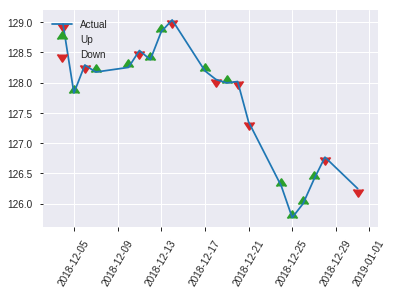


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1683880214299445
RMSE: 0.4103510953195379
LogLoss: 0.5048108822454742
Mean Per-Class Error: 0.23553113553113558
AUC: 0.8383394383394384
pr_auc: 0.8363708392102526
Gini: 0.6766788766788767
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42573943501818645: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   63   0.4846   (63.0/130.0)
1      9    117  0.0714   (9.0/126.0)
Total  76   180  0.2812   (72.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425739     0.764706  179
max f2                       0.425739     0.855263  179
max f0point5                 0.590643     0.809859  74
max accuracy                 0.539715     0.765625  107
max precision                0.964287     1         0
max recall                   0.117465     1         253
max specificity              0.964287     1         0
max absolute_mcc             0.590643     0.550843  74
max min_per_class_accuracy   0.518668     0.746032  123
max mean_per_class_accuracy  0.539715     0.764469  107

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.957448           2.03175   2.03175            1                0.961854  1                           0.961854            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.951412           1.3545    1.69312            0.666667         0.953208  0.833333                    0.957531            0.015873        0.0396825                  35.4497   69.3122
    3        0.03125                     0.944884           2.03175   1.77778            1                0.947586  0.875                       0.955045            0.015873        0.0555556                  103.175   77.7778
    4        0.0429688                   0.94203            2.03175   1.84704            1                0.942694  0.909091                    0.951676            0.0238095       0.0793651                  103.175   84.7042
    5        0.0507812                   0.93825            2.03175   1.87546            1                0.940204  0.923077                    0.949911            0.015873        0.0952381                  103.175   87.5458
    6        0.101562                    0.925062           2.03175   1.9536             1                0.931778  0.961538                    0.940845            0.103175        0.198413                   103.175   95.3602
    7        0.152344                    0.892289           2.03175   1.97965            1                0.908381  0.974359                    0.930024            0.103175        0.301587                   103.175   97.965
    8        0.203125                    0.759049           1.87546   1.9536             0.923077         0.839862  0.961538                    0.907483            0.0952381       0.396825                   87.5458   95.3602
    9        0.300781                    0.581752           1.6254    1.84704            0.8              0.629693  0.909091                    0.817292            0.15873         0.555556                   62.5397   84.7042
    10       0.402344                    0.54319            1.01587   1.63723            0.5              0.557785  0.805825                    0.751785            0.103175        0.65873                    1.5873    63.7232
    11       0.5                         0.513774           0.893968  1.49206            0.44             0.528439  0.734375                    0.708163            0.0873016       0.746032                   -10.6032  49.2063
    12       0.601562                    0.475745           0.781441  1.37209            0.384615         0.497281  0.675325                    0.672559            0.0793651       0.825397                   -21.8559  37.2088
    13       0.699219                    0.429363           0.975238  1.31666            0.48             0.456031  0.648045                    0.642318            0.0952381       0.920635                   -2.47619  31.6662
    14       0.800781                    0.36269            0.39072   1.19923            0.192308         0.395495  0.590244                    0.611014            0.0396825       0.960317                   -60.928   19.9226
    15       0.898438                    0.156996           0.16254   1.08654            0.08             0.245281  0.534783                    0.57126             0.015873        0.97619                    -83.746   8.65424
    16       1                           0.100211           0.234432  1                  0.115385         0.135679  0.492188                    0.527021          

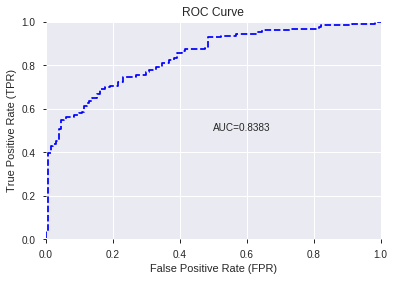

This function is available for GLM models only


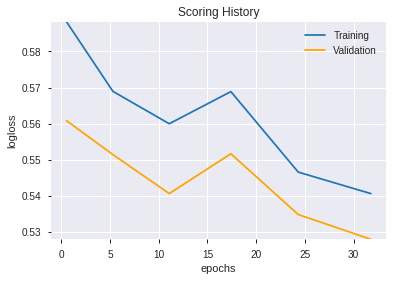

--2019-08-22 15:50:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_154125_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_154125_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'CCI_8',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'STOCHF_fastk',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'ULTOSC',
 'PLUS_DI_8',
 'HT_TRENDMODE',
 'SINH',
 'CDLONNECK',
 'CDLSHOOTINGSTAR',
 'CCI_14',
 'CDLSEPARATINGLINES',
 'COSH',
 'CDLTHRUSTING',
 'CDLLADDERBOTTOM',
 'CDLADVANCEBLOCK',
 'CDLHOMINGPIGEON',
 'CDLSTALLEDPATTERN',
 'WILLR_8',
 'CDLMORNINGSTAR',
 'EXP',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLUNIQUE3RIVER',
 'PLUS_DI_12',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLDARKCLOUDCOVER',
 'is_month_end',
 'is_quarter_end',
 'CDLHAMMER',
 'aroonup_30',
 'CDLMATCHINGLOW',
 'SIN',
 'weekofyear',
 'MINUS_DI_12',
 'is_quarter_start',
 'is_month_start',
 'CDLHARAMICROSS',
 'month',
 'CDL3OUTSIDE',
 'dayofyear',
 'week',
 'quarter']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155019_model_1  0.840598  0.488238              0.281746  0.404412  0.163549

variable  relative_importance  scaled_importance  percentage
0                CCI_8             0.817792           1.000000    0.133233
1    CDLGRAVESTONEDOJI             0.558697           0.683177    0.091022
2             WILLR_12             0.485396           0.593545    0.079080
3         STOCHF_fastk             0.387458           0.473785    0.063124
4            PLUS_DI_8             0.363354           0.444311    0.059197
5            CDLTAKURI             0.325607           0.398153    0.053047
6              WILLR_8             0.272519           0.333238    0.044398
7               CCI_14             0.229840           0.281049    0.037445
8     CDLDRAGONFLYDOJI             0.213178           0.260675    0.034731
9           PLUS_DI_12             0.199465           0.243907    0.032496
10   CDLINVERTEDHAMMER             0.183395           0.224256    0.029878
11  CDLCLOSINGMARUBOZU             0.155422           0.190051    0.025321
12           dayofyear             0.143811           0.175853    0.023429
13   CDLSTALLEDPATTERN             0.138477           0.169331    0.022560
14       CDLHANGINGMAN             0.132854           0.162455    0.021644
15  CDLSEPARATINGLINES             0.090913           0.111169    0.014811
16        CDLTHRUSTING             0.087798           0.107360    0.014304
17     CDLUNIQUE3RIVER             0.078399           0.095866    0.012773
18      CDL3LINESTRIKE             0.078189           0.095610    0.012738
19      CDLMORNINGSTAR             0.074362           0.090930    0.012115
20              ULTOSC             0.073861           0.090318    0.012033
21  CDLMORNINGDOJISTAR             0.068519           0.083785    0.011163
22     CDLLADDERBOTTOM             0.058622           0.071683    0.009551
23           CDLONNECK             0.058145           0.071100    0.009473
24         MINUS_DI_12             0.055034           0.067295    0.008966
25          aroonup_30             0.053793           0.065779    0.008764
26             quarter             0.052075           0.063678    0.008484
27  CDLEVENINGDOJISTAR             0.051480           0.062950    0.008387
28                week             0.047993           0.058686    0.007819
29               month             0.046803           0.057231    0.007625
30          weekofyear             0.046585           0.056965    0.007590
31           CDLHAMMER             0.045030           0.055063    0.007336
32                COSH             0.043516           0.053211    0.007089
33                SINH             0.043361           0.053022    0.007064
34                 EXP             0.043301           0.052949    0.007055
35      CDLHARAMICROSS             0.042820           0.052360    0.006976
36      CDLEVENINGSTAR             0.042803           0.052340    0.006973
37   CDLDARKCLOUDCOVER             0.037531           0.045893    0.006114
38                 SIN             0.032959           0.040303    0.005370
39      is_month_start             0.029932           0.036601    0.004876
40         CDL3OUTSIDE             0.025376           0.031029    0.004134
41      CDLMATCHINGLOW             0.023581           0.028835    0.003842
42     CDLSHOOTINGSTAR             0.022466           0.027471    0.003660
43      is_quarter_end             0.019609           0.023978    0.003195
44        HT_TRENDMODE             0.016372           0.020019    0.002667
45        is_month_end             0.012687           0.015514    0.002067
46     CDLHOMINGPIGEON             0.009888           0.012090    0.001611
47     CDLADVANCEBLOCK             0.006503           0.007952    0.001059
48    is_quarter_start             0.005759           0.007042    0.000938
49        CDLTASUKIGAP             0.004728           0.005781    0.000770

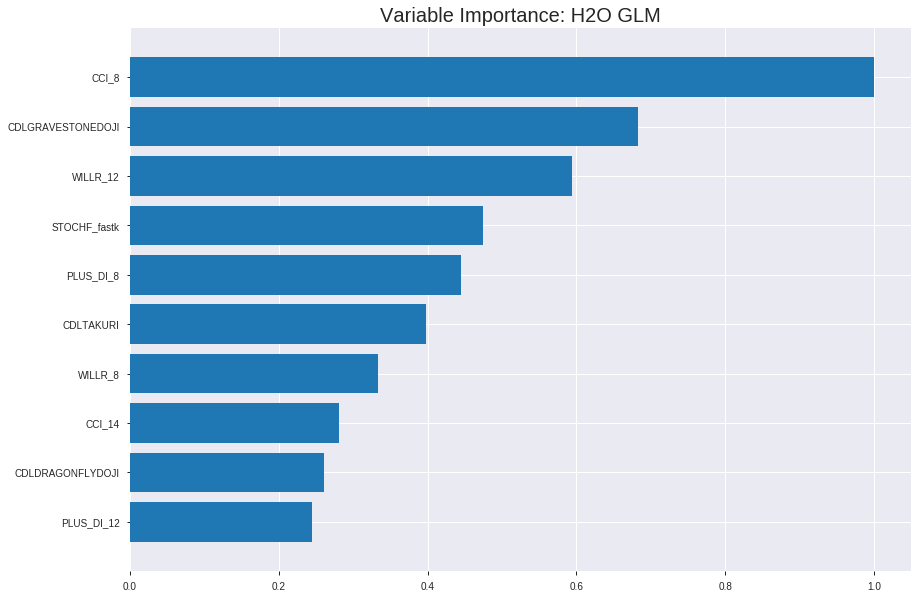

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155019_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18102636158990973
RMSE: 0.4254719280868125
LogLoss: 0.5319107217243804
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2478.2558210117336
Residual deviance: 1902.112740886384
AIC: 2004.112740886384
AUC: 0.8031938325991189
pr_auc: 0.8124305763940732
Gini: 0.6063876651982378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44464410320600994: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      507  373   0.4239   (373.0/880.0)
1      136  772   0.1498   (136.0/908.0)
Total  643  1145  0.2847   (509.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444644     0.75207   236
max f2                       0.168402     0.86007   337
max f0point5                 0.52346      0.731908  187
max accuracy                 0.517912     0.722595  191
max precision                0.996117     1         0
max recall                   0.0333713    1         390
max specificity              0.996117     1         0
max absolute_mcc             0.517912     0.446237  191
max min_per_class_accuracy   0.505812     0.717045  198
max mean_per_class_accuracy  0.517912     0.722965  191

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.979413           1.96916    1.96916            1                0.985169   1                           0.985169            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.969575           1.96916    1.96916            1                0.973075   1                           0.979122            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.965014           1.85977    1.9327             0.944444         0.967785   0.981481                    0.975343            0.0187225       0.05837                    85.9765   93.2697
    4        0.0402685                   0.95885            1.96916    1.94181            1                0.96218    0.986111                    0.972052            0.0198238       0.0781938                  96.9163   94.1814
    5        0.0503356                   0.952438           1.96916    1.94728            1                0.955737   0.988889                    0.968789            0.0198238       0.0980176                  96.9163   94.7283
    6        0.100112                    0.911388           1.90279    1.92516            0.966292         0.93423    0.977654                    0.951606            0.0947137       0.192731                   90.2787   92.5159
    7        0.150447                    0.786719           1.61909    1.82276            0.822222         0.8526     0.925651                    0.918481            0.0814978       0.274229                   61.909    82.2757
    8        0.200224                    0.691167           1.4824     1.73814            0.752809         0.728577   0.882682                    0.87127             0.0737885       0.348018                   48.2404   73.8144
    9        0.300336                    0.607456           1.38611    1.6208             0.703911         0.645071   0.823091                    0.795871            0.138767        0.486784                   38.6115   62.0801
    10       0.399888                    0.556615           1.16158    1.50648            0.589888         0.58294    0.765035                    0.742861            0.115639        0.602423                   16.1585   50.6479
    11       0.5                         0.507968           1.14409    1.43392            0.581006         0.532164   0.728188                    0.700675            0.114537        0.71696                    14.4095   43.3921
    12       0.600112                    0.468174           0.957079   1.35437            0.486034         0.487045   0.687791                    0.665037            0.095815        0.812775                   -4.29208  35.4373
    13       0.699664                    0.410571           0.752265   1.2687             0.382022         0.439656   0.644285                    0.632968            0.0748899       0.887665                   -24.7735  26.8701
    14       0.799776                    0.322142           0.583048   1.18287            0.296089         0.371817   0.600699                    0.600278            0.05837         0.946035                   -41.6952  18.2875
    15       0.899888                    0.114562           0.440036   1.10023            0.223464         0.204738   0.558732                    0.556275            0.0440529       0.990088                   -55.9964  10.0235
    16       1                           0.0029258          0.0990082  1                  0.0502793        0.0723667  0.50783  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17188208526241544
RMSE: 0.4145866438543522
LogLoss: 0.5190925374047911
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.1145564513349
Residual deviance: 530.5125732276965
AIC: 632.5125732276965
AUC: 0.8340001226279162
pr_auc: 0.845390229622337
Gini: 0.6680002452558325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46100081058407333: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  96   0.3855   (96.0/249.0)
1      30   232  0.1145   (30.0/262.0)
Total  183  328  0.2466   (126.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461001     0.786441  248
max f2                       0.101555     0.855438  360
max f0point5                 0.634592     0.788591  127
max accuracy                 0.468011     0.753425  245
max precision                0.989204     1         0
max recall                   0.0123652    1         399
max specificity              0.989204     1         0
max absolute_mcc             0.461001     0.521216  248
max min_per_class_accuracy   0.533235     0.744275  200
max mean_per_class_accuracy  0.57549      0.754047  166

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 52.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.976711           1.95038   1.95038            1                0.983425   1                           0.983425            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.970215           1.95038   1.95038            1                0.972843   1                           0.978615            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.962031           1.95038   1.95038            1                0.965071   1                           0.974383            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.956608           1.95038   1.95038            1                0.958344   1                           0.970564            0.019084        0.0801527                  95.0382   95.0382
    5        0.0508806                   0.951379           1.56031   1.87537            0.8              0.954018   0.961538                    0.967382            0.0152672       0.0954198                  56.0305   87.5367
    6        0.101761                    0.920969           1.95038   1.91287            1                0.936241   0.980769                    0.951811            0.0992366       0.194656                   95.0382   91.2874
    7        0.150685                    0.881173           1.63832   1.82373            0.84             0.904197   0.935065                    0.936352            0.0801527       0.274809                   63.8321   82.3734
    8        0.201566                    0.773527           1.72534   1.7989             0.884615         0.829694   0.92233                     0.909429            0.0877863       0.362595                   72.5338   79.8896
    9        0.30137                     0.639732           1.6062    1.73508            0.823529         0.692115   0.88961                     0.837461            0.160305        0.522901                   60.6197   73.508
    10       0.401174                    0.57636            1.22377   1.60788            0.627451         0.606135   0.82439                     0.779912            0.122137        0.645038                   22.3769   60.7876
    11       0.500978                    0.534526           0.917827  1.4704             0.470588         0.552018   0.753906                    0.734511            0.0916031       0.736641                   -8.21733  47.0405
    12       0.600783                    0.483269           1.03256   1.39767            0.529412         0.511251   0.716612                    0.697422            0.103053        0.839695                   3.2555    39.7668
    13       0.700587                    0.423074           0.68837   1.29662            0.352941         0.456219   0.664804                    0.663061            0.0687023       0.908397                   -31.163   29.6622
    14       0.800391                    0.301688           0.305942  1.17309            0.156863         0.375423   0.601467                    0.627194            0.0305344       0.938931                   -69.4058  17.309
    15       0.900196                    0.101555           0.458913  1.09391            0.235294         0.191303   0.56087                     0.578867            0.0458015       0.984733                   -54.1087  9.39097
    16       1                           0.0123652          0.152971  1                  0.0784314        0.0650881  0.51272                     0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 15:50:19  0.000 sec   2            .17E2     50            1.3686620271433747  1.3660446183258614
     2019-08-22 15:50:19  0.010 sec   4            .11E2     51            1.3590277656267968  1.355133932538674
     2019-08-22 15:50:19  0.019 sec   6            .66E1     51            1.34485572915736    1.3390936397932909
     2019-08-22 15:50:19  0.029 sec   8            .41E1     51            1.3249994715647713  1.3166285957985355
     2019-08-22 15:50:19  0.038 sec   10           .25E1     51            1.2989443734703945  1.2871950297960864
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 15:50:19  0.198 sec   36           .52E-2    51            1.0607876770107745  1.038510528314765
     2019-08-22 15:50:19  0.208 sec   38           .32E-2    51            1.0586319822525265  1.0402806278611332
     2019-08-22 15:50:19  0.221 sec   40           .2E-2     51            1.0570186932576022  1.04300298960256
     2019-08-22 15:50:19  0.233 sec   42           .12E-2    51            1.0557907997212457  1.0463776782251664
     2019-08-22 15:50:19  0.242 sec   44           .77E-3    51            1.054880471992866   1.0502238801772739


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7578125)

('F1', 0.7637540453074435)

('auc', 0.8405982905982905)

('logloss', 0.48823791938438216)

('mean_per_class_error', 0.24224664224664227)

('rmse', 0.40441198521901633)

('mse', 0.16354905378878587)

glm prediction progress: |████████████████████████████████████████████████| 100%


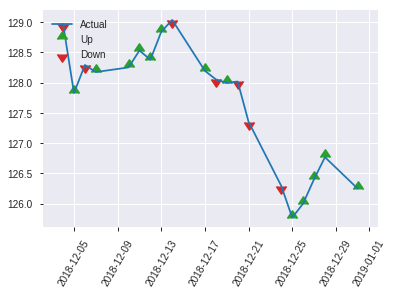


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16354905378878587
RMSE: 0.40441198521901633
LogLoss: 0.48823791938438216
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 355.07943398521934
Residual deviance: 249.97781472480366
AIC: 351.9778147248037
AUC: 0.8405982905982905
pr_auc: 0.851080764050168
Gini: 0.681196581196581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4097781776174753: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   65   0.5      (65.0/130.0)
1      8    118  0.0635   (8.0/126.0)
Total  73   183  0.2852   (73.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409778     0.763754  182
max f2                       0.317603     0.860367  204
max f0point5                 0.629598     0.786802  66
max accuracy                 0.518229     0.757812  119
max precision                0.995788     1         0
max recall                   0.0708606    1         243
max specificity              0.995788     1         0
max absolute_mcc             0.629598     0.515898  66
max min_per_class_accuracy   0.505335     0.753968  125
max mean_per_class_accuracy  0.505335     0.757753  125

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.972092           2.03175    2.03175            1                0.982683   1                           0.982683            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.962908           2.03175    2.03175            1                0.966828   1                           0.974755            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.95845            2.03175    2.03175            1                0.96004    1                           0.971077            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.950104           2.03175    2.03175            1                0.95307    1                           0.966166            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.948968           2.03175    2.03175            1                0.949782   1                           0.963645            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.926333           2.03175    2.03175            1                0.940682   1                           0.952164            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.890373           2.03175    2.03175            1                0.911529   1                           0.938619            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.757452           1.87546    1.99267            0.923077         0.831618   0.980769                    0.911869            0.0952381       0.404762                   87.5458   99.2674
    9        0.300781                    0.598711           1.21905    1.7415             0.6              0.647421   0.857143                    0.826009            0.119048        0.52381                    21.9048   74.1497
    10       0.402344                    0.547911           1.17216    1.59778            0.576923         0.570436   0.786408                    0.761496            0.119048        0.642857                   17.2161   59.7781
    11       0.5                         0.501121           1.13778    1.50794            0.56             0.524388   0.742188                    0.715186            0.111111        0.753968                   13.7778   50.7937
    12       0.601562                    0.472194           0.781441   1.38528            0.384615         0.485497   0.681818                    0.676407            0.0793651       0.833333                   -21.8559  38.5281
    13       0.699219                    0.416635           0.812698   1.30531            0.4              0.447648   0.642458                    0.644457            0.0793651       0.912698                   -18.7302  30.5312
    14       0.800781                    0.317603           0.547009   1.20914            0.269231         0.370442   0.595122                    0.609704            0.0555556       0.968254                   -45.2991  20.9137
    15       0.898438                    0.119408           0.0812698  1.08654            0.04             0.199596   0.534783                    0.565127            0.00793651      0.97619                    -91.873   8.65424
    16       1                           0.039648           0.234432   1                  0.115385         0.0755912  0.492188 

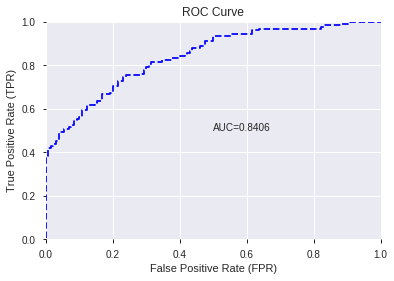

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


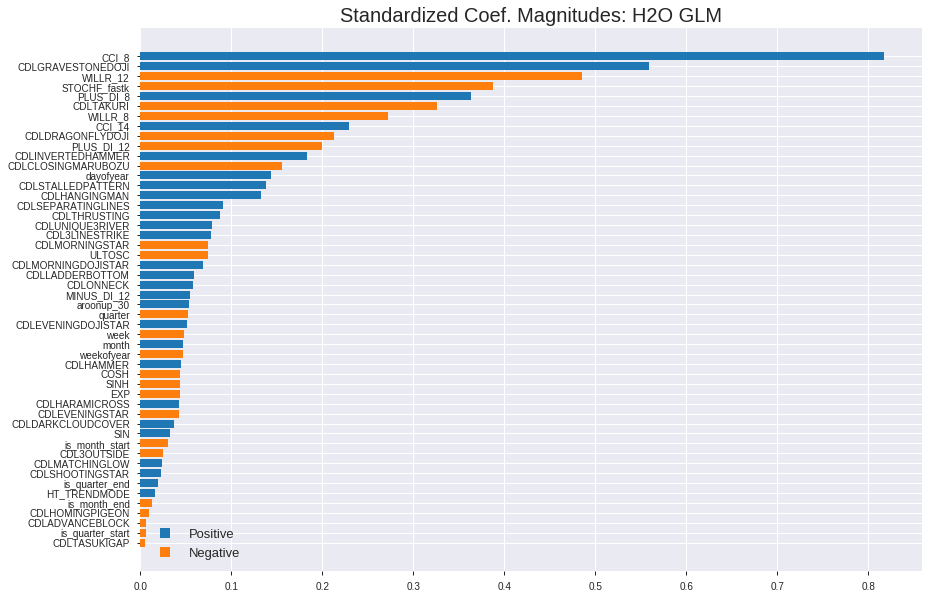

'log_likelihood'
--2019-08-22 15:50:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155019_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155019_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'WILLR_12',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'CDLTAKURI',
 'WILLR_8',
 'CCI_14',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_12',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'dayofyear',
 'CDLSTALLEDPATTERN',
 'CDLHANGINGMAN',
 'CDLSEPARATINGLINES',
 'CDLTHRUSTING',
 'CDLUNIQUE3RIVER',
 'CDL3LINESTRIKE',
 'CDLMORNINGSTAR',
 'ULTOSC',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'MINUS_DI_12',
 'aroonup_30',
 'quarter',
 'CDLEVENINGDOJISTAR',
 'week',
 'month',
 'weekofyear',
 'CDLHAMMER',
 'COSH',
 'SINH',
 'EXP',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'SIN',
 'is_month_start',
 'CDL3OUTSIDE',
 'CDLMATCHINGLOW',
 'CDLSHOOTINGSTAR',
 'is_quarter_end',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'is_quarter_start',
 'CDLTASUKIGAP']

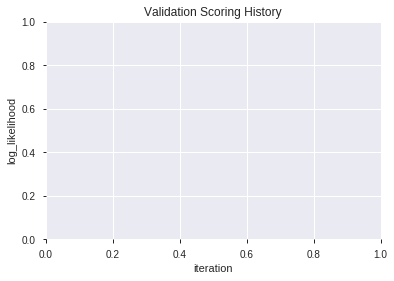

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_155030_model_5  0.853053  0.476947              0.220818  0.396626  0.157312
1               XGBoost_1_AutoML_20190822_155030  0.840781  0.488638              0.262759  0.404040  0.163248
2  XGBoost_grid_1_AutoML_20190822_155030_model_4  0.840598  0.498077              0.259035  0.406732  0.165431
3  XGBoost_grid_1_AutoML_20190822_155030_model_7  0.839805  0.489856              0.270574  0.404544  0.163656
4  XGBoost_grid_1_AutoML_20190822_155030_model_6  0.836630  0.493955              0.289438  0.406432  0.165187
5               XGBoost_2_AutoML_20190822_155030  0.835531  0.500047              0.252076  0.408891  0.167192
6  XGBoost_grid_1_AutoML_20190822_155030_model_2  0.831929  0.503481              0.277900  0.410908  0.168846
7  XGBoost_grid_1_AutoML_20190822_155030_model_1  0.831624  0.501839              0.249328  0.409946  0.168056
8  XGBoost_grid_1_AutoML_20190822_155030_model_3  0.829182  0.506922              0.270818  0.412652  0.170282
9               XGBoost_3_AutoML_20190822_155030  0.827167  0.505359              0.274664  0.412038  0.169775

variable  relative_importance  scaled_importance  percentage
0                CCI_8          2326.475342           1.000000    0.090145
1            dayofyear          1919.579834           0.825102    0.074379
2         STOCHF_fastk          1916.058350           0.823589    0.074242
3            PLUS_DI_8          1860.277344           0.799612    0.072081
4                  SIN          1748.548828           0.751587    0.067752
5              WILLR_8          1711.173218           0.735522    0.066304
6          MINUS_DI_12          1559.753418           0.670436    0.060437
7               ULTOSC          1526.048218           0.655949    0.059131
8                 COSH          1489.362305           0.640180    0.057709
9             WILLR_12          1482.336182           0.637160    0.057437
10              CCI_14          1265.700073           0.544042    0.049043
11           CDLTAKURI          1041.660522           0.447742    0.040362
12          PLUS_DI_12          1014.459106           0.436050    0.039308
13          aroonup_30           885.989319           0.380829    0.034330
14   CDLGRAVESTONEDOJI           853.569458           0.366894    0.033074
15                week           580.851318           0.249670    0.022507
16               month           478.008240           0.205465    0.018522
17                 EXP           460.705200           0.198027    0.017851
18    CDLDRAGONFLYDOJI           308.411804           0.132566    0.011950
19                SINH           245.602448           0.105568    0.009516
20          weekofyear           235.497040           0.101225    0.009125
21        HT_TRENDMODE           202.117340           0.086877    0.007832
22   CDLINVERTEDHAMMER           142.020172           0.061045    0.005503
23  CDLCLOSINGMARUBOZU           129.063095           0.055476    0.005001
24             quarter            60.335732           0.025934    0.002338
25      is_month_start            54.328358           0.023352    0.002105
26        is_month_end            52.338268           0.022497    0.002028
27     CDLSHOOTINGSTAR            37.780701           0.016239    0.001464
28           CDLHAMMER            36.796894           0.015817    0.001426
29       CDLHANGINGMAN            36.484608           0.015682    0.001414
30      CDLMATCHINGLOW            30.564791           0.013138    0.001184
31         CDL3OUTSIDE            20.473989           0.008800    0.000793
32    is_quarter_start            20.217218           0.008690    0.000783
33     CDLADVANCEBLOCK            19.372814           0.008327    0.000751
34      is_quarter_end            15.247524           0.006554    0.000591
35   CDLDARKCLOUDCOVER            10.463141           0.004497    0.000405
36      CDLHARAMICROSS             8.525379           0.003665    0.000330
37     CDLHOMINGPIGEON             5.435545           0.002336    0.000211
38  CDLMORNINGDOJISTAR             4.265614           0.001834    0.000165
39   CDLSTALLEDPATTERN             3.984863           0.001713    0.000154
40     CDLLADDERBOTTOM             3.294634           0.001416    0.000128
41        CDLTHRUSTING             2.274300           0.000978    0.000088
42      CDLEVENINGSTAR             1.443883           0.000621    0.000056
43  CDLSEPARATINGLINES             1.227836           0.000528    0.000048

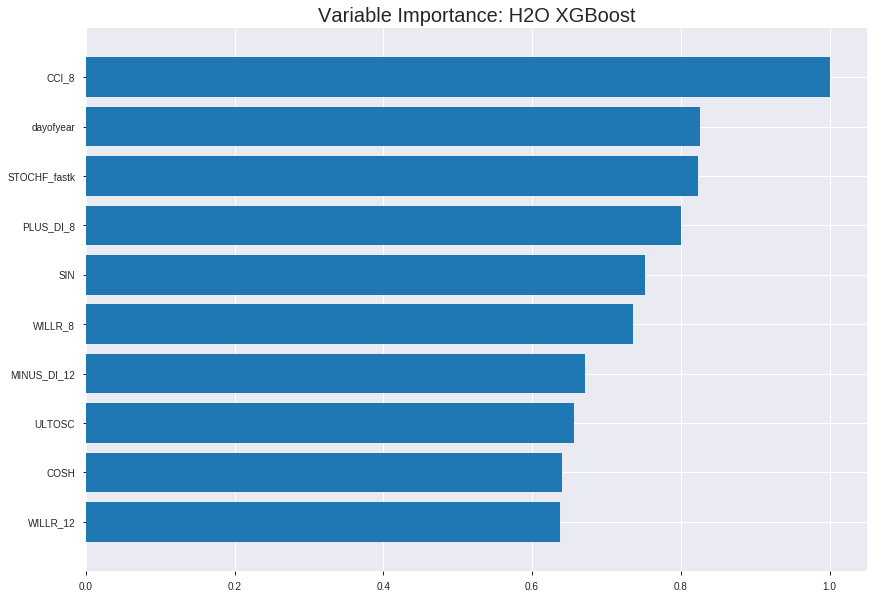

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_155030_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.028536914684947963
RMSE: 0.16892872664217878
LogLoss: 0.16225764261143305
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9977973568281938
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5416756272315979: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      880  0    0        (0.0/880.0)
1      0    908  0        (0.0/908.0)
Total  880  908  0        (0.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.541676     1        198
max f2                       0.541676     1        198
max f0point5                 0.541676     1        198
max accuracy                 0.541676     1        198
max precision                0.974308     1        0
max recall                   0.541676     1        198
max specificity              0.974308     1        0
max absolute_mcc             0.541676     1        198
max min_per_class_accuracy   0.541676     1        198
max mean_per_class_accuracy  0.541676     1        198

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.966337           1.96916   1.96916            1                0.968988   1                           0.968988            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.96342            1.96916   1.96916            1                0.964969   1                           0.966978            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.961505           1.96916   1.96916            1                0.962477   1                           0.965478            0.0198238       0.0594714                  96.9163   96.9163
    4        0.0402685                   0.959717           1.96916   1.96916            1                0.960796   1                           0.964307            0.0198238       0.0792952                  96.9163   96.9163
    5        0.0503356                   0.957521           1.96916   1.96916            1                0.958553   1                           0.963156            0.0198238       0.0991189                  96.9163   96.9163
    6        0.100112                    0.940693           1.96916   1.96916            1                0.950014   1                           0.956622            0.0980176       0.197137                   96.9163   96.9163
    7        0.150447                    0.921201           1.96916   1.96916            1                0.931077   1                           0.948075            0.0991189       0.296256                   96.9163   96.9163
    8        0.200224                    0.896527           1.96916   1.96916            1                0.909173   1                           0.938404            0.0980176       0.394273                   96.9163   96.9163
    9        0.300336                    0.849765           1.96916   1.96916            1                0.87351    1                           0.916773            0.197137        0.59141                    96.9163   96.9163
    10       0.399888                    0.790862           1.96916   1.96916            1                0.822371   1                           0.893271            0.196035        0.787445                   96.9163   96.9163
    11       0.5                         0.611822           1.96916   1.96916            1                0.735649   1                           0.861712            0.197137        0.984581                   96.9163   96.9163
    12       0.600112                    0.222563           0.154013  1.66636            0.0782123        0.308095   0.846226                    0.769356            0.0154185       1                          -84.5987  66.6356
    13       0.699664                    0.159976           0         1.42926            0                0.189128   0.725819                    0.686798            0               1                          -100      42.9257
    14       0.799776                    0.115912           0         1.25035            0                0.136937   0.634965                    0.617969            0               1                          -100      25.035
    15       0.899888                    0.0665996          0         1.11125            0                0.0909417  0.564326                    0.559338            0               1                          -100      11.1249
    16       1                           0.0235447          0         1                  0                0.0477836  0.50783                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1798191395241355
RMSE: 0.42405086902886485
LogLoss: 0.5340285619815665
Mean Per-Class Error: 0.25629234495232844
AUC: 0.8184953554676723
pr_auc: 0.8255540575785163
Gini: 0.6369907109353445
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5548519194126129: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      168  81   0.3253   (81.0/249.0)
1      52   210  0.1985   (52.0/262.0)
Total  220  291  0.2603   (133.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.554852     0.759494  211
max f2                       0.159935     0.862534  341
max f0point5                 0.719566     0.769944  139
max accuracy                 0.574943     0.74364   203
max precision                0.974718     1         0
max recall                   0.0598858    1         386
max specificity              0.974718     1         0
max absolute_mcc             0.689281     0.492592  152
max min_per_class_accuracy   0.61037      0.725191  188
max mean_per_class_accuracy  0.689281     0.743708  152

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 56.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.964973           1.95038   1.95038            1                0.96745    1                           0.96745             0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.960632           1.95038   1.95038            1                0.962177   1                           0.965053            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.955859           1.95038   1.95038            1                0.95869    1                           0.963065            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.953314           1.56031   1.85751            0.8              0.954449   0.952381                    0.961013            0.0152672       0.0763359                  56.0305   85.7506
    5        0.0508806                   0.951861           1.95038   1.87537            1                0.952783   0.961538                    0.959431            0.019084        0.0954198                  95.0382   87.5367
    6        0.101761                    0.933601           1.80035   1.83786            0.923077         0.943584   0.942308                    0.951507            0.0916031       0.187023                   80.0352   83.786
    7        0.150685                    0.916317           1.71634   1.7984             0.88             0.926573   0.922078                    0.943412            0.0839695       0.270992                   71.6336   79.8404
    8        0.201566                    0.885945           1.65032   1.76102            0.846154         0.898919   0.902913                    0.932181            0.0839695       0.354962                   65.0323   76.1024
    9        0.30137                     0.809338           1.45323   1.65909            0.745098         0.850658   0.850649                    0.905183            0.145038        0.5                        45.3226   65.9091
    10       0.401174                    0.715798           1.3385    1.57933            0.686275         0.759973   0.809756                    0.869058            0.133588        0.633588                   33.8497   57.9333
    11       0.500978                    0.615126           0.841341  1.43231            0.431373         0.666793   0.734375                    0.828763            0.0839695       0.717557                   -15.8659  43.2312
    12       0.600783                    0.501794           1.03256   1.3659             0.529412         0.568149   0.700326                    0.785469            0.103053        0.820611                   3.2555    36.5902
    13       0.700587                    0.375866           0.726613  1.27483            0.372549         0.436399   0.653631                    0.735741            0.0725191       0.89313                    -27.3387  27.483
    14       0.800391                    0.239869           0.535399  1.18263            0.27451          0.308162   0.606357                    0.682424            0.0534351       0.946565                   -46.4601  18.2628
    15       0.900196                    0.103111           0.382428  1.09391            0.196078         0.164833   0.56087                     0.625039            0.0381679       0.984733                   -61.7572  9.39097
    16       1                           0.0402308          0.152971  1                  0.0784314        0.0671758  0.51272                     0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:50:43  6.381 sec   0                  0.5              0.693147            0.5             0                  1                0.49217                          0.5                0.693147              0.5               0                    1                  0.48728
    2019-08-22 15:50:43  6.738 sec   5                  0.439828         0.578907            0.974363        0.967272           1.96916          0.0760626                        0.470887           0.636024              0.783339          0.761166             1.67176            0.318982
    2019-08-22 15:50:44  7.056 sec   10                 0.389974         0.491789            0.992713        0.983804           1.96916          0.0352349                        0.448997           0.593404              0.812678          0.797563             1.95038            0.2818
    2019-08-22 15:50:44  7.374 sec   15                 0.349279         0.424459            0.997006        0.994904           1.96916          0.0229306                        0.436871           0.568504              0.815621          0.798473             1.62532            0.250489
    2019-08-22 15:50:44  7.717 sec   20                 0.318556         0.375607            0.99812         0.993764           1.96916          0.0145414                        0.430809           0.554966              0.815759          0.806701             1.62532            0.260274
    2019-08-22 15:50:45  8.042 sec   25                 0.292459         0.334463            0.998935        0.997834           1.96916          0.0145414                        0.425503           0.542052              0.817507          0.810574             1.62532            0.273973
    2019-08-22 15:50:45  8.396 sec   30                 0.268496         0.298302            0.999324        0.996019           1.96916          0.00950783                       0.420347           0.529785              0.823278          0.826049             1.95038            0.262231
    2019-08-22 15:50:45  8.728 sec   35                 0.2494           0.269876            0.999627        0.99413            1.96916          0.00838926                       0.420691           0.528887              0.819798          0.821395             1.95038            0.273973
    2019-08-22 15:50:46  9.100 sec   40                 0.232505         0.245437            0.999782        0.996485           1.96916          0.00838926                       0.422094           0.530394              0.817054          0.815727             1.95038            0.266145
    2019-08-22 15:50:46  9.450 sec   45                 0.218288         0.225102            0.999864        0.995463           1.96916          0.00503356                       0.423104           0.531803              0.81707           0.817313             1.95038            0.287671
    2019-08-22 15:50:46  9.847 sec   50                 0.204613         0.206962            0.999955        0.998855           1.96916          0.00279642                       0.423625           0.532356              0.816464          0.818267             1.95038            0.293542
    2019-08-22 15:50:47  10.231 sec  55                 0.191609         0.190226            0.999984        0.998883           1.96916          0.00167785                       0.424536           0.533727              0.815913          0.82

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
CCI_8               2326.475341796875      1.0                    0.09014507671491204
dayofyear           1919.579833984375      0.8251021618401377     0.07437889767671899
STOCHF_fastk        1916.058349609375      0.8235885054038395     0.07424244900114886
PLUS_DI_8           1860.27734375          0.7996118894229058     0.07208107511418362
SIN                 1748.548828125         0.7515870882923229     0.06775187573204881
---                 ---                    ---                    ---
CDLSTALLEDPATTERN   3.98486328125          0.0017128328031932863  0.0001544034444436766
CDLLADDERBOTTOM     3.2946338653564453     0.0014161481990227346  0.00012765878804058892
CDLTHRUSTING        2.2742996215820312     0.000977573061155015   8.812339859225024e-05
CDLEVENINGSTAR      1.4438834190368652     0.0006206313013924611  5.59468562756991e-05
CDLSEPARATINGLINES  1.2278361320495605     0.000527766664873065   4.757556649255571e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.77734375)

('F1', 0.7985865724381626)

('auc', 0.853052503052503)

('logloss', 0.4769470223389254)

('mean_per_class_error', 0.2208180708180708)

('rmse', 0.3966255845050619)

('mse', 0.157311854283982)

xgboost prediction progress: |████████████████████████████████████████████| 100%


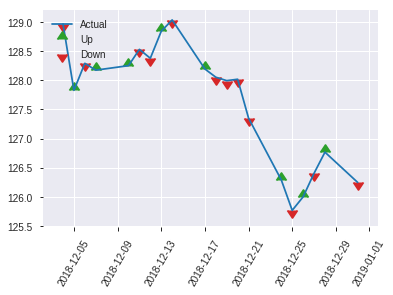


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.157311854283982
RMSE: 0.3966255845050619
LogLoss: 0.4769470223389254
Mean Per-Class Error: 0.2208180708180708
AUC: 0.853052503052503
pr_auc: 0.8586108481686519
Gini: 0.706105006105006
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4137834906578064: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      86   44   0.3385   (44.0/130.0)
1      13   113  0.1032   (13.0/126.0)
Total  99   157  0.2227   (57.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413783     0.798587  156
max f2                       0.301781     0.864553  189
max f0point5                 0.771142     0.79602   68
max accuracy                 0.413783     0.777344  156
max precision                0.971688     1         0
max recall                   0.0318781    1         255
max specificity              0.971688     1         0
max absolute_mcc             0.413783     0.573201  156
max min_per_class_accuracy   0.519329     0.746154  127
max mean_per_class_accuracy  0.413783     0.779182  156

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 52.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.968001           2.03175   2.03175            1                0.970554   1                           0.970554            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.964818           2.03175   2.03175            1                0.966499   1                           0.968526            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.963217           2.03175   2.03175            1                0.963586   1                           0.967291            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.961102           2.03175   2.03175            1                0.962107   1                           0.965878            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.955137           2.03175   2.03175            1                0.959955   1                           0.964966            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.931267           2.03175   2.03175            1                0.942847   1                           0.953907            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.90094            1.87546   1.97965            0.923077         0.919446   0.974359                    0.94242             0.0952381       0.301587                   87.5458   97.965
    8        0.203125                    0.842913           2.03175   1.99267            1                0.877022   0.980769                    0.92607             0.103175        0.404762                   103.175   99.2674
    9        0.300781                    0.723887           1.30032   1.76788            0.64             0.789935   0.87013                     0.88187             0.126984        0.531746                   30.0317   76.7883
    10       0.402344                    0.589795           1.25031   1.63723            0.615385         0.661621   0.805825                    0.826273            0.126984        0.65873                    25.0305   63.7232
    11       0.5                         0.518856           0.975238  1.50794            0.48             0.549603   0.742188                    0.772236            0.0952381       0.753968                   -2.47619  50.7937
    12       0.601562                    0.416573           1.17216   1.45125            0.576923         0.476585   0.714286                    0.722321            0.119048        0.873016                   17.2161   45.1247
    13       0.699219                    0.341379           0.568889  1.32801            0.28             0.379483   0.653631                    0.674439            0.0555556       0.928571                   -43.1111  32.8013
    14       0.800781                    0.24448            0.312576  1.19923            0.153846         0.290361   0.590244                    0.625726            0.031746        0.960317                   -68.7424  19.9226
    15       0.898438                    0.121726           0.24381   1.09538            0.12             0.181361   0.53913                     0.577426            0.0238095       0.984127                   -75.619   9.53761
    16       1                           0.0318781          0.156288  1                  0.0769231        0.0691537  0.492188                    

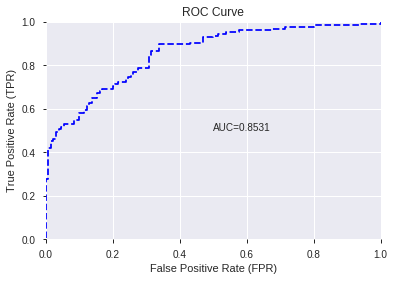

This function is available for GLM models only


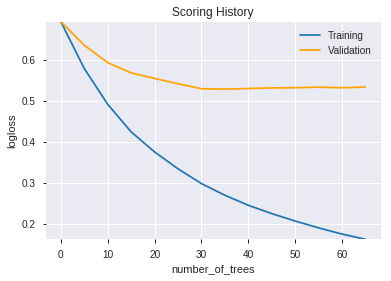

--2019-08-22 15:50:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_155030_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_155030_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CCI_8',
 'dayofyear',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'SIN',
 'WILLR_8',
 'MINUS_DI_12',
 'ULTOSC',
 'COSH',
 'WILLR_12',
 'CCI_14',
 'CDLTAKURI',
 'PLUS_DI_12',
 'aroonup_30',
 'CDLGRAVESTONEDOJI',
 'week',
 'month',
 'EXP',
 'CDLDRAGONFLYDOJI',
 'SINH',
 'weekofyear',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'quarter',
 'is_month_start',
 'is_month_end',
 'CDLSHOOTINGSTAR',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLMATCHINGLOW',
 'CDL3OUTSIDE',
 'is_quarter_start',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'CDLDARKCLOUDCOVER',
 'CDLHARAMICROSS',
 'CDLHOMINGPIGEON',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190822_155102_model_1  0.861233  0.485699              0.221062  0.39045  0.152451

variable  relative_importance  scaled_importance    percentage
0                 STOCHF_fastk             0.528671           1.000000  2.079060e-02
1            CDLGRAVESTONEDOJI             0.483642           0.914827  1.901979e-02
2                        CCI_8             0.446282           0.844159  1.755057e-02
3                   MINUS_DI_8             0.296076           0.560038  1.164353e-02
4                       CCI_20             0.283034           0.535368  1.113063e-02
...                        ...                  ...                ...           ...
1021  BBANDS_middleband_20_5_4             0.000073           0.000138  2.860207e-06
1022  BBANDS_middleband_14_1_4             0.000071           0.000134  2.783256e-06
1023  BBANDS_middleband_20_0_3             0.000059           0.000111  2.315816e-06
1024                   MA_30_0             0.000030           0.000056  1.165841e-06
1025  BBANDS_middleband_14_1_2             0.000022           0.000042  8.674154e-07

[1026 rows x 4 columns]

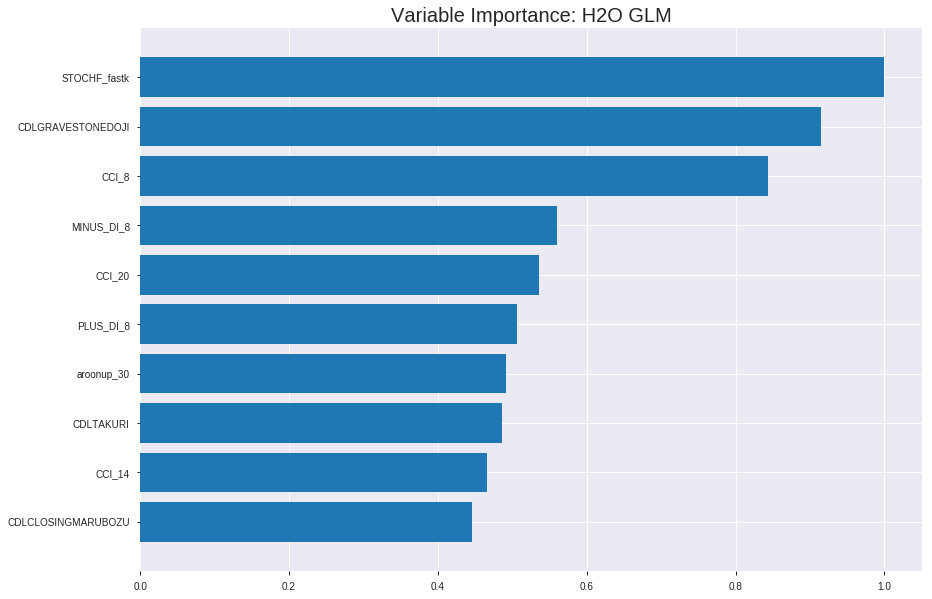

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155102_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1627668629695808
RMSE: 0.40344375440646096
LogLoss: 0.48754623393677143
Null degrees of freedom: 1787
Residual degrees of freedom: 761
Null deviance: 2478.2558210117336
Residual deviance: 1743.4653325578947
AIC: 3797.4653325578947
AUC: 0.8425579445334401
pr_auc: 0.8451364749185837
Gini: 0.6851158890668803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4325250193591813: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      558  322   0.3659   (322.0/880.0)
1      125  783   0.1377   (125.0/908.0)
Total  683  1105  0.25     (447.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432525     0.777943  235
max f2                       0.267653     0.871468  298
max f0point5                 0.58725      0.774194  161
max accuracy                 0.477557     0.752796  219
max precision                0.99934      1         0
max recall                   0.0520261    1         379
max specificity              0.99934      1         0
max absolute_mcc             0.432525     0.510795  235
max min_per_class_accuracy   0.52104      0.751101  196
max mean_per_class_accuracy  0.523536     0.752325  195

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.984472           1.96916    1.96916            1                0.990193   1                           0.990193            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.974908           1.85977    1.91446            0.944444         0.979627   0.972222                    0.98491             0.0187225       0.0385463                  85.9765   91.4464
    3        0.0302013                   0.970998           1.96916    1.9327             1                0.972758   0.981481                    0.980859            0.0198238       0.05837                    96.9163   93.2697
    4        0.0402685                   0.966276           1.96916    1.94181            1                0.968393   0.986111                    0.977743            0.0198238       0.0781938                  96.9163   94.1814
    5        0.0503356                   0.960738           1.96916    1.94728            1                0.963531   0.988889                    0.9749              0.0198238       0.0980176                  96.9163   94.7283
    6        0.100112                    0.913393           1.90279    1.92516            0.966292         0.941417   0.977654                    0.958252            0.0947137       0.192731                   90.2787   92.5159
    7        0.150447                    0.831365           1.75037    1.86668            0.888889         0.874223   0.947955                    0.930138            0.0881057       0.280837                   75.0367   86.6679
    8        0.200224                    0.7566             1.59303    1.79865            0.808989         0.79108    0.913408                    0.895568            0.0792952       0.360132                   59.3031   79.8649
    9        0.300336                    0.6579             1.51813    1.70514            0.77095          0.701767   0.865922                    0.830968            0.151982        0.512115                   51.8126   70.5141
    10       0.399888                    0.582734           1.28327    1.60012            0.651685         0.615544   0.812587                    0.777338            0.127753        0.639868                   28.3275   60.0117
    11       0.5                         0.521253           1.10009    1.5                0.558659         0.550567   0.761745                    0.731933            0.110132        0.75                       10.0091   50
    12       0.600112                    0.445138           0.935077   1.40576            0.47486          0.488543   0.713886                    0.69133             0.0936123       0.843612                   -6.49226  40.5758
    13       0.699664                    0.357571           0.719076   1.30805            0.365169         0.404008   0.664269                    0.650448            0.0715859       0.915198                   -28.0924  30.8053
    14       0.799776                    0.237791           0.539045   1.21179            0.273743         0.303685   0.615385                    0.607042            0.0539648       0.969163                   -46.0955  21.1793
    15       0.899888                    0.100759           0.253021   1.10513            0.128492         0.166439   0.561218                    0.558025            0.0253304       0.994493                   -74.6979  10.513
    16       1                           0.00112603         0.0550046  1                  0.027933         0.0566322  0.50783        



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1702077155941341
RMSE: 0.4125623778219896
LogLoss: 0.5186698880369155
Null degrees of freedom: 510
Residual degrees of freedom: -516
Null deviance: 708.1145564513349
Residual deviance: 530.0806255737277
AIC: 2584.080625573728
AUC: 0.8257993807290229
pr_auc: 0.8367918247428843
Gini: 0.6515987614580458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4098045788638501: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  87   0.3494   (87.0/249.0)
1      40   222  0.1527   (40.0/262.0)
Total  202  309  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409805     0.777583  242
max f2                       0.166395     0.854905  328
max f0point5                 0.645158     0.774194  132
max accuracy                 0.411024     0.751468  241
max precision                0.99714      1         0
max recall                   0.0189714    1         395
max specificity              0.99714      1         0
max absolute_mcc             0.409805     0.509054  242
max min_per_class_accuracy   0.494107     0.736641  200
max mean_per_class_accuracy  0.411024     0.749065  241

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 49.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.980017           1.95038   1.95038            1                0.989672  1                           0.989672            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.974958           1.95038   1.95038            1                0.977084  1                           0.98395             0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.967667           1.95038   1.95038            1                0.971113  1                           0.979939            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.958616           1.56031   1.85751            0.8              0.96178   0.952381                    0.975615            0.0152672       0.0763359                  56.0305   85.7506
    5        0.0508806                   0.946742           1.95038   1.87537            1                0.95477   0.961538                    0.971606            0.019084        0.0954198                  95.0382   87.5367
    6        0.101761                    0.90701            1.87537   1.87537            0.961538         0.928541  0.961538                    0.950074            0.0954198       0.19084                    87.5367   87.5367
    7        0.150685                    0.849551           1.79435   1.84906            0.92             0.887153  0.948052                    0.929645            0.0877863       0.278626                   79.4351   84.9063
    8        0.201566                    0.802516           1.80035   1.83677            0.923077         0.823266  0.941748                    0.902792            0.0916031       0.370229                   80.0352   83.6767
    9        0.30137                     0.669297           1.37674   1.68442            0.705882         0.729297  0.863636                    0.845336            0.137405        0.507634                   37.674    68.4421
    10       0.401174                    0.573599           1.18553   1.56031            0.607843         0.616626  0.8                         0.788437            0.118321        0.625954                   18.5526   56.0305
    11       0.500978                    0.496457           1.0708    1.46279            0.54902          0.532632  0.75                        0.737476            0.10687         0.732824                   7.07978   46.2786
    12       0.600783                    0.411024           1.10904   1.40402            0.568627         0.451983  0.71987                     0.690049            0.110687        0.843511                   10.9041   40.4021
    13       0.700587                    0.33343            0.650127  1.29662            0.333333         0.373985  0.664804                    0.645023            0.0648855       0.908397                   -34.9873  29.6622
    14       0.800391                    0.197902           0.344185  1.17786            0.176471         0.264267  0.603912                    0.597545            0.0343511       0.942748                   -65.5815  17.7859
    15       0.900196                    0.0861807          0.267699  1.07695            0.137255         0.136375  0.552174                    0.546415            0.0267176       0.969466                   -73.2301  7.69499
    16       1                           0.00495331         0.305942  1                  0.156863         0.046056  0.51272                     0.496477         


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 15:51:06  0.000 sec         2            .17E2     983           1.3623198162341306  1.3616220212362256
     2019-08-22 15:51:08  2.198 sec         4            .12E2     1013          1.3544629309263903  1.3533626384549278
     2019-08-22 15:51:10  4.412 sec         6            .9E1      1017          1.3443514037601814  1.3426860120604827
     2019-08-22 15:51:12  6.676 sec         8            .66E1     1018          1.33155619516527    1.3291494866244478
     2019-08-22 15:51:15  8.932 sec         10           .48E1     1022          1.3157623724209477  1.3124132804096873
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-22 15:52:02  55.774 sec        50           .83E-2    1027          0.9685026985807177  1.0377488255346001
     2019-08-22 15:52:04  58.106 sec        52           .61E-2    1027          0.9624456429750934  1.0386913540432134
     2019-08-22 15:52:06  1 min  0.352 sec  54           .44E-2    1027          0.9568589581185861  1.0400095418843
     2019-08-22 15:52:08  1 min  2.699 sec  56           .32E-2    1027          0.9516048556608433  1.0417503024771069
     2019-08-22 15:52:11  1 min  4.966 sec  58           .23E-2    1027          0.9462572750757346  1.0436747325348121


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7890625)

('F1', 0.7956989247311828)

('auc', 0.8612332112332112)

('logloss', 0.48569888112876347)

('mean_per_class_error', 0.21025641025641018)

('rmse', 0.39044993104838677)

('mse', 0.15245114865568998)

glm prediction progress: |████████████████████████████████████████████████| 100%


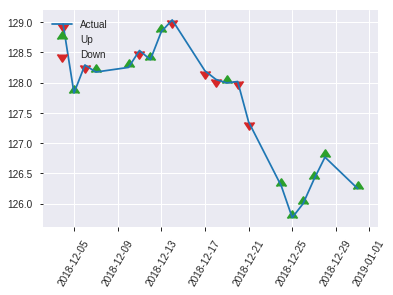


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15245114865568998
RMSE: 0.39044993104838677
LogLoss: 0.48569888112876347
Null degrees of freedom: 255
Residual degrees of freedom: -771
Null deviance: 355.07943398521934
Residual deviance: 248.67782713792718
AIC: 2302.677827137927
AUC: 0.8612332112332112
pr_auc: 0.8690621925743997
Gini: 0.7224664224664223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4179544375462731: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   42   0.3231   (42.0/130.0)
1      15   111  0.119    (15.0/126.0)
Total  103  153  0.2227   (57.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417954     0.795699  152
max f2                       0.335269     0.866373  176
max f0point5                 0.736626     0.801105  58
max accuracy                 0.449799     0.789062  137
max precision                0.995498     1         0
max recall                   0.000473553  1         255
max specificity              0.995498     1         0
max absolute_mcc             0.449799     0.581193  137
max min_per_class_accuracy   0.498551     0.777778  125
max mean_per_class_accuracy  0.449799     0.789744  137

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.976133           2.03175    2.03175            1                0.989166   1                           0.989166            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.97152            2.03175    2.03175            1                0.973222   1                           0.981194            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.969686           2.03175    2.03175            1                0.971034   1                           0.978654            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.96466            2.03175    2.03175            1                0.967506   1                           0.975614            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.958886           2.03175    2.03175            1                0.961182   1                           0.973394            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.926588           2.03175    2.03175            1                0.940467   1                           0.95693             0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.8739             2.03175    2.03175            1                0.899577   1                           0.937813            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.786937           2.03175    2.03175            1                0.839215   1                           0.913163            0.103175        0.412698                   103.175   103.175
    9        0.300781                    0.638064           1.30032    1.79427            0.64             0.705345   0.883117                    0.84569             0.126984        0.539683                   30.0317   79.4269
    10       0.402344                    0.556915           1.09402    1.61751            0.538462         0.594003   0.796117                    0.782157            0.111111        0.650794                   9.40171   61.7507
    11       0.5                         0.479785           1.38159    1.57143            0.68             0.525968   0.773438                    0.73212             0.134921        0.785714                   38.1587   57.1429
    12       0.601562                    0.416851           0.937729   1.46444            0.461538         0.443229   0.720779                    0.683346            0.0952381       0.880952                   -6.22711  46.444
    13       0.699219                    0.328844           0.568889   1.33936            0.28             0.373627   0.659218                    0.640089            0.0555556       0.936508                   -43.1111  33.9363
    14       0.800781                    0.229865           0.234432   1.19923            0.115385         0.280623   0.590244                    0.594499            0.0238095       0.960317                   -76.5568  19.9226
    15       0.898438                    0.111748           0.0812698  1.07771            0.04             0.160288   0.530435                    0.547302            0.00793651      0.968254                   -91.873   7.77088
    16       1                           0.000473553        0.312576   1                  0.153846         0.0571084  0.492188  

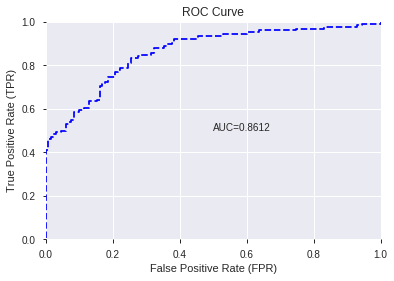

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


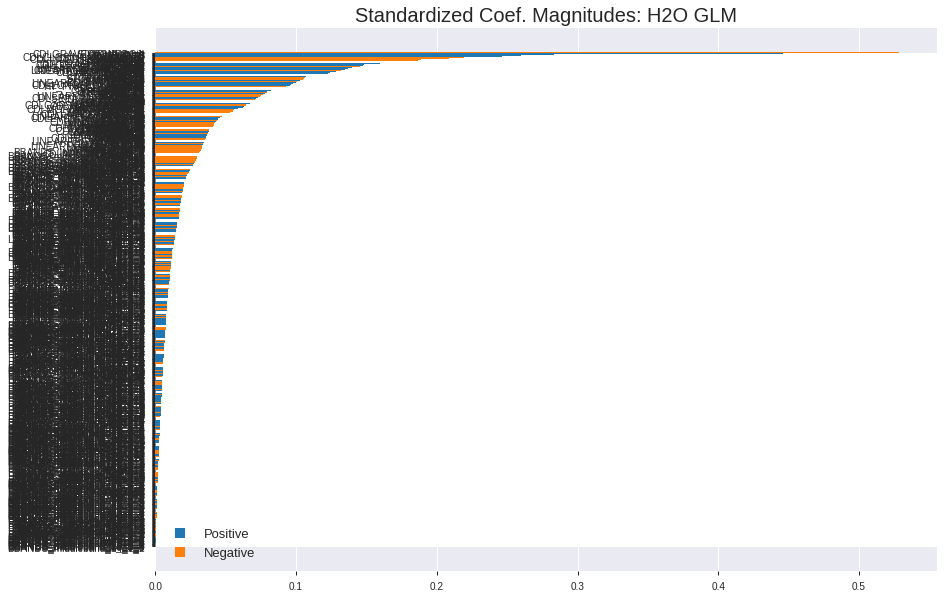

'log_likelihood'
--2019-08-22 15:52:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155102_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155102_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

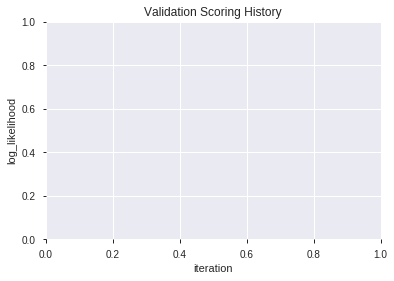

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_155245_model_7  0.861477  0.478775              0.199817  0.398157  0.158529
1               XGBoost_1_AutoML_20190822_155245  0.860562  0.479718              0.228755  0.397454  0.157970
2  XGBoost_grid_1_AutoML_20190822_155245_model_2  0.855983  0.489477              0.221795  0.402273  0.161823
3  XGBoost_grid_1_AutoML_20190822_155245_model_3  0.855128  0.484644              0.217705  0.401092  0.160875
4               XGBoost_2_AutoML_20190822_155245  0.854945  0.483066              0.225275  0.398661  0.158930
5  XGBoost_grid_1_AutoML_20190822_155245_model_4  0.847558  0.491450              0.270208  0.403225  0.162591
6               XGBoost_3_AutoML_20190822_155245  0.844383  0.485102              0.244261  0.403033  0.162435
7  XGBoost_grid_1_AutoML_20190822_155245_model_6  0.844383  0.492206              0.244994  0.404712  0.163792
8  XGBoost_grid_1_AutoML_20190822_155245_model_5  0.843407  0.495588              0.240293  0.405085  0.164094
9  XGBoost_grid_1_AutoML_20190822_155245_model_1  0.841819  0.495274              0.244872  0.407417  0.165988

variable  relative_importance  scaled_importance  percentage
0          CDLGRAVESTONEDOJI          1038.341797           1.000000    0.080132
1                  CDLTAKURI           744.228699           0.716747    0.057435
2           CDLDRAGONFLYDOJI           565.754456           0.544863    0.043661
3               STOCHF_fastk           405.870239           0.390883    0.031322
4                    WILLR_8           232.539169           0.223952    0.017946
..                       ...                  ...                ...         ...
384  BBANDS_lowerband_30_1_5             0.334261           0.000322    0.000026
385                     fama             0.306141           0.000295    0.000024
386  BBANDS_upperband_20_0_3             0.296879           0.000286    0.000023
387                    EMA_8             0.262930           0.000253    0.000020
388  BBANDS_lowerband_24_5_4             0.232893           0.000224    0.000018

[389 rows x 4 columns]

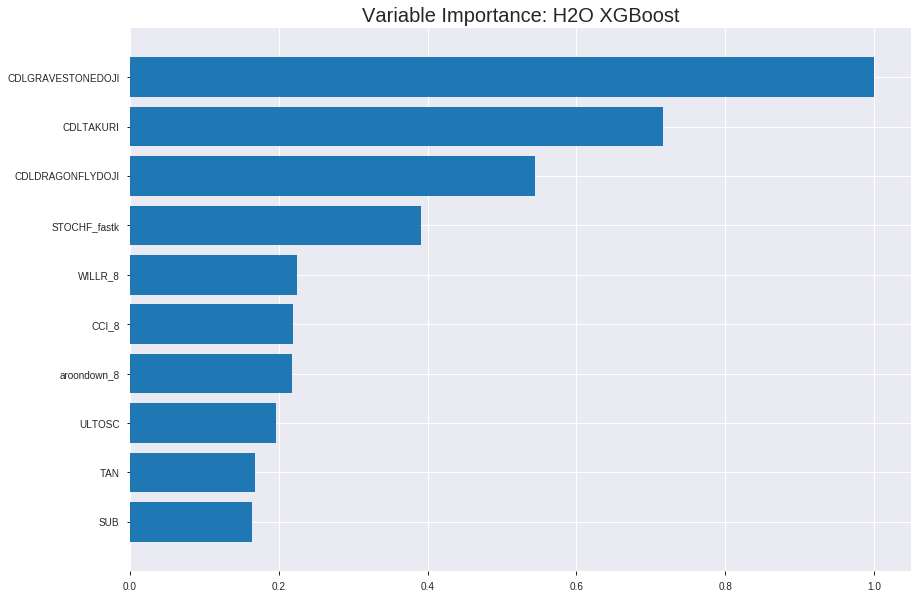

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_155245_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0798673534898702
RMSE: 0.2826081270768238
LogLoss: 0.30068260636132893
Mean Per-Class Error: 0.04855576692030428
AUC: 0.9857823137765319
pr_auc: 0.9849468199685675
Gini: 0.9715646275530638
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4955040216445923: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      835  45   0.0511   (45.0/880.0)
1      42   866  0.0463   (42.0/908.0)
Total  877  911  0.0487   (87.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495504     0.952172  202
max f2                       0.453446     0.959651  216
max f0point5                 0.542752     0.961009  188
max accuracy                 0.508471     0.951342  197
max precision                0.970212     1         0
max recall                   0.196607     1         324
max specificity              0.970212     1         0
max absolute_mcc             0.508471     0.902778  197
max min_per_class_accuracy   0.49872      0.950441  201
max mean_per_class_accuracy  0.508471     0.951444  197

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.95559            1.96916    1.96916            1                0.961332   1                           0.961332            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.9497             1.96916    1.96916            1                0.952431   1                           0.956882            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.941961           1.96916    1.96916            1                0.946254   1                           0.953339            0.0198238       0.0594714                  96.9163   96.9163
    4        0.0402685                   0.937076           1.96916    1.96916            1                0.939775   1                           0.949948            0.0198238       0.0792952                  96.9163   96.9163
    5        0.0503356                   0.930212           1.96916    1.96916            1                0.933556   1                           0.94667             0.0198238       0.0991189                  96.9163   96.9163
    6        0.100112                    0.902457           1.96916    1.96916            1                0.917507   1                           0.93217             0.0980176       0.197137                   96.9163   96.9163
    7        0.150447                    0.862501           1.96916    1.96916            1                0.882956   1                           0.915704            0.0991189       0.296256                   96.9163   96.9163
    8        0.200224                    0.818754           1.96916    1.96916            1                0.835498   1                           0.895765            0.0980176       0.394273                   96.9163   96.9163
    9        0.300336                    0.745027           1.92516    1.9545             0.977654         0.781365   0.992551                    0.857632            0.192731        0.587004                   92.5159   95.4495
    10       0.399888                    0.660512           1.91385    1.94438            0.97191          0.703926   0.987413                    0.819366            0.190529        0.777533                   91.3849   94.4376
    11       0.5                         0.50803            1.66114    1.88767            0.843575         0.596931   0.958613                    0.77483             0.1663          0.943833                   66.1137   88.7665
    12       0.600112                    0.377178           0.440036   1.64617            0.223464         0.433759   0.835974                    0.717931            0.0440529       0.987885                   -55.9964  64.6169
    13       0.699664                    0.275842           0.0885017  1.42453            0.0449438        0.322018   0.723421                    0.661598            0.00881057      0.996696                   -91.1498  42.4534
    14       0.799776                    0.188719           0.0330027  1.25035            0.0167598        0.229964   0.634965                    0.607569            0.00330396      1                          -96.6997  25.035
    15       0.899888                    0.112334           0          1.11125            0                0.151254   0.564326                    0.556804            0               1                          -100      11.1249
    16       1                           0.0316046          0          1                  0                0.0758173  0.50783   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1757351405695944
RMSE: 0.41920775347027445
LogLoss: 0.5245334532514039
Mean Per-Class Error: 0.26490695606854897
AUC: 0.8188938961954689
pr_auc: 0.8215261622550437
Gini: 0.6377877923909379
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4530649483203888: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  110  0.4418   (110.0/249.0)
1      30   232  0.1145   (30.0/262.0)
Total  169  342  0.274    (140.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453065     0.768212  258
max f2                       0.212107     0.86545   335
max f0point5                 0.751249     0.771812  112
max accuracy                 0.578237     0.735812  204
max precision                0.964621     1         0
max recall                   0.0523568    1         396
max specificity              0.964621     1         0
max absolute_mcc             0.707988     0.484595  131
max min_per_class_accuracy   0.590082     0.726908  193
max mean_per_class_accuracy  0.578237     0.735093  204

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 56.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.955554           1.95038   1.95038            1                0.959759   1                           0.959759            0.0229008       0.0229008                  95.0382    95.0382
    2        0.0215264                   0.950816           1.95038   1.95038            1                0.952537   1                           0.956476            0.019084        0.0419847                  95.0382    95.0382
    3        0.0313112                   0.947448           1.56031   1.82848            0.8              0.948903   0.9375                      0.954109            0.0152672       0.0572519                  56.0305    82.8483
    4        0.0410959                   0.943264           1.56031   1.76463            0.8              0.94581    0.904762                    0.952134            0.0152672       0.0725191                  56.0305    76.4631
    5        0.0508806                   0.937421           1.95038   1.80035            1                0.939581   0.923077                    0.94972             0.019084        0.0916031                  95.0382    80.0352
    6        0.101761                    0.915248           1.80035   1.80035            0.923077         0.926621   0.923077                    0.93817             0.0916031       0.183206                   80.0352    80.0352
    7        0.150685                    0.885752           1.87237   1.82373            0.96             0.901275   0.935065                    0.926191            0.0916031       0.274809                   87.2366    82.3734
    8        0.201566                    0.850642           1.57531   1.76102            0.807692         0.868254   0.902913                    0.911566            0.0801527       0.354962                   57.5308    76.1024
    9        0.30137                     0.761211           1.6062    1.70975            0.823529         0.806674   0.876623                    0.876829            0.160305        0.515267                   60.6197    70.975
    10       0.401174                    0.655478           0.994312  1.53176            0.509804         0.710567   0.785366                    0.835466            0.0992366       0.614504                   -0.568777  53.1763
    11       0.500978                    0.596803           1.0708    1.43993            0.54902          0.625849   0.738281                    0.793707            0.10687         0.721374                   7.07978    43.993
    12       0.600783                    0.524938           0.956069  1.35955            0.490196         0.560382   0.697068                    0.754946            0.0954198       0.816794                   -4.39305   35.9549
    13       0.700587                    0.414777           0.841341  1.28573            0.431373         0.473835   0.659218                    0.714899            0.0839695       0.900763                   -15.8659   28.5726
    14       0.800391                    0.268544           0.535399  1.19216            0.27451          0.344001   0.611247                    0.66865             0.0534351       0.954198                   -46.4601   19.2165
    15       0.900196                    0.133007           0.267699  1.08967            0.137255         0.193291   0.558696                    0.615948            0.0267176       0.980916                   -73.2301   8.96698
    16       1                           0.044013           0.191214  1                  0.0980392        0.0904797  0.51272     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:53:57  47.401 sec  0                  0.5              0.693147            0.5             0                  1                0.49217                          0.5                0.693147              0.5               0                    1                  0.48728
    2019-08-22 15:53:58  48.671 sec  5                  0.462544         0.620417            0.892845        0.896048           1.96916          0.191834                         0.472496           0.639122              0.78603           0.795817             1.95038            0.287671
    2019-08-22 15:53:59  49.006 sec  10                 0.432238         0.563582            0.917052        0.922217           1.96916          0.16443                          0.451723           0.598478              0.809061          0.817855             1.95038            0.285714
    2019-08-22 15:53:59  49.320 sec  15                 0.408201         0.518977            0.933209        0.936748           1.96916          0.128635                         0.43892            0.572124              0.815039          0.828906             1.95038            0.287671
    2019-08-22 15:53:59  49.634 sec  20                 0.389587         0.484428            0.941907        0.944566           1.96916          0.119687                         0.432107           0.556577              0.812149          0.829985             1.95038            0.285714
    2019-08-22 15:54:00  49.948 sec  25                 0.373461         0.454437            0.946453        0.947898           1.96916          0.115772                         0.427544           0.545637              0.81251           0.825289             1.95038            0.277886
    2019-08-22 15:54:00  50.246 sec  30                 0.360812         0.430925            0.95084         0.951106           1.96916          0.102349                         0.4251             0.539246              0.813544          0.824513             1.95038            0.293542
    2019-08-22 15:54:00  50.559 sec  35                 0.34759          0.407599            0.958585        0.958083           1.96916          0.0894855                        0.422034           0.53186               0.817967          0.828875             1.95038            0.291585
    2019-08-22 15:54:01  50.857 sec  40                 0.337374         0.389753            0.963287        0.962596           1.96916          0.0816555                        0.421621           0.530292              0.818695          0.82326              1.95038            0.293542
    2019-08-22 15:54:01  51.160 sec  45                 0.326874         0.371806            0.968308        0.967401           1.96916          0.0743848                        0.419741           0.526089              0.819101          0.825086             1.95038            0.27593
    2019-08-22 15:54:01  51.468 sec  50                 0.316985         0.355386            0.972802        0.972164           1.96916          0.0671141                        0.41888            0.524229              0.819883          0.823799             1.95038            0.273973
    2019-08-22 15:54:02  51.784 sec  55                 0.306706         0.33856             0.977149        0.976962           1.96916          0.0615213                        0.417715           0.521767              0.820787          0.8

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
CDLGRAVESTONEDOJI        1038.341796875         1.0                     0.0801323734130232
CDLTAKURI                744.2286987304688      0.7167473186288986      0.05743466377915402
CDLDRAGONFLYDOJI         565.7544555664062      0.5448634132509202      0.04366119848971712
STOCHF_fastk             405.8702392578125      0.3908830796172533      0.03132238889672222
WILLR_8                  232.53916931152344     0.22395243070381524     0.017945839803912324
---                      ---                    ---                     ---
BBANDS_lowerband_30_1_5  0.3342609405517578     0.0003219180250258168   2.5796055389751696e-05
fama                     0.3061408996582031     0.0002948363444287485   2.36259360474952e-05
BBANDS_upperband_20_0_3  0.2968788146972656     0.00028591627110721534  2.2911149401222555e-05
EMA_8                    0.26292991638183594    0.0002532209694082926   2.0291197276633027e-05
BBANDS_lowerband_24_5_4  0.23289251327514648    0.00022429272709242876  1.797310856119581e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.80078125)

('F1', 0.7901234567901233)

('auc', 0.8614774114774115)

('logloss', 0.47877481964489566)

('mean_per_class_error', 0.19981684981684977)

('rmse', 0.39815698915927866)

('mse', 0.15852898801638196)

xgboost prediction progress: |████████████████████████████████████████████| 100%


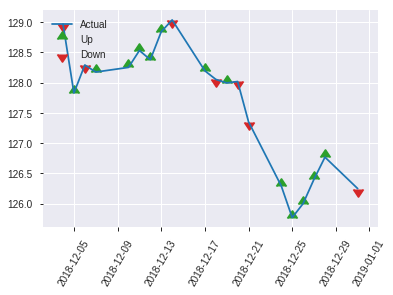


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15852898801638196
RMSE: 0.39815698915927866
LogLoss: 0.47877481964489566
Mean Per-Class Error: 0.19981684981684977
AUC: 0.8614774114774115
pr_auc: 0.8671150638790851
Gini: 0.722954822954823
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6236674785614014: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      109  21   0.1615   (21.0/130.0)
1      30   96   0.2381   (30.0/126.0)
Total  139  117  0.1992   (51.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.623667     0.790123  116
max f2                       0.306161     0.873926  193
max f0point5                 0.623667     0.808081  116
max accuracy                 0.623667     0.800781  116
max precision                0.975092     1         0
max recall                   0.0646209    1         251
max specificity              0.975092     1         0
max absolute_mcc             0.623667     0.602522  116
max min_per_class_accuracy   0.594266     0.784615  126
max mean_per_class_accuracy  0.623667     0.800183  116

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 55.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.960254           2.03175    2.03175            1                0.969385   1                           0.969385            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.953902           2.03175    2.03175            1                0.955322   1                           0.962354            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.949715           2.03175    2.03175            1                0.95051    1                           0.959393            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.943301           2.03175    2.03175            1                0.94615    1                           0.955781            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.937853           2.03175    2.03175            1                0.941043   1                           0.953514            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.919035           2.03175    2.03175            1                0.93091    1                           0.942212            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.898604           2.03175    2.03175            1                0.909941   1                           0.931455            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.86588            1.87546    1.99267            0.923077         0.87783    0.980769                    0.918049            0.0952381       0.404762                   87.5458   99.2674
    9        0.300781                    0.722844           1.21905    1.7415             0.6              0.769585   0.857143                    0.869846            0.119048        0.52381                    21.9048   74.1497
    10       0.402344                    0.648197           1.48474    1.67668            0.730769         0.686245   0.825243                    0.8235              0.150794        0.674603                   48.4737   67.6684
    11       0.5                         0.585464           1.21905    1.5873             0.6              0.621064   0.78125                     0.783962            0.119048        0.793651                   21.9048   58.7302
    12       0.601562                    0.507463           0.547009   1.41167            0.269231         0.54597    0.694805                    0.743782            0.0555556       0.849206                   -45.2991  41.1668
    13       0.699219                    0.410212           0.731429   1.31666            0.36             0.464327   0.648045                    0.704752            0.0714286       0.920635                   -26.8571  31.6662
    14       0.800781                    0.230414           0.468864   1.20914            0.230769         0.326341   0.595122                    0.656758            0.047619        0.968254                   -53.1136  20.9137
    15       0.898438                    0.147626           0.0812698  1.08654            0.04             0.185268   0.534783                    0.605509            0.00793651      0.97619                    -91.873   8.65424
    16       1                           0.0497215          0.234432   1                  0.115385         0.0911059  0.492188 

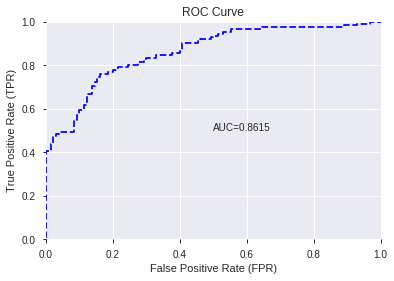

This function is available for GLM models only


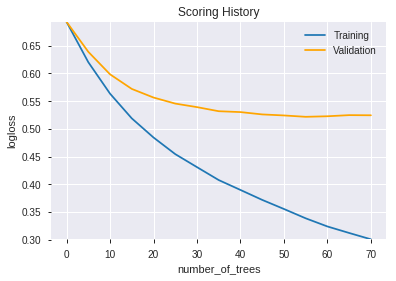

--2019-08-22 15:54:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(Shared

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_155245_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_155245_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_155414_model_9  0.840537  0.500096              0.277900  0.409694  0.167849
1  DeepLearning_grid_1_AutoML_20190822_155414_model_6  0.835592  0.503848              0.293162  0.412677  0.170302
2  DeepLearning_grid_1_AutoML_20190822_155414_model_8  0.820208  0.505201              0.298107  0.417406  0.174227
3  DeepLearning_grid_1_AutoML_20190822_155414_model_5  0.819231  0.516354              0.290049  0.418677  0.175290
4  DeepLearning_grid_1_AutoML_20190822_155414_model_2  0.798535  0.531391              0.294750  0.427692  0.182920
5  DeepLearning_grid_1_AutoML_20190822_155414_model_4  0.790232  0.628349              0.347131  0.439401  0.193073
6  DeepLearning_grid_1_AutoML_20190822_155414_model_3  0.781929  0.575913              0.361783  0.444999  0.198024
7               DeepLearning_1_AutoML_20190822_155414  0.778999  0.567672              0.299206  0.445243  0.198242
8  DeepLearning_grid_1_AutoML_20190822_155414_model_7  0.759707  0.580702              0.362027  0.444030  0.197163
9  DeepLearning_grid_1_AutoML_20190822_155414_model_1  0.737729  0.741428              0.310989  0.483286  0.233565

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.000000           1.000000    0.038901
1    CDLGRAVESTONEDOJI             0.968574           0.968574    0.037678
2            CDLTAKURI             0.899211           0.899211    0.034980
3     CDLDRAGONFLYDOJI             0.831335           0.831335    0.032339
4   CDLCLOSINGMARUBOZU             0.713772           0.713772    0.027766
5             WILLR_12             0.695169           0.695169    0.027043
6         STOCHF_fastk             0.634621           0.634621    0.024687
7    CDLINVERTEDHAMMER             0.591727           0.591727    0.023019
8        CDLHANGINGMAN             0.573718           0.573718    0.022318
9               ULTOSC             0.557002           0.557002    0.021668
10           PLUS_DI_8             0.531373           0.531373    0.020671
11              CCI_14             0.521487           0.521487    0.020286
12             WILLR_8             0.517240           0.517240    0.020121
13                SINH             0.514524           0.514524    0.020015
14     CDLHOMINGPIGEON             0.501126           0.501126    0.019494
15                COSH             0.499331           0.499331    0.019424
16        HT_TRENDMODE             0.498518           0.498518    0.019393
17  CDLSEPARATINGLINES             0.490509           0.490509    0.019081
18      CDLMORNINGSTAR             0.489598           0.489598    0.019046
19     CDLLADDERBOTTOM             0.483564           0.483564    0.018811
20   CDLSTALLEDPATTERN             0.481014           0.481014    0.018712
21                 EXP             0.477585           0.477585    0.018578
22      CDLEVENINGSTAR             0.477395           0.477395    0.018571
23   CDLDARKCLOUDCOVER             0.474621           0.474621    0.018463
24     CDLSHOOTINGSTAR             0.471918           0.471918    0.018358
25           CDLONNECK             0.471014           0.471014    0.018323
26        CDLTHRUSTING             0.468191           0.468191    0.018213
27  CDLEVENINGDOJISTAR             0.467133           0.467133    0.018172
28      CDL3LINESTRIKE             0.466330           0.466330    0.018141
29     CDLADVANCEBLOCK             0.464459           0.464459    0.018068
30         MINUS_DI_12             0.464051           0.464051    0.018052
31     CDLUNIQUE3RIVER             0.451151           0.451151    0.017550
32        CDLTASUKIGAP             0.450106           0.450106    0.017509
33                 SIN             0.444348           0.444348    0.017285
34  CDLMORNINGDOJISTAR             0.443461           0.443461    0.017251
35      is_month_start             0.436031           0.436031    0.016962
36          PLUS_DI_12             0.434538           0.434538    0.016904
37    is_quarter_start             0.427509           0.427509    0.016630
38          weekofyear             0.424346           0.424346    0.016507
39      CDLMATCHINGLOW             0.422833           0.422833    0.016448
40           CDLHAMMER             0.422746           0.422746    0.016445
41          aroonup_30             0.420691           0.420691    0.016365
42      is_quarter_end             0.419394           0.419394    0.016315
43             quarter             0.417752           0.417752    0.016251
44        is_month_end             0.412210           0.412210    0.016035
45         CDL3OUTSIDE             0.408863           0.408863    0.015905
46                week             0.407481           0.407481    0.015851
47               month             0.395396           0.395396    0.015381
48      CDLHARAMICROSS             0.386103           0.386103    0.015020
49           dayofyear             0.385455           0.385455    0.014994

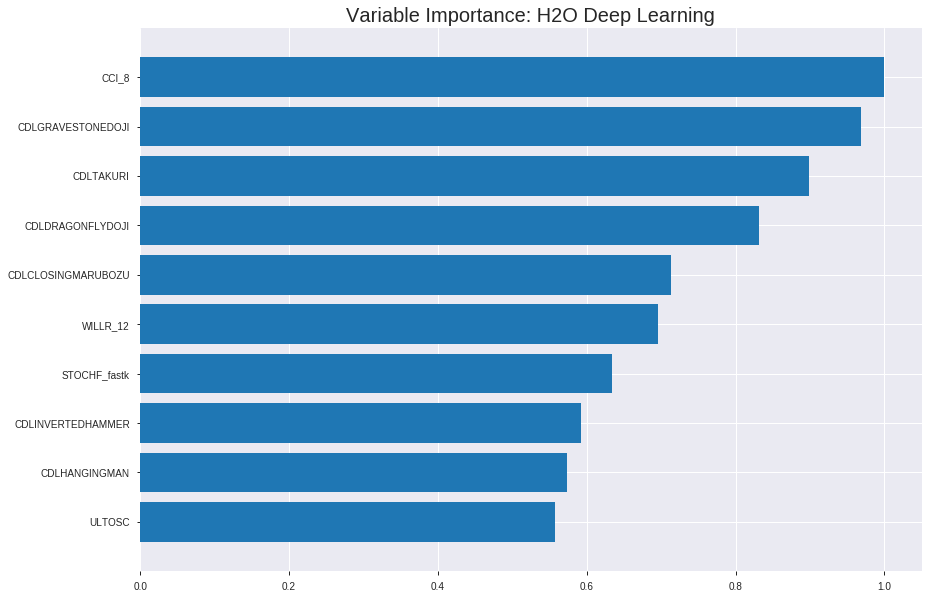

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_155414_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1848589559098879
RMSE: 0.42995227166499295
LogLoss: 0.5419928976083765
Mean Per-Class Error: 0.27976571886263524
AUC: 0.8012220915098117
pr_auc: 0.8104812585174974
Gini: 0.6024441830196234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4810322094092679: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      504  376   0.4273   (376.0/880.0)
1      145  763   0.1597   (145.0/908.0)
Total  649  1139  0.2914   (521.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481032     0.745481  232
max f2                       0.112429     0.859737  352
max f0point5                 0.538722     0.737661  176
max accuracy                 0.497254     0.721477  217
max precision                0.972358     1         0
max recall                   0.0666343    1         385
max specificity              0.972358     1         0
max absolute_mcc             0.497254     0.446577  217
max min_per_class_accuracy   0.514983     0.713636  199
max mean_per_class_accuracy  0.497254     0.720234  217

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100671                   0.967649           1.96916   1.96916            1                0.969821   1                           0.969821            0.0198238       0.0198238                  96.9163    96.9163
    2        0.0201342                   0.963366           1.96916   1.96916            1                0.965802   1                           0.967812            0.0198238       0.0396476                  96.9163    96.9163
    3        0.0302013                   0.960353           1.85977   1.9327             0.944444         0.962018   0.981481                    0.965881            0.0187225       0.05837                    85.9765    93.2697
    4        0.0402685                   0.957531           1.96916   1.94181            1                0.95908    0.986111                    0.96418             0.0198238       0.0781938                  96.9163    94.1814
    5        0.0503356                   0.95401            1.96916   1.94728            1                0.955716   0.988889                    0.962488            0.0198238       0.0980176                  96.9163    94.7283
    6        0.100112                    0.92259            1.81429   1.88116            0.921348         0.941714   0.955307                    0.952159            0.0903084       0.188326                   81.4285    88.1156
    7        0.150447                    0.739796           1.77225   1.84472            0.9              0.850595   0.936803                    0.918178            0.089207        0.277533                   77.2247    84.4718
    8        0.200224                    0.630177           1.52665   1.76565            0.775281         0.673221   0.896648                    0.857281            0.0759912       0.353524                   52.6654    76.5646
    9        0.300336                    0.560899           1.2651    1.5988             0.642458         0.59191    0.811918                    0.768824            0.126652        0.480176                   26.5105    59.8799
    10       0.399888                    0.536629           1.28327   1.52025            0.651685         0.548251   0.772028                    0.713912            0.127753        0.60793                    28.3275    52.0249
    11       0.5                         0.514891           1.03409   1.42291            0.52514          0.526102   0.722595                    0.676308            0.103524        0.711454                   3.40856    42.2907
    12       0.600112                    0.49264            0.990082  1.3507             0.502793         0.505342   0.685927                    0.647787            0.0991189       0.810573                   -0.991805  35.0703
    13       0.699664                    0.454242           0.752265  1.26555            0.382022         0.475016   0.642686                    0.623204            0.0748899       0.885463                   -24.7735   26.5553
    14       0.799776                    0.364514           0.594049  1.1815             0.301676         0.420102   0.6                         0.597781            0.0594714       0.944934                   -40.5951   18.1498
    15       0.899888                    0.0976024          0.396033  1.09412            0.201117         0.196951   0.555625                    0.553189            0.0396476       0.984581                   -60.3967   9.41154
    16       1                           0.0105887          0.154013  1                  0.0782123        0.0755925  0.50783   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18037650724285348
RMSE: 0.4247075549632399
LogLoss: 0.5352645647340721
Mean Per-Class Error: 0.24915693307581477
AUC: 0.8180048438026917
pr_auc: 0.8259353870722811
Gini: 0.6360096876053833
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49898592195591557: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  91   0.3655   (91.0/249.0)
1      43   219  0.1641   (43.0/262.0)
Total  201  310  0.2622   (134.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498986     0.765734  238
max f2                       0.265594     0.85656   334
max f0point5                 0.5661       0.782241  146
max accuracy                 0.531161     0.749511  191
max precision                0.976336     1         0
max recall                   0.0382948    1         399
max specificity              0.976336     1         0
max absolute_mcc             0.536961     0.504074  181
max min_per_class_accuracy   0.522814     0.744275  205
max mean_per_class_accuracy  0.531161     0.750843  191

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.968938           1.62532   1.62532            0.833333         0.970974   0.833333                    0.970974            0.019084        0.019084                   62.5318   62.5318
    2        0.0215264                   0.966436           1.95038   1.77307            1                0.967157   0.909091                    0.969239            0.019084        0.0381679                  95.0382   77.3074
    3        0.0313112                   0.965387           1.95038   1.82848            1                0.966107   0.9375                      0.96826             0.019084        0.0572519                  95.0382   82.8483
    4        0.0410959                   0.96236            1.95038   1.85751            1                0.963553   0.952381                    0.96714             0.019084        0.0763359                  95.0382   85.7506
    5        0.0508806                   0.959357           1.95038   1.87537            1                0.961541   0.961538                    0.966063            0.019084        0.0954198                  95.0382   87.5367
    6        0.101761                    0.947116           1.87537   1.87537            0.961538         0.952361   0.961538                    0.959212            0.0954198       0.19084                    87.5367   87.5367
    7        0.150685                    0.905384           1.71634   1.82373            0.88             0.932364   0.935065                    0.950495            0.0839695       0.274809                   71.6336   82.3734
    8        0.201566                    0.69446            1.80035   1.81783            0.923077         0.811395   0.932039                    0.915382            0.0916031       0.366412                   80.0352   81.7831
    9        0.30137                     0.575719           1.45323   1.69709            0.745098         0.615792   0.87013                     0.816167            0.145038        0.51145                    45.3226   69.7085
    10       0.401174                    0.545692           1.22377   1.57933            0.627451         0.559685   0.809756                    0.752359            0.122137        0.633588                   22.3769   57.9333
    11       0.500978                    0.522868           1.0708    1.47802            0.54902          0.532317   0.757812                    0.708523            0.10687         0.740458                   7.07978   47.8024
    12       0.600783                    0.49969            0.879584  1.37861            0.45098          0.511893   0.70684                     0.675858            0.0877863       0.828244                   -12.0416  37.8609
    13       0.700587                    0.464293           0.535399  1.25849            0.27451          0.486809   0.645251                    0.648926            0.0534351       0.881679                   -46.4601  25.8487
    14       0.800391                    0.351068           0.573642  1.17309            0.294118         0.416014   0.601467                    0.619883            0.0572519       0.938931                   -42.6358  17.309
    15       0.900196                    0.0910807          0.382428  1.08543            0.196078         0.167004   0.556522                    0.569673            0.0381679       0.977099                   -61.7572  8.54298
    16       1                           0.0382948          0.229457  1                  0.117647         0.0717891  0.51272                     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:02:02  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:02:04  3 min  7.894 sec  442 obs/sec       0.471477  1             843        0.57244          1.08802             -0.31107       0.757933        0.768186           1.96916          0.326622                         0.543783           0.988157              -0.183566        0.795227          0.814583             1.95038            0.303327
    2019-08-22 16:02:16  3 min 19.778 sec  674 obs/sec       4.77181   10            8532       0.442073         0.567601            0.218095       0.776855        0.79129            1.96916          0.337248                         0.429036           0.542934              0.263237         0.820933          0.834379             1.95038            0.272016
    2019-08-22 16:02:28  3 min 32.020 sec  787 obs/sec       10.4346   22            18657      0.43862          0.560807            0.230262       0.781783        0.788959           1.85977          0.323266                         0.42683            0.538905              0.270794         0.814571          0.823531             1.95038            0.258317
    2019-08-22 16:02:41  3 min 44.762 sec  862 obs/sec       17.0157   36            30424      0.439271         0.562314            0.227976       0.793833        0.794793           1.75037          0.310403                         0.431372           0.545459              0.255192         0.820281          0.828432             1.95038            0.258317
    2019-08-22 16:02:52  3 min 56.690 sec  917 obs/sec       23.6012   50            42199      0.429952         0.541993            0.260383       0.801222        0.810481           1.96916          0.291387                         0.424708           0.535265              0.278027         0.818005          0.825935             1.62532            0.262231
    2019-08-22 16:03:05  4 min  8.883 sec  959 obs/sec       30.6057   65            54723      0.43385          0.550079            0.24691        0.79906         0.810699           1.96916          0.306488                         0.430954           0.545099              0.256635         0.807413          0.81764              1.62532            0.277886
    2019-08-22 16:03:16  4 min 20.739 sec  996 obs/sec       37.736    80            67472      0.432919         0.547359            0.250142       0.803554        0.811954           1.96916          0.295861                         0.435591           0.559127              0.24055          0.806784          0.819268             1.95038            0.254403
    2019-08-22 16:03:18  4 min 21.928 sec  995 obs/sec       37.736    80            67472      0.429952         0.541993            0.260383       0.801222        0.810481           1.96916          0.291387                         0.424708           0.535265              0.278027         0.818005          0.825935             1.62532            0.262231

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CCI_8               1.0                    1.0                  0.03890063134747205
CDLGRAVESTONEDOJI   0.9685739874839783     0.9685739874839783   0.03767813961986524
CDLTAKURI           0.8992111682891846     0.8992111682891846   0.03497988216114722
CDLDRAGONFLYDOJI    0.831335186958313      0.831335186958313    0.032339463634047085
CDLCLOSINGMARUBOZU  0.7137717008590698     0.7137717008590698   0.027766169801376774
---                 ---                    ---                  ---
CDL3OUTSIDE         0.4088625907897949     0.4088625907897949   0.015905012916086134
week                0.40748053789138794    0.40748053789138794  0.015851250185782498
month               0.39539551734924316    0.39539551734924316  0.015381135256845896
CDLHARAMICROSS      0.3861027956008911     0.3861027956008911   0.015019642513898618
dayofyear           0.3854552209377289     0.3854552209377289   0.01499445145065698


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76171875)

('F1', 0.7662337662337663)

('auc', 0.8405372405372405)

('logloss', 0.5000959003213125)

('mean_per_class_error', 0.2381562881562882)

('rmse', 0.4096937536843825)

('mse', 0.16784897180799946)

deeplearning prediction progress: |███████████████████████████████████████| 100%


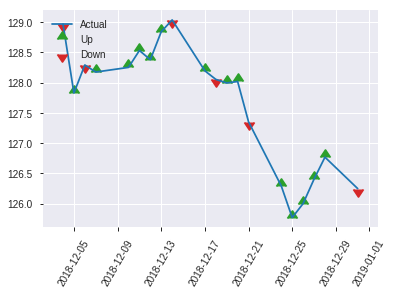


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16784897180799946
RMSE: 0.4096937536843825
LogLoss: 0.5000959003213125
Mean Per-Class Error: 0.2381562881562882
AUC: 0.8405372405372405
pr_auc: 0.8457325029332117
Gini: 0.6810744810744811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.442530771357521: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   64   0.4923   (64.0/130.0)
1      8    118  0.0635   (8.0/126.0)
Total  74   182  0.2812   (72.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442531     0.766234  181
max f2                       0.442531     0.860058  181
max f0point5                 0.565335     0.812808  69
max accuracy                 0.542605     0.761719  88
max precision                0.969589     1         0
max recall                   0.0713944    1         248
max specificity              0.969589     1         0
max absolute_mcc             0.565335     0.553011  69
max min_per_class_accuracy   0.51104      0.761538  126
max mean_per_class_accuracy  0.508549     0.761844  128

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.968331           2.03175   2.03175            1                0.969181  1                           0.969181            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.966391           2.03175   2.03175            1                0.966968  1                           0.968074            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.962921           2.03175   2.03175            1                0.965387  1                           0.967403            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.955672           2.03175   2.03175            1                0.959623  1                           0.965281            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.953597           2.03175   2.03175            1                0.954599  1                           0.963637            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.944286           1.87546   1.9536             0.923077         0.948709  0.961538                    0.956173            0.0952381       0.198413                   87.5458   95.3602
    7        0.152344                    0.902396           2.03175   1.97965            1                0.927516  0.974359                    0.946621            0.103175        0.301587                   103.175   97.965
    8        0.203125                    0.757091           1.87546   1.9536             0.923077         0.845159  0.961538                    0.921255            0.0952381       0.396825                   87.5458   95.3602
    9        0.300781                    0.55167            1.46286   1.79427            0.72             0.596584  0.883117                    0.815843            0.142857        0.539683                   46.2857   79.4269
    10       0.402344                    0.534457           1.25031   1.65696            0.615385         0.541512  0.815534                    0.746594            0.126984        0.666667                   25.0305   65.6958
    11       0.5                         0.50902            0.975238  1.52381            0.48             0.52016   0.75                        0.702369            0.0952381       0.761905                   -2.47619  52.381
    12       0.601562                    0.489732           0.468864  1.3457             0.230769         0.499144  0.662338                    0.668058            0.047619        0.809524                   -53.1136  34.5702
    13       0.699219                    0.44532            1.05651   1.30531            0.52             0.469343  0.642458                    0.640305            0.103175        0.912698                   5.65079   30.5312
    14       0.800781                    0.352712           0.468864  1.19923            0.230769         0.402388  0.590244                    0.61013             0.047619        0.960317                   -53.1136  19.9226
    15       0.898438                    0.109685           0.24381   1.09538            0.12             0.219129  0.53913                     0.56763             0.0238095       0.984127                   -75.619   9.53761
    16       1                           0.0507702          0.156288  1                  0.0769231        0.084412  0.492188                    0.518553           

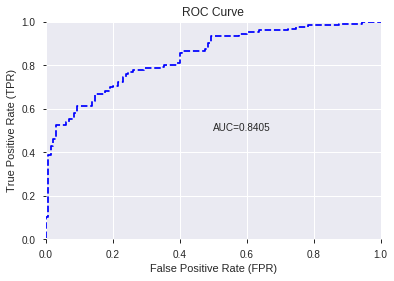

This function is available for GLM models only


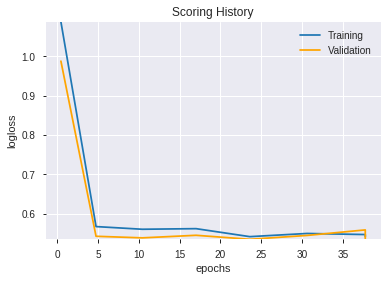

--2019-08-22 16:03:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_155414_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_155414_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'STOCHF_fastk',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'ULTOSC',
 'PLUS_DI_8',
 'CCI_14',
 'WILLR_8',
 'SINH',
 'CDLHOMINGPIGEON',
 'COSH',
 'HT_TRENDMODE',
 'CDLSEPARATINGLINES',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'EXP',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'CDLONNECK',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLADVANCEBLOCK',
 'MINUS_DI_12',
 'CDLUNIQUE3RIVER',
 'CDLTASUKIGAP',
 'SIN',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'PLUS_DI_12',
 'is_quarter_start',
 'weekofyear',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'aroonup_30',
 'is_quarter_end',
 'quarter',
 'is_month_end',
 'CDL3OUTSIDE',
 'week',
 'month',
 'CDLHARAMICROSS',
 'dayofyear']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_160334_model_1  0.840598  0.488238              0.281746  0.404412  0.163549

variable  relative_importance  scaled_importance  percentage
0                CCI_8             0.817792           1.000000    0.133233
1    CDLGRAVESTONEDOJI             0.558697           0.683177    0.091022
2             WILLR_12             0.485396           0.593545    0.079080
3         STOCHF_fastk             0.387458           0.473785    0.063124
4            PLUS_DI_8             0.363354           0.444311    0.059197
5            CDLTAKURI             0.325607           0.398153    0.053047
6              WILLR_8             0.272519           0.333238    0.044398
7               CCI_14             0.229840           0.281049    0.037445
8     CDLDRAGONFLYDOJI             0.213178           0.260675    0.034731
9           PLUS_DI_12             0.199465           0.243907    0.032496
10   CDLINVERTEDHAMMER             0.183395           0.224256    0.029878
11  CDLCLOSINGMARUBOZU             0.155422           0.190051    0.025321
12           dayofyear             0.143811           0.175853    0.023429
13   CDLSTALLEDPATTERN             0.138477           0.169331    0.022560
14       CDLHANGINGMAN             0.132854           0.162455    0.021644
15  CDLSEPARATINGLINES             0.090913           0.111169    0.014811
16        CDLTHRUSTING             0.087798           0.107360    0.014304
17     CDLUNIQUE3RIVER             0.078399           0.095866    0.012773
18      CDL3LINESTRIKE             0.078189           0.095610    0.012738
19      CDLMORNINGSTAR             0.074362           0.090930    0.012115
20              ULTOSC             0.073861           0.090318    0.012033
21  CDLMORNINGDOJISTAR             0.068519           0.083785    0.011163
22     CDLLADDERBOTTOM             0.058622           0.071683    0.009551
23           CDLONNECK             0.058145           0.071100    0.009473
24         MINUS_DI_12             0.055034           0.067295    0.008966
25          aroonup_30             0.053793           0.065779    0.008764
26             quarter             0.052075           0.063678    0.008484
27  CDLEVENINGDOJISTAR             0.051480           0.062950    0.008387
28                week             0.047993           0.058686    0.007819
29               month             0.046803           0.057231    0.007625
30          weekofyear             0.046585           0.056965    0.007590
31           CDLHAMMER             0.045030           0.055063    0.007336
32                COSH             0.043516           0.053211    0.007089
33                SINH             0.043361           0.053022    0.007064
34                 EXP             0.043301           0.052949    0.007055
35      CDLHARAMICROSS             0.042820           0.052360    0.006976
36      CDLEVENINGSTAR             0.042803           0.052340    0.006973
37   CDLDARKCLOUDCOVER             0.037531           0.045893    0.006114
38                 SIN             0.032959           0.040303    0.005370
39      is_month_start             0.029932           0.036601    0.004876
40         CDL3OUTSIDE             0.025376           0.031029    0.004134
41      CDLMATCHINGLOW             0.023581           0.028835    0.003842
42     CDLSHOOTINGSTAR             0.022466           0.027471    0.003660
43      is_quarter_end             0.019609           0.023978    0.003195
44        HT_TRENDMODE             0.016372           0.020019    0.002667
45        is_month_end             0.012687           0.015514    0.002067
46     CDLHOMINGPIGEON             0.009888           0.012090    0.001611
47     CDLADVANCEBLOCK             0.006503           0.007952    0.001059
48    is_quarter_start             0.005759           0.007042    0.000938
49        CDLTASUKIGAP             0.004728           0.005781    0.000770

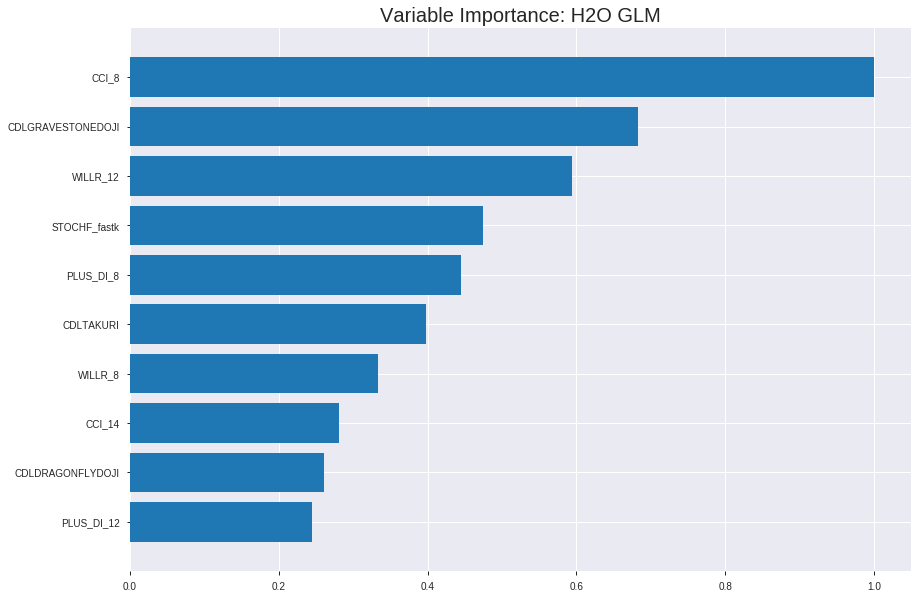

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_160334_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18102636158990973
RMSE: 0.4254719280868125
LogLoss: 0.5319107217243804
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2478.2558210117336
Residual deviance: 1902.112740886384
AIC: 2004.112740886384
AUC: 0.8031938325991189
pr_auc: 0.8124305763940732
Gini: 0.6063876651982378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44464410320600994: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      507  373   0.4239   (373.0/880.0)
1      136  772   0.1498   (136.0/908.0)
Total  643  1145  0.2847   (509.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444644     0.75207   236
max f2                       0.168402     0.86007   337
max f0point5                 0.52346      0.731908  187
max accuracy                 0.517912     0.722595  191
max precision                0.996117     1         0
max recall                   0.0333713    1         390
max specificity              0.996117     1         0
max absolute_mcc             0.517912     0.446237  191
max min_per_class_accuracy   0.505812     0.717045  198
max mean_per_class_accuracy  0.517912     0.722965  191

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.979413           1.96916    1.96916            1                0.985169   1                           0.985169            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.969575           1.96916    1.96916            1                0.973075   1                           0.979122            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.965014           1.85977    1.9327             0.944444         0.967785   0.981481                    0.975343            0.0187225       0.05837                    85.9765   93.2697
    4        0.0402685                   0.95885            1.96916    1.94181            1                0.96218    0.986111                    0.972052            0.0198238       0.0781938                  96.9163   94.1814
    5        0.0503356                   0.952438           1.96916    1.94728            1                0.955737   0.988889                    0.968789            0.0198238       0.0980176                  96.9163   94.7283
    6        0.100112                    0.911388           1.90279    1.92516            0.966292         0.93423    0.977654                    0.951606            0.0947137       0.192731                   90.2787   92.5159
    7        0.150447                    0.786719           1.61909    1.82276            0.822222         0.8526     0.925651                    0.918481            0.0814978       0.274229                   61.909    82.2757
    8        0.200224                    0.691167           1.4824     1.73814            0.752809         0.728577   0.882682                    0.87127             0.0737885       0.348018                   48.2404   73.8144
    9        0.300336                    0.607456           1.38611    1.6208             0.703911         0.645071   0.823091                    0.795871            0.138767        0.486784                   38.6115   62.0801
    10       0.399888                    0.556615           1.16158    1.50648            0.589888         0.58294    0.765035                    0.742861            0.115639        0.602423                   16.1585   50.6479
    11       0.5                         0.507968           1.14409    1.43392            0.581006         0.532164   0.728188                    0.700675            0.114537        0.71696                    14.4095   43.3921
    12       0.600112                    0.468174           0.957079   1.35437            0.486034         0.487045   0.687791                    0.665037            0.095815        0.812775                   -4.29208  35.4373
    13       0.699664                    0.410571           0.752265   1.2687             0.382022         0.439656   0.644285                    0.632968            0.0748899       0.887665                   -24.7735  26.8701
    14       0.799776                    0.322142           0.583048   1.18287            0.296089         0.371817   0.600699                    0.600278            0.05837         0.946035                   -41.6952  18.2875
    15       0.899888                    0.114562           0.440036   1.10023            0.223464         0.204738   0.558732                    0.556275            0.0440529       0.990088                   -55.9964  10.0235
    16       1                           0.0029258          0.0990082  1                  0.0502793        0.0723667  0.50783  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17188208526241544
RMSE: 0.4145866438543522
LogLoss: 0.5190925374047911
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.1145564513349
Residual deviance: 530.5125732276965
AIC: 632.5125732276965
AUC: 0.8340001226279162
pr_auc: 0.845390229622337
Gini: 0.6680002452558325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46100081058407333: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  96   0.3855   (96.0/249.0)
1      30   232  0.1145   (30.0/262.0)
Total  183  328  0.2466   (126.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461001     0.786441  248
max f2                       0.101555     0.855438  360
max f0point5                 0.634592     0.788591  127
max accuracy                 0.468011     0.753425  245
max precision                0.989204     1         0
max recall                   0.0123652    1         399
max specificity              0.989204     1         0
max absolute_mcc             0.461001     0.521216  248
max min_per_class_accuracy   0.533235     0.744275  200
max mean_per_class_accuracy  0.57549      0.754047  166

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 52.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.976711           1.95038   1.95038            1                0.983425   1                           0.983425            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.970215           1.95038   1.95038            1                0.972843   1                           0.978615            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.962031           1.95038   1.95038            1                0.965071   1                           0.974383            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.956608           1.95038   1.95038            1                0.958344   1                           0.970564            0.019084        0.0801527                  95.0382   95.0382
    5        0.0508806                   0.951379           1.56031   1.87537            0.8              0.954018   0.961538                    0.967382            0.0152672       0.0954198                  56.0305   87.5367
    6        0.101761                    0.920969           1.95038   1.91287            1                0.936241   0.980769                    0.951811            0.0992366       0.194656                   95.0382   91.2874
    7        0.150685                    0.881173           1.63832   1.82373            0.84             0.904197   0.935065                    0.936352            0.0801527       0.274809                   63.8321   82.3734
    8        0.201566                    0.773527           1.72534   1.7989             0.884615         0.829694   0.92233                     0.909429            0.0877863       0.362595                   72.5338   79.8896
    9        0.30137                     0.639732           1.6062    1.73508            0.823529         0.692115   0.88961                     0.837461            0.160305        0.522901                   60.6197   73.508
    10       0.401174                    0.57636            1.22377   1.60788            0.627451         0.606135   0.82439                     0.779912            0.122137        0.645038                   22.3769   60.7876
    11       0.500978                    0.534526           0.917827  1.4704             0.470588         0.552018   0.753906                    0.734511            0.0916031       0.736641                   -8.21733  47.0405
    12       0.600783                    0.483269           1.03256   1.39767            0.529412         0.511251   0.716612                    0.697422            0.103053        0.839695                   3.2555    39.7668
    13       0.700587                    0.423074           0.68837   1.29662            0.352941         0.456219   0.664804                    0.663061            0.0687023       0.908397                   -31.163   29.6622
    14       0.800391                    0.301688           0.305942  1.17309            0.156863         0.375423   0.601467                    0.627194            0.0305344       0.938931                   -69.4058  17.309
    15       0.900196                    0.101555           0.458913  1.09391            0.235294         0.191303   0.56087                     0.578867            0.0458015       0.984733                   -54.1087  9.39097
    16       1                           0.0123652          0.152971  1                  0.0784314        0.0650881  0.51272                     0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:03:34  0.000 sec   2            .17E2     50            1.3686620271433747  1.3660446183258614
     2019-08-22 16:03:34  0.009 sec   4            .11E2     51            1.3590277656267968  1.355133932538674
     2019-08-22 16:03:34  0.018 sec   6            .66E1     51            1.34485572915736    1.3390936397932909
     2019-08-22 16:03:34  0.028 sec   8            .41E1     51            1.3249994715647713  1.3166285957985355
     2019-08-22 16:03:34  0.037 sec   10           .25E1     51            1.2989443734703945  1.2871950297960864
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:03:34  0.156 sec   36           .52E-2    51            1.0607876770107745  1.038510528314765
     2019-08-22 16:03:34  0.167 sec   38           .32E-2    51            1.0586319822525265  1.0402806278611332
     2019-08-22 16:03:34  0.179 sec   40           .2E-2     51            1.0570186932576022  1.04300298960256
     2019-08-22 16:03:34  0.188 sec   42           .12E-2    51            1.0557907997212457  1.0463776782251664
     2019-08-22 16:03:34  0.198 sec   44           .77E-3    51            1.054880471992866   1.0502238801772739


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7578125)

('F1', 0.7637540453074435)

('auc', 0.8405982905982905)

('logloss', 0.48823791938438216)

('mean_per_class_error', 0.24224664224664227)

('rmse', 0.40441198521901633)

('mse', 0.16354905378878587)

glm prediction progress: |████████████████████████████████████████████████| 100%


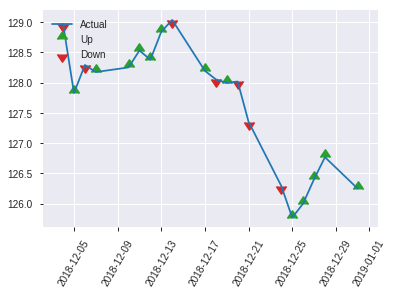


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16354905378878587
RMSE: 0.40441198521901633
LogLoss: 0.48823791938438216
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 355.07943398521934
Residual deviance: 249.97781472480366
AIC: 351.9778147248037
AUC: 0.8405982905982905
pr_auc: 0.851080764050168
Gini: 0.681196581196581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4097781776174753: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   65   0.5      (65.0/130.0)
1      8    118  0.0635   (8.0/126.0)
Total  73   183  0.2852   (73.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409778     0.763754  182
max f2                       0.317603     0.860367  204
max f0point5                 0.629598     0.786802  66
max accuracy                 0.518229     0.757812  119
max precision                0.995788     1         0
max recall                   0.0708606    1         243
max specificity              0.995788     1         0
max absolute_mcc             0.629598     0.515898  66
max min_per_class_accuracy   0.505335     0.753968  125
max mean_per_class_accuracy  0.505335     0.757753  125

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.972092           2.03175    2.03175            1                0.982683   1                           0.982683            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.962908           2.03175    2.03175            1                0.966828   1                           0.974755            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.95845            2.03175    2.03175            1                0.96004    1                           0.971077            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.950104           2.03175    2.03175            1                0.95307    1                           0.966166            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.948968           2.03175    2.03175            1                0.949782   1                           0.963645            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.926333           2.03175    2.03175            1                0.940682   1                           0.952164            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.890373           2.03175    2.03175            1                0.911529   1                           0.938619            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.757452           1.87546    1.99267            0.923077         0.831618   0.980769                    0.911869            0.0952381       0.404762                   87.5458   99.2674
    9        0.300781                    0.598711           1.21905    1.7415             0.6              0.647421   0.857143                    0.826009            0.119048        0.52381                    21.9048   74.1497
    10       0.402344                    0.547911           1.17216    1.59778            0.576923         0.570436   0.786408                    0.761496            0.119048        0.642857                   17.2161   59.7781
    11       0.5                         0.501121           1.13778    1.50794            0.56             0.524388   0.742188                    0.715186            0.111111        0.753968                   13.7778   50.7937
    12       0.601562                    0.472194           0.781441   1.38528            0.384615         0.485497   0.681818                    0.676407            0.0793651       0.833333                   -21.8559  38.5281
    13       0.699219                    0.416635           0.812698   1.30531            0.4              0.447648   0.642458                    0.644457            0.0793651       0.912698                   -18.7302  30.5312
    14       0.800781                    0.317603           0.547009   1.20914            0.269231         0.370442   0.595122                    0.609704            0.0555556       0.968254                   -45.2991  20.9137
    15       0.898438                    0.119408           0.0812698  1.08654            0.04             0.199596   0.534783                    0.565127            0.00793651      0.97619                    -91.873   8.65424
    16       1                           0.039648           0.234432   1                  0.115385         0.0755912  0.492188 

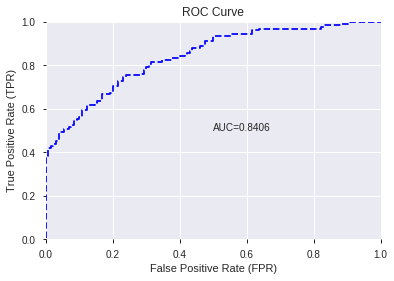

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


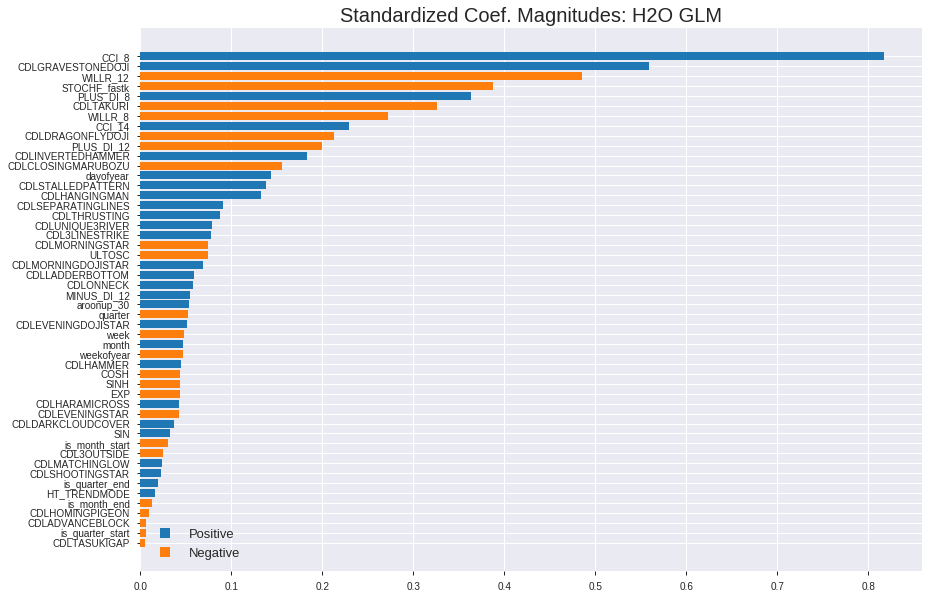

'log_likelihood'
--2019-08-22 16:03:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_160334_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_160334_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'WILLR_12',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'CDLTAKURI',
 'WILLR_8',
 'CCI_14',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_12',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'dayofyear',
 'CDLSTALLEDPATTERN',
 'CDLHANGINGMAN',
 'CDLSEPARATINGLINES',
 'CDLTHRUSTING',
 'CDLUNIQUE3RIVER',
 'CDL3LINESTRIKE',
 'CDLMORNINGSTAR',
 'ULTOSC',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'MINUS_DI_12',
 'aroonup_30',
 'quarter',
 'CDLEVENINGDOJISTAR',
 'week',
 'month',
 'weekofyear',
 'CDLHAMMER',
 'COSH',
 'SINH',
 'EXP',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'SIN',
 'is_month_start',
 'CDL3OUTSIDE',
 'CDLMATCHINGLOW',
 'CDLSHOOTINGSTAR',
 'is_quarter_end',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'is_quarter_start',
 'CDLTASUKIGAP']

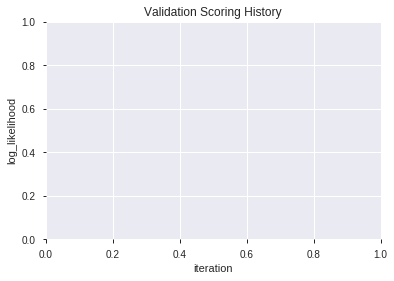

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_160346_model_5  0.855617  0.475742              0.228632  0.395696  0.156576
1               XGBoost_1_AutoML_20190822_160346  0.840781  0.488638              0.262759  0.404040  0.163248
2  XGBoost_grid_1_AutoML_20190822_160346_model_4  0.840598  0.498077              0.259035  0.406732  0.165431
3  XGBoost_grid_1_AutoML_20190822_160346_model_7  0.839805  0.489856              0.270574  0.404544  0.163656
4  XGBoost_grid_1_AutoML_20190822_160346_model_6  0.836630  0.493955              0.289438  0.406432  0.165187
5               XGBoost_2_AutoML_20190822_160346  0.835531  0.500047              0.252076  0.408891  0.167192
6  XGBoost_grid_1_AutoML_20190822_160346_model_2  0.831929  0.503481              0.277900  0.410908  0.168846
7  XGBoost_grid_1_AutoML_20190822_160346_model_1  0.831624  0.501839              0.249328  0.409946  0.168056
8  XGBoost_grid_1_AutoML_20190822_160346_model_3  0.829182  0.506922              0.270818  0.412652  0.170282
9               XGBoost_3_AutoML_20190822_160346  0.827167  0.505359              0.274664  0.412038  0.169775

variable  relative_importance  scaled_importance  percentage
0                CCI_8          2251.147217           1.000000    0.090457
1         STOCHF_fastk          1863.823730           0.827944    0.074894
2            dayofyear          1829.569580           0.812728    0.073517
3            PLUS_DI_8          1780.263062           0.790825    0.071536
4                  SIN          1707.697021           0.758590    0.068620
5              WILLR_8          1661.663452           0.738141    0.066770
6          MINUS_DI_12          1531.443848           0.680295    0.061538
7                 COSH          1468.293091           0.652242    0.059000
8             WILLR_12          1430.409668           0.635414    0.057478
9               ULTOSC          1424.795532           0.632920    0.057252
10              CCI_14          1199.477417           0.532829    0.048198
11           CDLTAKURI          1036.896240           0.460608    0.041665
12          PLUS_DI_12           939.996948           0.417564    0.037772
13   CDLGRAVESTONEDOJI           841.414185           0.373771    0.033810
14          aroonup_30           840.195740           0.373230    0.033761
15                week           555.922546           0.246951    0.022339
16               month           471.377594           0.209394    0.018941
17                 EXP           430.701263           0.191325    0.017307
18    CDLDRAGONFLYDOJI           303.759552           0.134935    0.012206
19          weekofyear           229.587601           0.101987    0.009225
20                SINH           219.391388           0.097458    0.008816
21        HT_TRENDMODE           200.711868           0.089160    0.008065
22   CDLINVERTEDHAMMER           138.255585           0.061416    0.005556
23  CDLCLOSINGMARUBOZU           126.778572           0.056317    0.005094
24             quarter            56.169197           0.024951    0.002257
25      is_month_start            53.411972           0.023727    0.002146
26        is_month_end            47.454094           0.021080    0.001907
27           CDLHAMMER            35.739788           0.015876    0.001436
28       CDLHANGINGMAN            35.384735           0.015719    0.001422
29     CDLSHOOTINGSTAR            34.908215           0.015507    0.001403
30      CDLMATCHINGLOW            29.178532           0.012962    0.001172
31         CDL3OUTSIDE            19.409140           0.008622    0.000780
32    is_quarter_start            19.394838           0.008616    0.000779
33     CDLADVANCEBLOCK            19.372814           0.008606    0.000778
34      is_quarter_end            12.729293           0.005655    0.000511
35   CDLDARKCLOUDCOVER            10.463141           0.004648    0.000420
36      CDLHARAMICROSS             8.525379           0.003787    0.000343
37     CDLHOMINGPIGEON             5.435545           0.002415    0.000218
38  CDLMORNINGDOJISTAR             4.265614           0.001895    0.000171
39     CDLLADDERBOTTOM             3.294634           0.001464    0.000132
40   CDLSTALLEDPATTERN             2.590116           0.001151    0.000104
41        CDLTHRUSTING             2.274300           0.001010    0.000091
42      CDLEVENINGSTAR             1.443883           0.000641    0.000058
43  CDLSEPARATINGLINES             1.227836           0.000545    0.000049

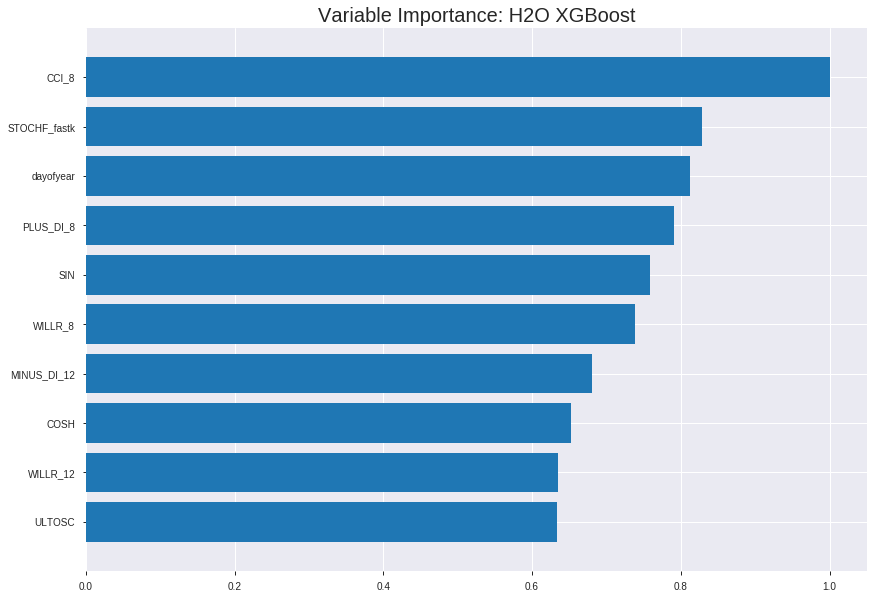

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_160346_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.032262770951905884
RMSE: 0.17961840371160714
LogLoss: 0.17506259721986506
Mean Per-Class Error: 0.001136363636363713
AUC: 0.9999949939927913
pr_auc: 0.9988938307742805
Gini: 0.9999899879855827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5170027017593384: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      878  2    0.0023   (2.0/880.0)
1      0    908  0        (0.0/908.0)
Total  878  910  0.0011   (2.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517003     0.9989    201
max f2                       0.517003     0.99956   201
max f0point5                 0.546666     0.999337  198
max accuracy                 0.517003     0.998881  201
max precision                0.969918     1         0
max recall                   0.517003     1         201
max specificity              0.969918     1         0
max absolute_mcc             0.517003     0.997765  201
max min_per_class_accuracy   0.541094     0.997797  199
max mean_per_class_accuracy  0.517003     0.998864  201

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.960584           1.96916   1.96916            1                0.963983   1                           0.963983            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.958374           1.96916   1.96916            1                0.959381   1                           0.961682            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.956476           1.96916   1.96916            1                0.957395   1                           0.960253            0.0198238       0.0594714                  96.9163   96.9163
    4        0.0402685                   0.954536           1.96916   1.96916            1                0.955464   1                           0.959056            0.0198238       0.0792952                  96.9163   96.9163
    5        0.0503356                   0.951213           1.96916   1.96916            1                0.953087   1                           0.957862            0.0198238       0.0991189                  96.9163   96.9163
    6        0.100112                    0.935191           1.96916   1.96916            1                0.9434     1                           0.950671            0.0980176       0.197137                   96.9163   96.9163
    7        0.150447                    0.912143           1.96916   1.96916            1                0.922523   1                           0.941254            0.0991189       0.296256                   96.9163   96.9163
    8        0.200224                    0.88814            1.96916   1.96916            1                0.901256   1                           0.93131             0.0980176       0.394273                   96.9163   96.9163
    9        0.300336                    0.836542           1.96916   1.96916            1                0.862043   1                           0.908221            0.197137        0.59141                    96.9163   96.9163
    10       0.399888                    0.777727           1.96916   1.96916            1                0.808878   1                           0.883489            0.196035        0.787445                   96.9163   96.9163
    11       0.5                         0.589168           1.96916   1.96916            1                0.719878   1                           0.850731            0.197137        0.984581                   96.9163   96.9163
    12       0.600112                    0.233122           0.154013  1.66636            0.0782123        0.319031   0.846226                    0.762031            0.0154185       1                          -84.5987  66.6356
    13       0.699664                    0.169221           0         1.42926            0                0.199282   0.725819                    0.68196             0               1                          -100      42.9257
    14       0.799776                    0.125529           0         1.25035            0                0.148115   0.634965                    0.615136            0               1                          -100      25.035
    15       0.899888                    0.0715701          0         1.11125            0                0.0987175  0.564326                    0.557685            0               1                          -100      11.1249
    16       1                           0.0310048          0         1                  0                0.0521075  0.50783                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1791561808411365
RMSE: 0.4232684500894633
LogLoss: 0.5320954662641941
Mean Per-Class Error: 0.2518777399675036
AUC: 0.8183497348171311
pr_auc: 0.8242873480702338
Gini: 0.6366994696342623
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4227119982242584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  112  0.4498   (112.0/249.0)
1      34   228  0.1298   (34.0/262.0)
Total  171  340  0.2857   (146.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422712     0.757475  260
max f2                       0.161442     0.864738  344
max f0point5                 0.702564     0.776965  151
max accuracy                 0.702564     0.745597  151
max precision                0.96718      1         0
max recall                   0.0557279    1         391
max specificity              0.96718      1         0
max absolute_mcc             0.702564     0.504886  151
max min_per_class_accuracy   0.610229     0.736641  192
max mean_per_class_accuracy  0.702564     0.748122  151

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 56.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.958091           1.95038   1.95038            1                0.962093   1                           0.962093            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.954195           1.95038   1.95038            1                0.955841   1                           0.959251            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.950829           1.95038   1.95038            1                0.951765   1                           0.956912            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.947145           1.95038   1.95038            1                0.948685   1                           0.954953            0.019084        0.0801527                  95.0382   95.0382
    5        0.0508806                   0.944368           1.95038   1.95038            1                0.945703   1                           0.953174            0.019084        0.0992366                  95.0382   95.0382
    6        0.101761                    0.927005           1.57531   1.76284            0.807692         0.934704   0.903846                    0.943939            0.0801527       0.179389                   57.5308   76.2845
    7        0.150685                    0.909582           1.95038   1.82373            1                0.918397   0.935065                    0.935646            0.0954198       0.274809                   95.0382   82.3734
    8        0.201566                    0.874538           1.65032   1.77996            0.846154         0.890988   0.912621                    0.924373            0.0839695       0.358779                   65.0323   77.996
    9        0.30137                     0.792969           1.41498   1.65909            0.72549          0.840571   0.850649                    0.896621            0.141221        0.5                        41.4983   65.9091
    10       0.401174                    0.707777           1.37674   1.58885            0.705882         0.748691   0.814634                    0.859818            0.137405        0.637405                   37.674    58.8848
    11       0.500978                    0.618955           0.917827  1.45517            0.470588         0.661108   0.746094                    0.820232            0.0916031       0.729008                   -8.21733  45.5168
    12       0.600783                    0.494215           0.879584  1.35955            0.45098          0.566793   0.697068                    0.778129            0.0877863       0.816794                   -12.0416  35.9549
    13       0.700587                    0.376499           0.68837   1.26393            0.352941         0.438142   0.648045                    0.729695            0.0687023       0.885496                   -31.163   26.3934
    14       0.800391                    0.239658           0.611884  1.18263            0.313725         0.312174   0.606357                    0.677633            0.0610687       0.946565                   -38.8116  18.2628
    15       0.900196                    0.108204           0.382428  1.09391            0.196078         0.16942    0.56087                     0.621288            0.0381679       0.984733                   -61.7572  9.39097
    16       1                           0.047805           0.152971  1                  0.0784314        0.0712673  0.51272                     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:03:59  6.704 sec   0                  0.5              0.693147            0.5             0                  1                0.49217                          0.5                0.693147              0.5               0                    1                  0.48728
    2019-08-22 16:03:59  7.069 sec   5                  0.439828         0.578907            0.974363        0.967272           1.96916          0.0760626                        0.470887           0.636024              0.783339          0.761166             1.67176            0.318982
    2019-08-22 16:03:59  7.389 sec   10                 0.389974         0.491789            0.992713        0.983804           1.96916          0.0352349                        0.448997           0.593404              0.812678          0.797563             1.95038            0.2818
    2019-08-22 16:04:00  7.710 sec   15                 0.349279         0.424459            0.997006        0.994904           1.96916          0.0229306                        0.436871           0.568504              0.815621          0.798473             1.62532            0.250489
    2019-08-22 16:04:00  8.063 sec   20                 0.31539          0.370541            0.998146        0.99045            1.96916          0.01566                          0.429554           0.552232              0.816395          0.808579             1.62532            0.250489
    2019-08-22 16:04:01  8.393 sec   25                 0.292061         0.334094            0.998968        0.997882           1.96916          0.0139821                        0.425134           0.541351              0.818281          0.816446             1.95038            0.264188
    2019-08-22 16:04:01  8.743 sec   30                 0.268217         0.298289            0.999387        0.99608            1.96916          0.00894855                       0.421007           0.531085              0.821323          0.823139             1.95038            0.268102
    2019-08-22 16:04:01  9.138 sec   35                 0.249461         0.270289            0.999662        0.997469           1.96916          0.00894855                       0.421463           0.53033               0.818488          0.820356             1.95038            0.285714
    2019-08-22 16:04:02  9.517 sec   40                 0.232962         0.246239            0.999813        0.997616           1.96916          0.00671141                       0.421668           0.529598              0.817852          0.820306             1.95038            0.272016
    2019-08-22 16:04:02  9.877 sec   45                 0.218346         0.225342            0.999837        0.997639           1.96916          0.00671141                       0.424182           0.5337                0.815591          0.81609              1.95038            0.295499
    2019-08-22 16:04:02  10.254 sec  50                 0.204478         0.206768            0.999954        0.997752           1.96916          0.00279642                       0.425278           0.535538              0.814019          0.815446             1.95038            0.285714
    2019-08-22 16:04:03  10.655 sec  55                 0.191437         0.190142            0.999987        0.998887           1.96916          0.00167785                       0.425155           0.535444              0.814878          0.82

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
CCI_8               2251.147216796875      1.0                    0.09045748555215306
STOCHF_fastk        1863.82373046875       0.8279439552250866     0.07489372836776573
dayofyear           1829.569580078125      0.812727646786865      0.07351729936705821
PLUS_DI_8           1780.2630615234375     0.7908248062321522     0.07153602348402917
SIN                 1707.697021484375      0.7585896687442025     0.06862011400044128
---                 ---                    ---                    ---
CDLLADDERBOTTOM     3.2946338653564453     0.001463535499044053   0.00013238774125984054
CDLSTALLEDPATTERN   2.590115547180176      0.0011505758165677028  0.00010407819530382968
CDLTHRUSTING        2.2742996215820312     0.0010102847137727845  9.138781489966275e-05
CDLEVENINGSTAR      1.4438834190368652     0.0006413989312930614  5.801933456060852e-05
CDLSEPARATINGLINES  1.2278361320495605     0.0005454268485366457  4.9337941271260004e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.7915194346289752)

('auc', 0.8556166056166057)

('logloss', 0.4757418558669313)

('mean_per_class_error', 0.2255189255189255)

('rmse', 0.3956964435261497)

('mse', 0.1565756754192434)

xgboost prediction progress: |████████████████████████████████████████████| 100%


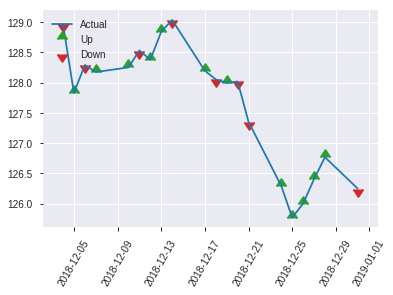


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1565756754192434
RMSE: 0.3956964435261497
LogLoss: 0.4757418558669313
Mean Per-Class Error: 0.2255189255189255
AUC: 0.8556166056166057
pr_auc: 0.8606353923069076
Gini: 0.7112332112332114
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4075237810611725: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   45   0.3462   (45.0/130.0)
1      14   112  0.1111   (14.0/126.0)
Total  99   157  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407524     0.791519  156
max f2                       0.334724     0.867347  181
max f0point5                 0.756414     0.800493  69
max accuracy                 0.460015     0.773438  143
max precision                0.965768     1         0
max recall                   0.0386994    1         255
max specificity              0.965768     1         0
max absolute_mcc             0.407524     0.557157  156
max min_per_class_accuracy   0.519396     0.746154  127
max mean_per_class_accuracy  0.460015     0.774481  143

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 52.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.961346           2.03175   2.03175            1                0.96434    1                           0.96434             0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.95909            2.03175   2.03175            1                0.960398   1                           0.962369            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.95573            2.03175   2.03175            1                0.958008   1                           0.961279            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.953477           2.03175   2.03175            1                0.954041   1                           0.959305            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.945689           2.03175   2.03175            1                0.951946   1                           0.958173            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.924679           2.03175   2.03175            1                0.932812   1                           0.945492            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.897425           1.87546   1.97965            0.923077         0.911606   0.974359                    0.934197            0.0952381       0.301587                   87.5458   97.965
    8        0.203125                    0.827235           2.03175   1.99267            1                0.867815   0.980769                    0.917602            0.103175        0.404762                   103.175   99.2674
    9        0.300781                    0.705804           1.30032   1.76788            0.64             0.779732   0.87013                     0.872839            0.126984        0.531746                   30.0317   76.7883
    10       0.402344                    0.590743           1.25031   1.63723            0.615385         0.646378   0.805825                    0.815674            0.126984        0.65873                    25.0305   63.7232
    11       0.5                         0.514156           0.975238  1.50794            0.48             0.552365   0.742188                    0.764246            0.0952381       0.753968                   -2.47619  50.7937
    12       0.601562                    0.421856           1.17216   1.45125            0.576923         0.468019   0.714286                    0.714234            0.119048        0.873016                   17.2161   45.1247
    13       0.699219                    0.350091           0.568889  1.32801            0.28             0.380708   0.653631                    0.667652            0.0555556       0.928571                   -43.1111  32.8013
    14       0.800781                    0.24552            0.39072   1.20914            0.192308         0.294504   0.595122                    0.620326            0.0396825       0.968254                   -60.928   20.9137
    15       0.898438                    0.120487           0.16254   1.09538            0.08             0.190834   0.53913                     0.573642            0.015873        0.984127                   -83.746   9.53761
    16       1                           0.0386994          0.156288  1                  0.0769231        0.0751552  0.492188                    

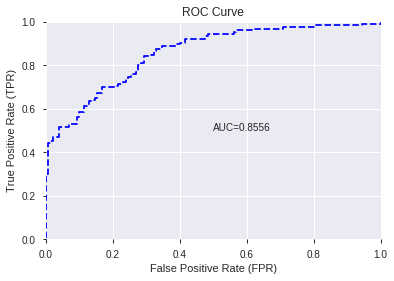

This function is available for GLM models only


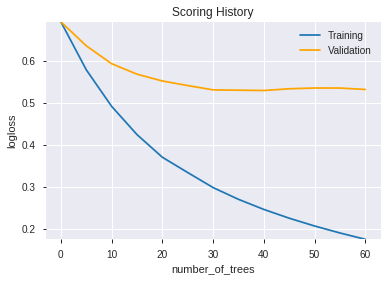

--2019-08-22 16:04:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.60
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.60|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_160346_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_160346_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CCI_8',
 'STOCHF_fastk',
 'dayofyear',
 'PLUS_DI_8',
 'SIN',
 'WILLR_8',
 'MINUS_DI_12',
 'COSH',
 'WILLR_12',
 'ULTOSC',
 'CCI_14',
 'CDLTAKURI',
 'PLUS_DI_12',
 'CDLGRAVESTONEDOJI',
 'aroonup_30',
 'week',
 'month',
 'EXP',
 'CDLDRAGONFLYDOJI',
 'weekofyear',
 'SINH',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'quarter',
 'is_month_start',
 'is_month_end',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDL3OUTSIDE',
 'is_quarter_start',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'CDLDARKCLOUDCOVER',
 'CDLHARAMICROSS',
 'CDLHOMINGPIGEON',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [916] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


15

['CCI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_8',
 'WILLR_12',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_160419_model_9  0.854701  0.500384              0.215079  0.410962  0.168890
1  DeepLearning_grid_1_AutoML_20190822_160419_model_6  0.854335  0.505114              0.244017  0.412167  0.169882
2  DeepLearning_grid_1_AutoML_20190822_160419_model_8  0.851404  0.501656              0.255067  0.411147  0.169042
3  DeepLearning_grid_1_AutoML_20190822_160419_model_5  0.843346  0.506557              0.267216  0.413576  0.171045
4  DeepLearning_grid_1_AutoML_20190822_160419_model_2  0.839621  0.540195              0.271673  0.430884  0.185661
5  DeepLearning_grid_1_AutoML_20190822_160419_model_7  0.839499  0.557382              0.281746  0.435628  0.189772
6               DeepLearning_1_AutoML_20190822_160419  0.828083  0.511999              0.282234  0.414139  0.171511
7  DeepLearning_grid_1_AutoML_20190822_160419_model_3  0.818376  0.539605              0.342796  0.424628  0.180309
8  DeepLearning_grid_1_AutoML_20190822_160419_model_4  0.803724  0.520701              0.279609  0.416916  0.173819
9  DeepLearning_grid_1_AutoML_20190822_160419_model_1  0.790476  0.546131              0.325031  0.427883  0.183084

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.000000           1.000000    0.108716
1    CDLGRAVESTONEDOJI             0.818152           0.818152    0.088946
2   CDLCLOSINGMARUBOZU             0.741724           0.741724    0.080637
3        CDLHANGINGMAN             0.697568           0.697568    0.075836
4     CDLDRAGONFLYDOJI             0.689953           0.689953    0.075009
5            CDLTAKURI             0.679062           0.679062    0.073825
6         STOCHF_fastk             0.625789           0.625789    0.068033
7               ULTOSC             0.572435           0.572435    0.062233
8    CDLINVERTEDHAMMER             0.570150           0.570150    0.061984
9            PLUS_DI_8             0.539524           0.539524    0.058655
10            WILLR_12             0.530592           0.530592    0.057684
11             WILLR_8             0.488317           0.488317    0.053088
12           PLUS_DM_8             0.423705           0.423705    0.046063
13     CDLSHOOTINGSTAR             0.418108           0.418108    0.045455
14         CDLBELTHOLD             0.403237           0.403237    0.043838

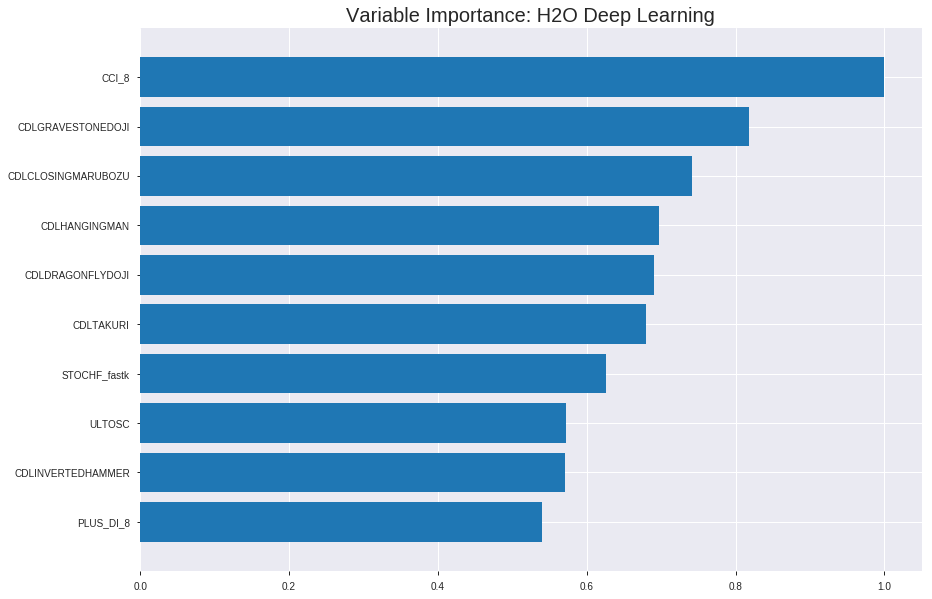

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_160419_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18727452823766233
RMSE: 0.43275227121028764
LogLoss: 0.5474397822283578
Mean Per-Class Error: 0.29723418101722066
AUC: 0.7896682268722467
pr_auc: 0.804853908313301
Gini: 0.5793364537444934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4628033616061311: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      405  475   0.5398   (475.0/880.0)
1      94   814   0.1035   (94.0/908.0)
Total  499  1289  0.3182   (569.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462803     0.74101   259
max f2                       0.18906      0.858654  347
max f0point5                 0.574389     0.72417   165
max accuracy                 0.520129     0.701902  201
max precision                0.990507     1         0
max recall                   0.11336      1         392
max specificity              0.990507     1         0
max absolute_mcc             0.574389     0.413295  165
max min_per_class_accuracy   0.505406     0.694318  214
max mean_per_class_accuracy  0.520129     0.702766  201

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.980467           1.96916    1.96916            1                0.983187  1                           0.983187            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.978423           1.96916    1.96916            1                0.979422  1                           0.981304            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.975871           1.96916    1.96916            1                0.976873  1                           0.979827            0.0198238       0.0594714                  96.9163   96.9163
    4        0.0402685                   0.97313            1.75037    1.91446            0.888889         0.974544  0.972222                    0.978506            0.0176211       0.0770925                  75.0367   91.4464
    5        0.0503356                   0.969952           1.96916    1.9254             1                0.971068  0.977778                    0.977019            0.0198238       0.0969163                  96.9163   92.5404
    6        0.100112                    0.944228           1.83641    1.88116            0.932584         0.958936  0.955307                    0.968028            0.0914097       0.188326                   83.641    88.1156
    7        0.150447                    0.774641           1.72849    1.83008            0.877778         0.879636  0.929368                    0.938454            0.0870044       0.27533                    72.8488   83.0077
    8        0.200224                    0.639895           1.52665    1.75465            0.775281         0.693289  0.891061                    0.877505            0.0759912       0.351322                   52.6654   75.4645
    9        0.300336                    0.586223           1.32011    1.6098             0.670391         0.61      0.817505                    0.788337            0.132159        0.48348                    32.0109   60.98
    10       0.399888                    0.539596           1.07308    1.47618            0.544944         0.562266  0.74965                     0.732056            0.106828        0.590308                   7.30832   47.6184
    11       0.5                         0.505577           1.02308    1.38546            0.519553         0.519797  0.703579                    0.689557            0.102423        0.692731                   2.30847   38.5463
    12       0.600112                    0.486702           0.979081   1.31767            0.497207         0.495606  0.669152                    0.657202            0.0980176       0.790749                   -2.0919   31.7669
    13       0.699664                    0.467437           0.818641   1.24666            0.41573          0.477216  0.633094                    0.631592            0.0814978       0.872247                   -18.1359  24.6664
    14       0.799776                    0.423013           0.748062   1.18425            0.379888         0.452067  0.601399                    0.60912             0.0748899       0.947137                   -25.1938  18.4252
    15       0.899888                    0.180249           0.429036   1.10023            0.217877         0.278183  0.558732                    0.572304            0.0429515       0.990088                   -57.0964  10.0235
    16       1                           0.0840981          0.0990082  1                  0.0502793        0.144375  0.50783                     0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17922637296264737
RMSE: 0.42335135875847546
LogLoss: 0.5321526449710817
Mean Per-Class Error: 0.25035255525920475
AUC: 0.8244811306293878
pr_auc: 0.8366317436860021
Gini: 0.6489622612587755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49335431626233256: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      164  85   0.3414   (85.0/249.0)
1      46   216  0.1756   (46.0/262.0)
Total  210  301  0.2564   (131.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493354     0.767318  232
max f2                       0.245947     0.858209  328
max f0point5                 0.578363     0.778867  133
max accuracy                 0.509477     0.749511  203
max precision                0.987943     1         0
max recall                   0.123048     1         388
max specificity              0.987943     1         0
max absolute_mcc             0.509477     0.499134  203
max min_per_class_accuracy   0.509477     0.744275  203
max mean_per_class_accuracy  0.509477     0.749647  203

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 53.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.979265           1.95038   1.95038            1                0.983505  1                           0.983505            0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.975869           1.95038   1.95038            1                0.976716  1                           0.980419            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.97472            1.95038   1.95038            1                0.975284  1                           0.978815            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.973648           1.95038   1.95038            1                0.974122  1                           0.977697            0.019084        0.0801527                  95.0382   95.0382
    5        0.0508806                   0.971956           1.95038   1.95038            1                0.972707  1                           0.976738            0.019084        0.0992366                  95.0382   95.0382
    6        0.101761                    0.960901           1.80035   1.87537            0.923077         0.966556  0.961538                    0.971647            0.0916031       0.19084                    80.0352   87.5367
    7        0.150685                    0.940337           1.71634   1.82373            0.88             0.951526  0.935065                    0.965114            0.0839695       0.274809                   71.6336   82.3734
    8        0.201566                    0.693815           1.72534   1.7989             0.884615         0.834206  0.92233                     0.932069            0.0877863       0.362595                   72.5338   79.8896
    9        0.30137                     0.592313           1.52971   1.70975            0.784314         0.625427  0.876623                    0.830519            0.152672        0.515267                   52.9711   70.975
    10       0.401174                    0.541874           1.03256   1.54128            0.529412         0.563936  0.790244                    0.764198            0.103053        0.618321                   3.2555    54.1277
    11       0.500978                    0.509451           1.26201   1.48564            0.647059         0.523276  0.761719                    0.716202            0.125954        0.744275                   26.2012   48.5642
    12       0.600783                    0.489455           0.803098  1.37226            0.411765         0.499113  0.703583                    0.680138            0.0801527       0.824427                   -19.6902  37.2256
    13       0.700587                    0.468776           0.764856  1.28573            0.392157         0.47902   0.659218                    0.651487            0.0763359       0.900763                   -23.5144  28.5726
    14       0.800391                    0.416631           0.458913  1.18263            0.235294         0.448964  0.606357                    0.626234            0.0458015       0.946565                   -54.1087  18.2628
    15       0.900196                    0.178058           0.305942  1.08543            0.156863         0.245376  0.556522                    0.584008            0.0305344       0.977099                   -69.4058  8.54298
    16       1                           0.102885           0.229457  1                  0.117647         0.136048  0.51272                     0.5393            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:11:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:11:33  2 min 24.034 sec  499 obs/sec       0.545302  1             975        0.538463         0.862809            -0.160054      0.77326         0.786541           1.85977          0.340045                         0.523106           0.824266              -0.095267        0.822826          0.837791             1.95038            0.311155
    2019-08-22 16:11:46  2 min 37.087 sec  784 obs/sec       6.08837   11            10886      0.442882         0.569186            0.215231       0.770535        0.784871           1.96916          0.329978                         0.433373           0.552115              0.248265         0.81579           0.827623             1.95038            0.277886
    2019-08-22 16:11:58  2 min 49.220 sec  833 obs/sec       11.59     21            20723      0.442773         0.567871            0.215616       0.775289        0.783973           1.85977          0.332215                         0.433679           0.551193              0.247202         0.815598          0.824596             1.95038            0.295499
    2019-08-22 16:12:10  3 min  0.740 sec  920 obs/sec       18.156    33            32463      0.448488         0.582766            0.195237       0.780304        0.789658           1.85977          0.336689                         0.439117           0.565151              0.228204         0.825447          0.829272             1.62532            0.268102
    2019-08-22 16:12:22  3 min 12.435 sec  985 obs/sec       25.2612   46            45167      0.440274         0.563694            0.224446       0.773242        0.786632           1.85977          0.336689                         0.431024           0.546211              0.256391         0.809758          0.822343             1.95038            0.305284
    2019-08-22 16:12:34  3 min 24.559 sec  1036 obs/sec      32.9144   60            58851      0.432817         0.548874            0.250493       0.785635        0.791317           1.75037          0.33557                          0.421839           0.533486              0.287747         0.826727          0.825525             1.95038            0.270059
    2019-08-22 16:12:46  3 min 36.487 sec  1075 obs/sec      40.6359   74            72657      0.432951         0.547417            0.250028       0.787578        0.795039           1.85977          0.32047                          0.422209           0.532922              0.286495         0.825431          0.826441             1.62532            0.264188
    2019-08-22 16:12:57  3 min 47.883 sec  1110 obs/sec      48.3529   88            86455      0.434907         0.552408            0.243237       0.789183        0.802948           1.96916          0.312081                         0.425195           0.538228              0.27637          0.827394          0.840025             1.95038            0.248532
    2019-08-22 16:13:09

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CCI_8               1                      1                    0.108716
CDLGRAVESTONEDOJI   0.818152               0.818152             0.0889459
CDLCLOSINGMARUBOZU  0.741724               0.741724             0.0806369
CDLHANGINGMAN       0.697568               0.697568             0.0758365
CDLDRAGONFLYDOJI    0.689953               0.689953             0.0750086
CDLTAKURI           0.679062               0.679062             0.0738246
STOCHF_fastk        0.625789               0.625789             0.0680329
ULTOSC              0.572435               0.572435             0.0622325
CDLINVERTEDHAMMER   0.57015                0.57015              0.0619842
PLUS_DI_8           0.539524               0.539524             0.0586546
WILLR_12            0.530592               0.530592             0.0576836
WILLR_8             0.488317               0.488317             0.0530877
PLUS_DM_8           0.423705               0.423705             0.0460634
CDLSHOOTINGSTAR     0.418108               0.418108             0.0454549
CDLBELTHOLD         0.403237               0.403237             0.0438382

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78515625)

('F1', 0.7791164658634538)

('auc', 0.8547008547008548)

('logloss', 0.5003838757467027)

('mean_per_class_error', 0.21507936507936498)

('rmse', 0.4109623396391688)

('mse', 0.1688900446016995)

deeplearning prediction progress: |███████████████████████████████████████| 100%


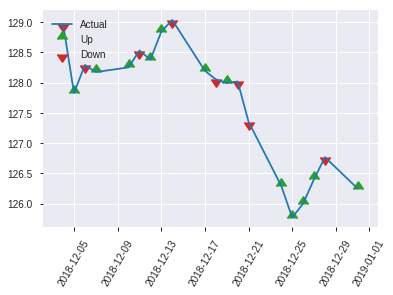


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1688900446016995
RMSE: 0.4109623396391688
LogLoss: 0.5003838757467027
Mean Per-Class Error: 0.21507936507936498
AUC: 0.8547008547008548
pr_auc: 0.8644950569313476
Gini: 0.7094017094017095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021974434970882: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      104  26   0.2      (26.0/130.0)
1      29   97   0.2302   (29.0/126.0)
Total  133  123  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502197     0.779116  122
max f2                       0.400683     0.85554   208
max f0point5                 0.575259     0.817536  73
max accuracy                 0.505018     0.785156  118
max precision                0.979277     1         0
max recall                   0.122486     1         252
max specificity              0.979277     1         0
max absolute_mcc             0.505018     0.570696  118
max min_per_class_accuracy   0.502197     0.769841  122
max mean_per_class_accuracy  0.502197     0.784921  122

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.974228           2.03175   2.03175            1                0.977716  1                           0.977716            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.972087           2.03175   2.03175            1                0.972761  1                           0.975238            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.970414           2.03175   2.03175            1                0.971262  1                           0.974244            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.968262           2.03175   2.03175            1                0.969564  1                           0.972968            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.965685           2.03175   2.03175            1                0.966659  1                           0.971997            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.953371           2.03175   2.03175            1                0.959571  1                           0.965784            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.933369           1.87546   1.97965            0.923077         0.945152  0.974359                    0.958907            0.0952381       0.301587                   87.5458   97.965
    8        0.203125                    0.705925           1.87546   1.9536             0.923077         0.883697  0.961538                    0.940104            0.0952381       0.396825                   87.5458   95.3602
    9        0.300781                    0.564677           1.54413   1.82066            0.76             0.607575  0.896104                    0.83214             0.150794        0.547619                   54.4127   82.0656
    10       0.402344                    0.521417           1.25031   1.67668            0.615385         0.542135  0.825243                    0.758935            0.126984        0.674603                   25.0305   67.6684
    11       0.5                         0.499702           0.975238  1.53968            0.48             0.506923  0.757812                    0.709714            0.0952381       0.769841                   -2.47619  53.9683
    12       0.601562                    0.482386           0.859585  1.42486            0.423077         0.490148  0.701299                    0.672644            0.0873016       0.857143                   -14.0415  42.4861
    13       0.699219                    0.462068           0.650159  1.31666            0.32             0.471637  0.648045                    0.644571            0.0634921       0.920635                   -34.9841  31.6662
    14       0.800781                    0.426796           0.234432  1.1794             0.115385         0.445649  0.580488                    0.619342            0.0238095       0.944444                   -76.5568  17.9404
    15       0.898438                    0.190899           0.325079  1.08654            0.16             0.289475  0.534783                    0.583487            0.031746        0.97619                    -67.4921  8.65424
    16       1                           0.10569            0.234432  1                  0.115385         0.156421  0.492188                    0.540113          

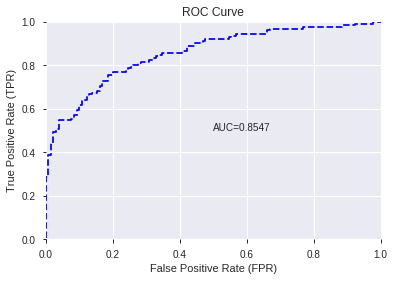

This function is available for GLM models only


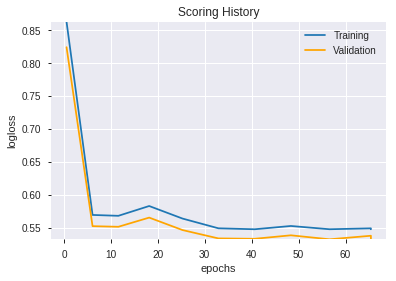

--2019-08-22 16:13:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.236
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.236|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_160419_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_160419_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLINVERTEDHAMMER',
 'PLUS_DI_8',
 'WILLR_12',
 'WILLR_8',
 'PLUS_DM_8',
 'CDLSHOOTINGSTAR',
 'CDLBELTHOLD']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190822_161336_model_1  0.842552  0.481759              0.233211  0.401796  0.16144

variable  relative_importance  scaled_importance  percentage
0            CDLTAKURI             1.283233           1.000000    0.208581
1                CCI_8             1.181531           0.920745    0.192050
2     CDLDRAGONFLYDOJI             0.779313           0.607304    0.126672
3    CDLGRAVESTONEDOJI             0.593719           0.462675    0.096505
4             WILLR_12             0.498065           0.388133    0.080957
5         STOCHF_fastk             0.462251           0.360224    0.075136
6              WILLR_8             0.418931           0.326465    0.068095
7    CDLINVERTEDHAMMER             0.233770           0.182172    0.037998
8            PLUS_DI_8             0.178233           0.138894    0.028971
9        CDLHANGINGMAN             0.158466           0.123489    0.025758
10  CDLCLOSINGMARUBOZU             0.155446           0.121136    0.025267
11           PLUS_DM_8             0.097433           0.075928    0.015837
12     CDLSHOOTINGSTAR             0.044440           0.034631    0.007223
13              ULTOSC             0.041892           0.032646    0.006809
14         CDLBELTHOLD             0.025469           0.019847    0.004140

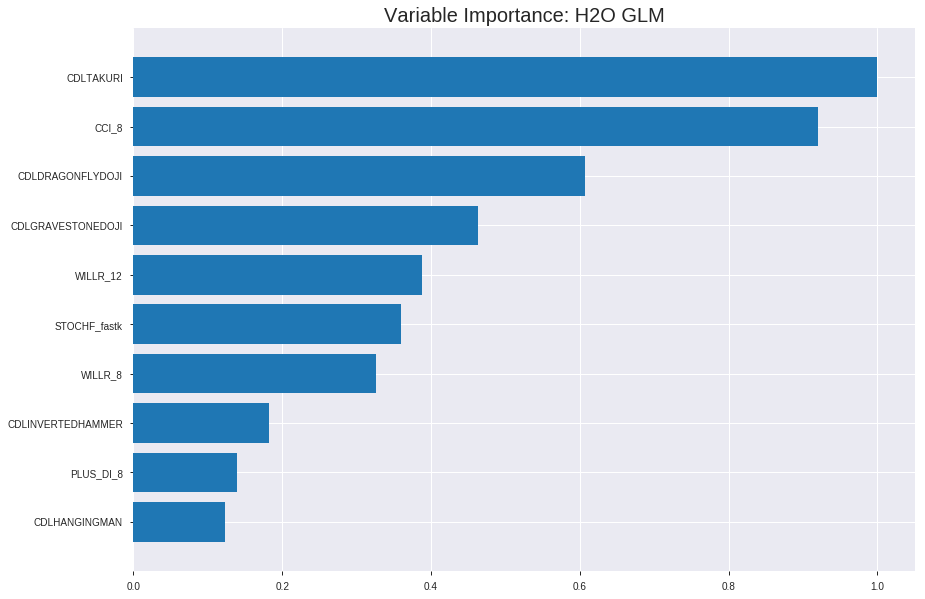

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161336_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.183003574469818
RMSE: 0.4277891705850184
LogLoss: 0.5362141349191292
Null degrees of freedom: 1787
Residual degrees of freedom: 1772
Null deviance: 2478.2558210117336
Residual deviance: 1917.5017464708058
AIC: 1949.5017464708058
AUC: 0.7947624649579496
pr_auc: 0.8074018724867809
Gini: 0.5895249299158991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3892012622369566: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      426  454   0.5159   (454.0/880.0)
1      99   809   0.109    (99.0/908.0)
Total  525  1263  0.3093   (553.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389201     0.745279  253
max f2                       0.162674     0.860101  333
max f0point5                 0.581724     0.734036  155
max accuracy                 0.535415     0.711409  179
max precision                0.998564     1         0
max recall                   0.023334     1         395
max specificity              0.998564     1         0
max absolute_mcc             0.560291     0.430126  166
max min_per_class_accuracy   0.508846     0.696591  194
max mean_per_class_accuracy  0.535415     0.712232  179

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.986665           1.96916   1.96916            1                0.990793   1                           0.990793            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.980458           1.96916   1.96916            1                0.982948   1                           0.98687             0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.976948           1.85977   1.9327             0.944444         0.978767   0.981481                    0.984169            0.0187225       0.05837                    85.9765   93.2697
    4        0.0402685                   0.971243           1.96916   1.94181            1                0.974329   0.986111                    0.981709            0.0198238       0.0781938                  96.9163   94.1814
    5        0.0503356                   0.965525           1.96916   1.94728            1                0.968512   0.988889                    0.97907             0.0198238       0.0980176                  96.9163   94.7283
    6        0.100112                    0.923701           1.88066   1.91416            0.955056         0.947131   0.972067                    0.963189            0.0936123       0.19163                    88.0661   91.4158
    7        0.150447                    0.79932            1.68473   1.8374             0.855556         0.870265   0.933086                    0.932099            0.0848018       0.276432                   68.4728   83.7397
    8        0.200224                    0.71297            1.43815   1.73814            0.730337         0.74541    0.882682                    0.885688            0.0715859       0.348018                   43.8153   73.8144
    9        0.300336                    0.619816           1.36411   1.61347            0.692737         0.663677   0.819367                    0.811684            0.136564        0.484581                   36.4113   61.3467
    10       0.399888                    0.559371           1.22796   1.51749            0.623596         0.58965    0.770629                    0.756409            0.122247        0.606828                   22.7961   51.7495
    11       0.5                         0.511506           0.880073  1.38987            0.446927         0.534773   0.705817                    0.712032            0.0881057       0.694934                   -11.9927  38.9868
    12       0.600112                    0.457486           1.05609   1.33419            0.536313         0.484259   0.67754                     0.674034            0.105727        0.800661                   5.60874   33.4186
    13       0.699664                    0.393689           0.829704  1.26241            0.421348         0.425325   0.641087                    0.638647            0.0825991       0.88326                    -17.0296  26.2405
    14       0.799776                    0.292323           0.60505   1.18012            0.307263         0.34982    0.599301                    0.602493            0.0605727       0.943833                   -39.495   18.0121
    15       0.899888                    0.11157            0.429036  1.09656            0.217877         0.193093   0.556868                    0.556947            0.0429515       0.986784                   -57.0964  9.65631
    16       1                           0.00566653         0.132011  1                  0.0670391        0.0663413  0.50783                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16867225742587597
RMSE: 0.4106972819801416
LogLoss: 0.5069494395038854
Null degrees of freedom: 510
Residual degrees of freedom: 495
Null deviance: 708.1145564513349
Residual deviance: 518.102327172971
AIC: 550.102327172971
AUC: 0.8341764002575186
pr_auc: 0.8406281513087055
Gini: 0.6683528005150372
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40337521206509086: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  115  0.4618   (115.0/249.0)
1      23   239  0.0878   (23.0/262.0)
Total  157  354  0.2701   (138.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403375     0.775974  270
max f2                       0.351916     0.860742  292
max f0point5                 0.646079     0.783753  124
max accuracy                 0.550205     0.751468  176
max precision                0.99314      1         0
max recall                   0.0300285    1         395
max specificity              0.99314      1         0
max absolute_mcc             0.550205     0.509114  176
max min_per_class_accuracy   0.515807     0.746988  201
max mean_per_class_accuracy  0.550205     0.75305   176

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.987171           1.95038   1.95038            1                0.99106    1                           0.99106             0.0229008       0.0229008                  95.0382   95.0382
    2        0.0215264                   0.977496           1.95038   1.95038            1                0.98008    1                           0.986069            0.019084        0.0419847                  95.0382   95.0382
    3        0.0313112                   0.974896           1.95038   1.95038            1                0.976777   1                           0.983165            0.019084        0.0610687                  95.0382   95.0382
    4        0.0410959                   0.968302           1.95038   1.95038            1                0.971119   1                           0.980297            0.019084        0.0801527                  95.0382   95.0382
    5        0.0508806                   0.962763           1.95038   1.95038            1                0.964912   1                           0.977338            0.019084        0.0992366                  95.0382   95.0382
    6        0.101761                    0.934871           1.80035   1.87537            0.923077         0.948557   0.961538                    0.962948            0.0916031       0.19084                    80.0352   87.5367
    7        0.150685                    0.889733           1.79435   1.84906            0.92             0.911043   0.948052                    0.946096            0.0877863       0.278626                   79.4351   84.9063
    8        0.201566                    0.785034           1.65032   1.7989             0.846154         0.838211   0.92233                     0.918863            0.0839695       0.362595                   65.0323   79.8896
    9        0.30137                     0.643639           1.6062    1.73508            0.823529         0.705731   0.88961                     0.84828             0.160305        0.522901                   60.6197   73.508
    10       0.401174                    0.572618           1.14728   1.58885            0.588235         0.605917   0.814634                    0.787985            0.114504        0.637405                   14.7283   58.8848
    11       0.500978                    0.518126           1.03256   1.47802            0.529412         0.545747   0.757812                    0.739727            0.103053        0.740458                   3.2555    47.8024
    12       0.600783                    0.461762           0.917827  1.38496            0.470588         0.492443   0.710098                    0.698647            0.0916031       0.832061                   -8.21733  38.4962
    13       0.700587                    0.394667           0.803098  1.30207            0.411765         0.429562   0.667598                    0.660314            0.0801527       0.912214                   -19.6902  30.207
    14       0.800391                    0.274356           0.344185  1.18263            0.176471         0.341632   0.606357                    0.620576            0.0343511       0.946565                   -65.5815  18.2628
    15       0.900196                    0.0985682          0.382428  1.09391            0.196078         0.174656   0.56087                     0.571137            0.0381679       0.984733                   -61.7572  9.39097
    16       1                           0.0220913          0.152971  1                  0.0784314        0.0586809  0.51272                     0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:13:36  0.000 sec   2            .17E2     16            1.3689555596351295  1.3660266786105422
     2019-08-22 16:13:36  0.005 sec   4            .11E2     16            1.3594796334451045  1.355090537577304
     2019-08-22 16:13:36  0.009 sec   6            .66E1     16            1.3455379440179707  1.3389907261530398
     2019-08-22 16:13:36  0.014 sec   8            .41E1     16            1.3259952139852014  1.316406130415983
     2019-08-22 16:13:36  0.018 sec   10           .25E1     16            1.3003382802258086  1.2867245832363607
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:13:36  0.105 sec   44           .3E-3     16            1.072653965174464   1.0140737588087165
     2019-08-22 16:13:36  0.108 sec   45           .18E-3    16            1.072570979926785   1.0139972440270435
     2019-08-22 16:13:36  0.110 sec   46           .11E-3    16            1.0725081186711996  1.013946788075056
     2019-08-22 16:13:36  0.113 sec   47           .71E-4    16            1.0724618881469923  1.0139182399587943
     2019-08-22 16:13:36  0.116 sec   48           .44E-4    16            1.0724282698382583  1.013898879007771


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7794117647058825)

('auc', 0.8425518925518926)

('logloss', 0.4817589860372532)

('mean_per_class_error', 0.23321123321123327)

('rmse', 0.4017955676317252)

('mse', 0.16143967816850027)

glm prediction progress: |████████████████████████████████████████████████| 100%


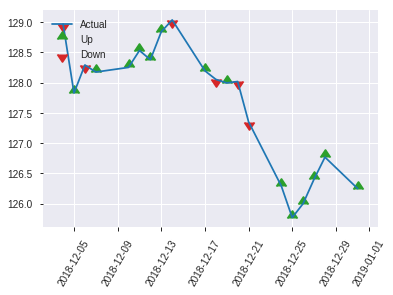


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16143967816850027
RMSE: 0.4017955676317252
LogLoss: 0.4817589860372532
Null degrees of freedom: 255
Residual degrees of freedom: 240
Null deviance: 355.07943398521934
Residual deviance: 246.66060085107367
AIC: 278.6606008510737
AUC: 0.8425518925518926
pr_auc: 0.8510838564407894
Gini: 0.6851037851037851
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4497350859233786: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   40   0.3077   (40.0/130.0)
1      20   106  0.1587   (20.0/126.0)
Total  110  146  0.2344   (60.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449735     0.779412  145
max f2                       0.266944     0.856742  207
max f0point5                 0.642606     0.794872  65
max accuracy                 0.449735     0.765625  145
max precision                0.98866      1         0
max recall                   0.0587845    1         242
max specificity              0.98866      1         0
max absolute_mcc             0.449735     0.538867  145
max min_per_class_accuracy   0.479726     0.738462  127
max mean_per_class_accuracy  0.449735     0.766789  145

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.981392           2.03175   2.03175            1                0.984173   1                           0.984173            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.976412           2.03175   2.03175            1                0.978532   1                           0.981352            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.96745            2.03175   2.03175            1                0.970767   1                           0.978706            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.963046           2.03175   2.03175            1                0.965891   1                           0.975211            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.960851           2.03175   2.03175            1                0.961115   1                           0.973042            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.93824            2.03175   2.03175            1                0.950458   1                           0.96175             0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.894809           2.03175   2.03175            1                0.916451   1                           0.94665             0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.741991           1.87546   1.99267            0.923077         0.831267   0.980769                    0.917805            0.0952381       0.404762                   87.5458   99.2674
    9        0.300781                    0.604493           1.21905   1.7415             0.6              0.655071   0.857143                    0.832501            0.119048        0.52381                    21.9048   74.1497
    10       0.402344                    0.541436           1.25031   1.61751            0.615385         0.568745   0.796117                    0.765922            0.126984        0.650794                   25.0305   61.7507
    11       0.5                         0.475588           0.975238  1.49206            0.48             0.50868    0.734375                    0.71568             0.0952381       0.746032                   -2.47619  49.2063
    12       0.601562                    0.438581           1.09402   1.42486            0.538462         0.45454    0.701299                    0.671591            0.111111        0.857143                   9.40171   42.4861
    13       0.699219                    0.378268           0.568889  1.30531            0.28             0.414813   0.642458                    0.635728            0.0555556       0.912698                   -43.1111  30.5312
    14       0.800781                    0.2914             0.39072   1.18931            0.192308         0.334822   0.585366                    0.597564            0.0396825       0.952381                   -60.928   18.9315
    15       0.898438                    0.103415           0.24381   1.08654            0.12             0.17727    0.534783                    0.55188             0.0238095       0.97619                    -75.619   8.65424
    16       1                           0.0291053          0.234432  1                  0.115385         0.0626139  0.492188                   

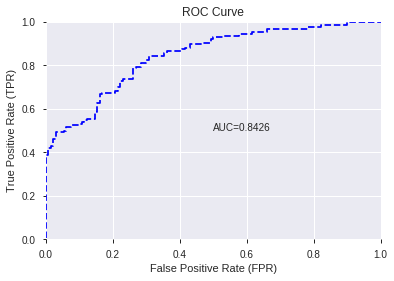

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


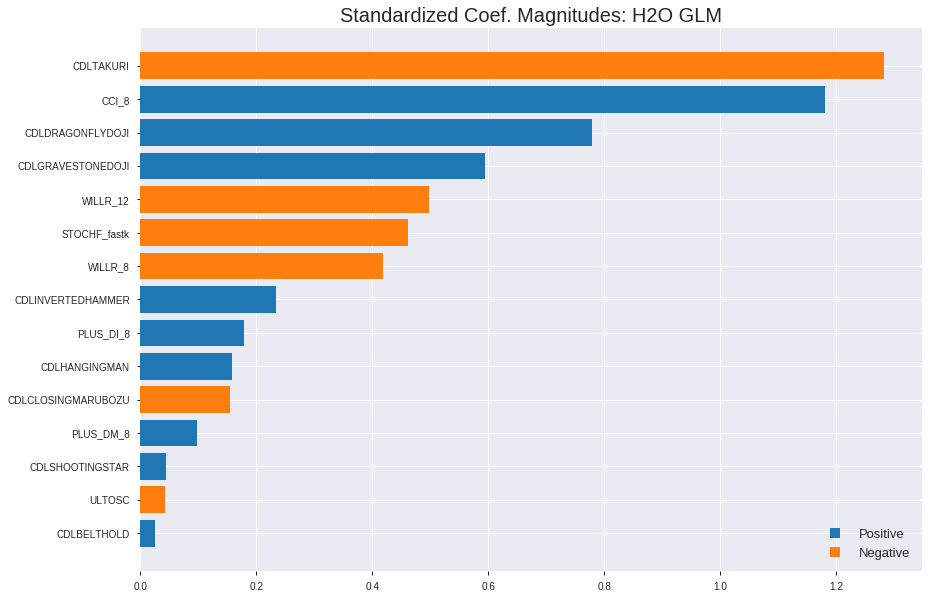

'log_likelihood'
--2019-08-22 16:13:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161336_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161336_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLTAKURI',
 'CCI_8',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'WILLR_12',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLINVERTEDHAMMER',
 'PLUS_DI_8',
 'CDLHANGINGMAN',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'CDLSHOOTINGSTAR',
 'ULTOSC',
 'CDLBELTHOLD']

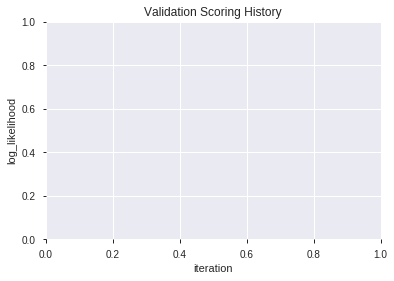

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_161348_model_7  0.835043  0.493619              0.248474  0.405968  0.164810
1               XGBoost_2_AutoML_20190822_161348  0.834799  0.494840              0.237790  0.406501  0.165243
2               XGBoost_3_AutoML_20190822_161348  0.834737  0.493706              0.263370  0.406021  0.164853
3  XGBoost_grid_1_AutoML_20190822_161348_model_2  0.834432  0.493127              0.285714  0.405385  0.164337
4  XGBoost_grid_1_AutoML_20190822_161348_model_4  0.832479  0.502756              0.297009  0.408578  0.166936
5  XGBoost_grid_1_AutoML_20190822_161348_model_1  0.831746  0.494716              0.267094  0.406284  0.165067
6               XGBoost_1_AutoML_20190822_161348  0.830159  0.498236              0.263858  0.408729  0.167060
7  XGBoost_grid_1_AutoML_20190822_161348_model_3  0.827350  0.494698              0.297253  0.407164  0.165782
8  XGBoost_grid_1_AutoML_20190822_161348_model_6  0.825763  0.497087              0.278510  0.408210  0.166636
9  XGBoost_grid_1_AutoML_20190822_161348_model_5  0.821001  0.518386              0.249206  0.416243  0.173259

variable  relative_importance  scaled_importance  percentage
0                CCI_8          1216.301880           1.000000    0.129926
1             WILLR_12          1026.008789           0.843548    0.109599
2    CDLGRAVESTONEDOJI          1023.825500           0.841753    0.109365
3              WILLR_8           987.138428           0.811590    0.105446
4            PLUS_DI_8           935.922485           0.769482    0.099976
5               ULTOSC           908.132324           0.746634    0.097007
6            PLUS_DM_8           895.620544           0.736347    0.095671
7         STOCHF_fastk           866.114624           0.712089    0.092519
8            CDLTAKURI           849.723938           0.698613    0.090768
9     CDLDRAGONFLYDOJI           482.434723           0.396641    0.051534
10  CDLCLOSINGMARUBOZU            67.334290           0.055360    0.007193
11   CDLINVERTEDHAMMER            50.944038           0.041884    0.005442
12     CDLSHOOTINGSTAR            37.161835           0.030553    0.003970
13       CDLHANGINGMAN             8.006337           0.006583    0.000855
14         CDLBELTHOLD             6.842259           0.005625    0.000731

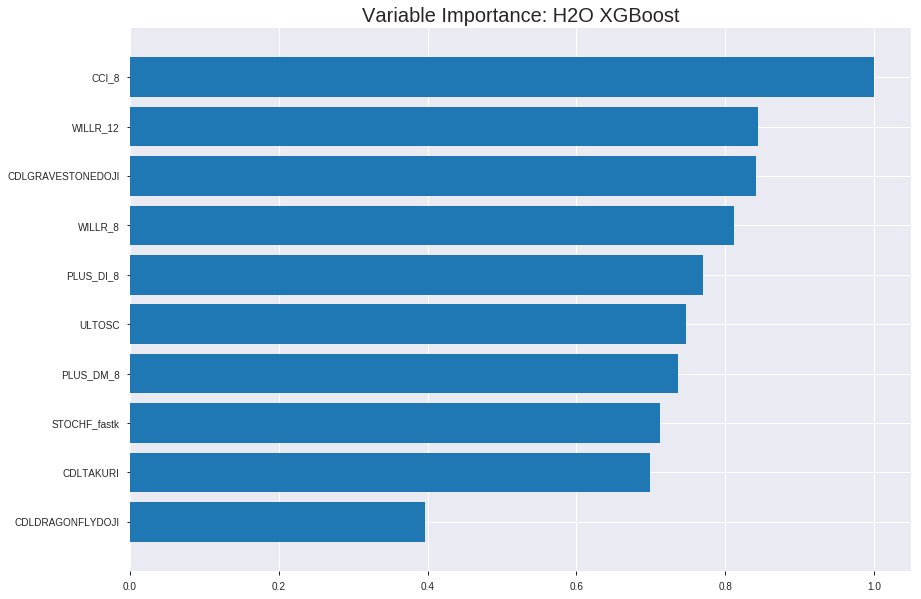

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_161348_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12741098523558328
RMSE: 0.3569467540622597
LogLoss: 0.40684928706228884
Mean Per-Class Error: 0.15311623948738484
AUC: 0.918588556267521
pr_auc: 0.9223174656750593
Gini: 0.837177112535042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4656204198087965: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      717  163  0.1852   (163.0/880.0)
1      111  797  0.1222   (111.0/908.0)
Total  828  960  0.1532   (274.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46562      0.853319  219
max f2                       0.357941     0.891304  269
max f0point5                 0.591153     0.863032  164
max accuracy                 0.468058     0.847315  218
max precision                0.974126     1         0
max recall                   0.108721     1         367
max specificity              0.974126     1         0
max absolute_mcc             0.468058     0.695198  218
max min_per_class_accuracy   0.491354     0.845455  208
max mean_per_class_accuracy  0.468058     0.846884  218

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.964923           1.96916    1.96916            1                0.968919   1                           0.968919            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.957323           1.96916    1.96916            1                0.960673   1                           0.964796            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.951406           1.96916    1.96916            1                0.954497   1                           0.961363            0.0198238       0.0594714                  96.9163   96.9163
    4        0.0402685                   0.947701           1.96916    1.96916            1                0.94952    1                           0.958402            0.0198238       0.0792952                  96.9163   96.9163
    5        0.0503356                   0.940709           1.96916    1.96916            1                0.94484    1                           0.95569             0.0198238       0.0991189                  96.9163   96.9163
    6        0.100112                    0.912597           1.96916    1.96916            1                0.927234   1                           0.941541            0.0980176       0.197137                   96.9163   96.9163
    7        0.150447                    0.861804           1.9254     1.95452            0.977778         0.888873   0.992565                    0.92392             0.0969163       0.294053                   92.5404   95.4522
    8        0.200224                    0.800717           1.81429    1.91966            0.921348         0.832782   0.97486                     0.901263            0.0903084       0.384361                   81.4285   91.9659
    9        0.300336                    0.684678           1.71614    1.85182            0.871508         0.740113   0.94041                     0.847546            0.171806        0.556167                   71.6142   85.182
    10       0.399888                    0.589335           1.61516    1.7929             0.820225         0.634048   0.91049                     0.794396            0.160793        0.71696                    61.5156   79.2902
    11       0.5                         0.495191           1.2211     1.67841            0.620112         0.540657   0.852349                    0.743591            0.122247        0.839207                   22.1101   67.8414
    12       0.600112                    0.414742           0.781065   1.52872            0.396648         0.453586   0.776328                    0.695212            0.0781938       0.917401                   -21.8935  52.8716
    13       0.699664                    0.334397           0.398258   1.36787            0.202247         0.373395   0.694644                    0.649422            0.0396476       0.957048                   -60.1742  36.7868
    14       0.799776                    0.233762           0.275023   1.23107            0.139665         0.288784   0.625175                    0.604279            0.027533        0.984581                   -72.4977  23.1071
    15       0.899888                    0.113948           0.143012   1.11003            0.0726257        0.169267   0.563704                    0.555884            0.0143172       0.998899                   -85.6988  11.0025
    16       1                           0.0354293          0.0110009  1                  0.00558659       0.0807399  0.50783   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16687907479208455
RMSE: 0.4085083533932746
LogLoss: 0.504941003838426
Mean Per-Class Error: 0.23398939268524477
AUC: 0.8324519451853214
pr_auc: 0.8400331178186108
Gini: 0.6649038903706428
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.417648583650589: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  95   0.3815   (95.0/249.0)
1      39   223  0.1489   (39.0/262.0)
Total  193  318  0.2622   (134.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417649     0.768966  247
max f2                       0.191782     0.857143  336
max f0point5                 0.685991     0.79798   138
max accuracy                 0.560109     0.765166  184
max precision                0.972455     1         0
max recall                   0.0709103    1         390
max specificity              0.972455     1         0
max absolute_mcc             0.560109     0.532593  184
max min_per_class_accuracy   0.518789     0.751004  199
max mean_per_class_accuracy  0.560109     0.766011  184

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 53.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.96706            1.95038   1.95038            1                0.969125   1                           0.969125            0.0229008       0.0229008                  95.0382    95.0382
    2        0.0215264                   0.961291           1.95038   1.95038            1                0.964462   1                           0.967006            0.019084        0.0419847                  95.0382    95.0382
    3        0.0313112                   0.954879           1.95038   1.95038            1                0.958581   1                           0.964373            0.019084        0.0610687                  95.0382    95.0382
    4        0.0410959                   0.951409           1.56031   1.85751            0.8              0.953149   0.952381                    0.9617              0.0152672       0.0763359                  56.0305    85.7506
    5        0.0508806                   0.94647            1.95038   1.87537            1                0.948967   0.961538                    0.959252            0.019084        0.0954198                  95.0382    87.5367
    6        0.101761                    0.922065           1.80035   1.83786            0.923077         0.932153   0.942308                    0.945702            0.0916031       0.187023                   80.0352    83.786
    7        0.150685                    0.896851           1.63832   1.77307            0.84             0.911175   0.909091                    0.934492            0.0801527       0.267176                   63.8321    77.3074
    8        0.201566                    0.857389           1.80035   1.77996            0.923077         0.876554   0.912621                    0.919867            0.0916031       0.358779                   80.0352    77.996
    9        0.30137                     0.759188           1.64444   1.73508            0.843137         0.811021   0.88961                     0.883821            0.164122        0.522901                   64.4439    73.508
    10       0.401174                    0.62781            1.22377   1.60788            0.627451         0.690546   0.82439                     0.835738            0.122137        0.645038                   22.3769    60.7876
    11       0.500978                    0.526675           0.994312  1.48564            0.509804         0.583861   0.761719                    0.785559            0.0992366       0.744275                   -0.568777  48.5642
    12       0.600783                    0.434949           0.803098  1.37226            0.411765         0.483687   0.703583                    0.735411            0.0801527       0.824427                   -19.6902   37.2256
    13       0.700587                    0.334091           0.650127  1.26938            0.333333         0.385998   0.650838                    0.685634            0.0648855       0.889313                   -34.9873   26.9382
    14       0.800391                    0.227967           0.573642  1.18263            0.294118         0.277348   0.606357                    0.634723            0.0572519       0.946565                   -42.6358   18.2628
    15       0.900196                    0.12895            0.344185  1.08967            0.176471         0.168657   0.558696                    0.583051            0.0343511       0.980916                   -65.5815   8.96698
    16       1                           0.0508813          0.191214  1                  0.0980392        0.0919163  0.51272      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:14:09  15.596 sec  0                  0.5              0.693147            0.5             0                  1                0.49217                          0.5                0.693147              0.5               0                    1                  0.48728
    2019-08-22 16:14:09  15.705 sec  5                  0.468011         0.630644            0.846476        0.841766           1.96916          0.255593                         0.469111           0.632725              0.815729          0.821943             1.95038            0.250489
    2019-08-22 16:14:09  15.792 sec  10                 0.445383         0.586999            0.857532        0.860094           1.96916          0.233221                         0.449221           0.593948              0.817292          0.824336             1.95038            0.27593
    2019-08-22 16:14:09  15.877 sec  15                 0.429611         0.555939            0.864258        0.868179           1.96916          0.238814                         0.437423           0.570059              0.817468          0.828802             1.95038            0.2818
    2019-08-22 16:14:09  15.969 sec  20                 0.41595          0.528638            0.873193        0.876441           1.96916          0.214765                         0.4277             0.549868              0.821331          0.82827              1.95038            0.273973
    2019-08-22 16:14:10  16.059 sec  25                 0.407272         0.510505            0.877811        0.882847           1.96916          0.219239                         0.423091           0.539373              0.821852          0.828957             1.95038            0.272016
    2019-08-22 16:14:10  16.148 sec  30                 0.399444         0.493911            0.882067        0.889365           1.96916          0.201902                         0.418948           0.529764              0.824144          0.830389             1.95038            0.264188
    2019-08-22 16:14:10  16.236 sec  35                 0.393312         0.480551            0.88538         0.892169           1.96916          0.204139                         0.416575           0.524084              0.825386          0.831496             1.95038            0.266145
    2019-08-22 16:14:10  16.315 sec  40                 0.388862         0.470878            0.887983        0.892273           1.96916          0.198546                         0.414324           0.51891               0.826941          0.833513             1.95038            0.266145
    2019-08-22 16:14:10  16.402 sec  45                 0.384068         0.460963            0.892272        0.895785           1.96916          0.189597                         0.413155           0.516008              0.8278            0.833312             1.95038            0.270059
    2019-08-22 16:14:10  16.484 sec  50                 0.37987          0.452196            0.89676         0.899692           1.96916          0.175615                         0.411537           0.511991              0.829869          0.835581             1.95038            0.260274
    2019-08-22 16:14:10  16.580 sec  55                 0.374899         0.441973            0.901521        0.902266           1.96916          0.174497                         0.409883           0.508154              0.83141           0.838

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CCI_8               1216.3                 1                    0.129926
WILLR_12            1026.01                0.843548             0.109599
CDLGRAVESTONEDOJI   1023.83                0.841753             0.109365
WILLR_8             987.138                0.81159              0.105446
PLUS_DI_8           935.922                0.769482             0.0999756
ULTOSC              908.132                0.746634             0.097007
PLUS_DM_8           895.621                0.736347             0.0956705
STOCHF_fastk        866.115                0.712089             0.0925187
CDLTAKURI           849.724                0.698613             0.0907678
CDLDRAGONFLYDOJI    482.435                0.396641             0.0515338
CDLCLOSINGMARUBOZU  67.3343                0.0553598            0.00719267
CDLINVERTEDHAMMER   50.944                 0.0418844            0.00544186
CDLSHOOTINGSTAR     37.1618                0.0305531            0.00396964
CDLHANGINGMAN       8.00634                0.00658252           0.00085524
CDLBELTHOLD         6.84226                0.00562546           0.000730893

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75390625)

('F1', 0.7697841726618704)

('auc', 0.8350427350427351)

('logloss', 0.49361884294064245)

('mean_per_class_error', 0.2465811965811966)

('rmse', 0.405967658162676)

('mse', 0.16480973947408734)

xgboost prediction progress: |████████████████████████████████████████████| 100%


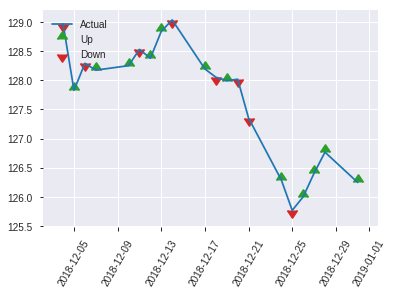


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16480973947408734
RMSE: 0.405967658162676
LogLoss: 0.49361884294064245
Mean Per-Class Error: 0.2465811965811966
AUC: 0.8350427350427351
pr_auc: 0.8452605210826739
Gini: 0.6700854700854701
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4014359414577484: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   45   0.3462   (45.0/130.0)
1      19   107  0.1508   (19.0/126.0)
Total  104  152  0.25     (64.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401436     0.769784  151
max f2                       0.209875     0.852113  205
max f0point5                 0.77047      0.790155  64
max accuracy                 0.577933     0.753906  100
max precision                0.969002     1         0
max recall                   0.0557497    1         254
max specificity              0.969002     1         0
max absolute_mcc             0.77047      0.520744  64
max min_per_class_accuracy   0.482744     0.746032  126
max mean_per_class_accuracy  0.51019      0.753419  118

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.966541           2.03175   2.03175            1                0.968308   1                           0.968308            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.962096           2.03175   2.03175            1                0.964351   1                           0.96633             0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.956248           2.03175   2.03175            1                0.960662   1                           0.964913            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.950104           2.03175   2.03175            1                0.952088   1                           0.961415            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.943772           2.03175   2.03175            1                0.946554   1                           0.959129            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.924865           2.03175   2.03175            1                0.936428   1                           0.947778            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.895149           1.87546   1.97965            0.923077         0.913389   0.974359                    0.936315            0.0952381       0.301587                   87.5458   97.965
    8        0.203125                    0.860971           1.87546   1.9536             0.923077         0.87724    0.961538                    0.921546            0.0952381       0.396825                   87.5458   95.3602
    9        0.300781                    0.677699           1.30032   1.7415             0.64             0.76595    0.857143                    0.871028            0.126984        0.52381                    30.0317   74.1497
    10       0.402344                    0.567569           1.32845   1.63723            0.653846         0.619516   0.805825                    0.80754             0.134921        0.65873                    32.8449   63.7232
    11       0.5                         0.477147           0.893968  1.49206            0.44             0.52524    0.734375                    0.752403            0.0873016       0.746032                   -10.6032  49.2063
    12       0.601562                    0.399723           1.01587   1.41167            0.5              0.439604   0.694805                    0.699593            0.103175        0.849206                   1.5873    41.1668
    13       0.699219                    0.316649           0.568889  1.29396            0.28             0.35513    0.636872                    0.651483            0.0555556       0.904762                   -43.1111  29.3961
    14       0.800781                    0.210466           0.468864  1.18931            0.230769         0.264987   0.585366                    0.602464            0.047619        0.952381                   -53.1136  18.9315
    15       0.898438                    0.108536           0.24381   1.08654            0.12             0.14854    0.534783                    0.553125            0.0238095       0.97619                    -75.619   8.65424
    16       1                           0.0524416          0.234432  1                  0.115385         0.0811738  0.492188                    

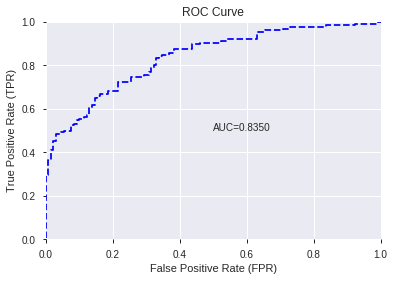

This function is available for GLM models only


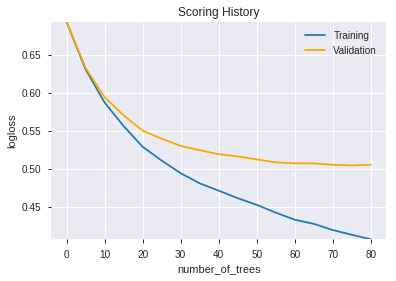

--2019-08-22 16:14:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_161348_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_161348_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CCI_8',
 'WILLR_12',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'PLUS_DI_8',
 'ULTOSC',
 'PLUS_DM_8',
 'STOCHF_fastk',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

168

['BBANDS_upperband_14_4_5',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MA_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_3',
 'BBANDS_middleband_14_5_4',
 'BBANDS_lowerband_14_5_4',
 'MA_14_6',
 'BBANDS_upperband_14_6_2',
 'BBANDS_middleband_14_6_3',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_lowerband_14_6_5',
 'MAVP_14_7',
 'BBANDS_middleband_14_7_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'MIDPRICE_20',
 'SAR_0.2',
 'BBANDS_upperband_20_0_2',
 'BBANDS_upperband_20_0_3',
 'BBANDS_upperband_20_0_4',
 'BBANDS_middleband_20_0_4',
 'MAVP_20_1',
 'BBANDS_upperband_20_2_4',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_middleband_20_2_5',
 'MA_20_3',
 'MAVP_20_3',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_middleband_20_3_5',
 'MA_20_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_upperband_20_5_4',
 'BBANDS_middleband_20_5_4',
 'BB

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_161544_model_8  0.869231  0.487657              0.209158  0.404743  0.163817
1  DeepLearning_grid_1_AutoML_20190822_161544_model_9  0.857265  0.486813              0.195726  0.400242  0.160194
2  DeepLearning_grid_1_AutoML_20190822_161544_model_5  0.857204  0.508439              0.211111  0.413358  0.170865
3  DeepLearning_grid_1_AutoML_20190822_161544_model_2  0.855372  0.502493              0.255433  0.416442  0.173424
4               DeepLearning_1_AutoML_20190822_161544  0.851954  0.522243              0.222039  0.420208  0.176575
5  DeepLearning_grid_1_AutoML_20190822_161544_model_3  0.849512  0.484446              0.259402  0.399107  0.159286
6  DeepLearning_grid_1_AutoML_20190822_161544_model_6  0.849451  0.496182              0.240049  0.408161  0.166596
7  DeepLearning_grid_1_AutoML_20190822_161544_model_7  0.847741  0.498903              0.218803  0.409486  0.167679
8  DeepLearning_grid_1_AutoML_20190822_161544_model_1  0.845604  0.618469              0.237057  0.416335  0.173335
9  DeepLearning_grid_1_AutoML_20190822_161544_model_4  0.839621  0.553676              0.259035  0.417574  0.174368

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.021005
1              CDLRICKSHAWMAN             0.728696           0.728696    0.015306
2                   CDLTAKURI             0.630538           0.630538    0.013244
3            CDLDRAGONFLYDOJI             0.609539           0.609539    0.012803
4                      ULTOSC             0.583945           0.583945    0.012266
..                        ...                  ...                ...         ...
163  BBANDS_middleband_30_1_2             0.206246           0.206246    0.004332
164   BBANDS_upperband_14_5_3             0.205771           0.205771    0.004322
165                   MA_24_2             0.205717           0.205717    0.004321
166  BBANDS_middleband_20_3_5             0.205247           0.205247    0.004311
167  BBANDS_middleband_14_5_4             0.204859           0.204859    0.004303

[168 rows x 4 columns]

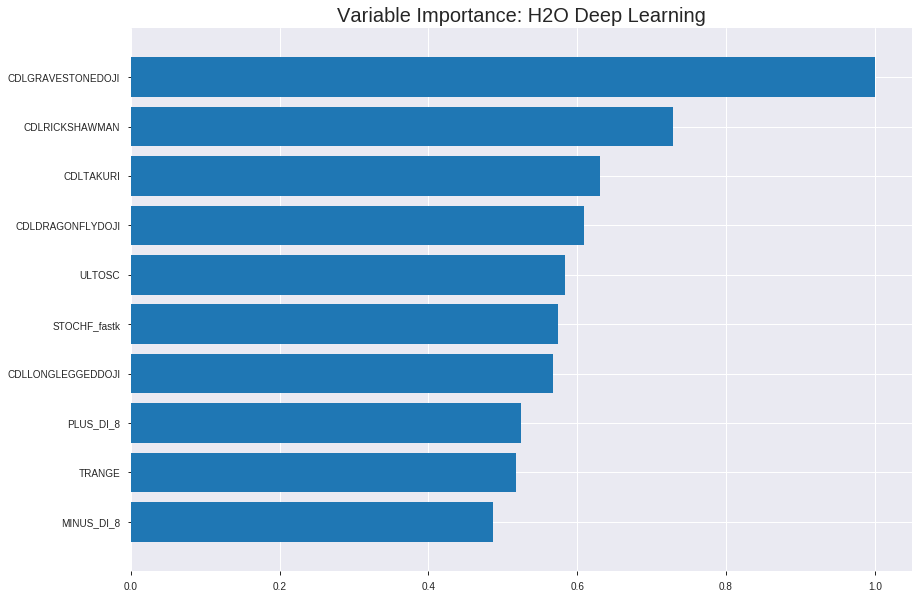

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_161544_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17115266941032964
RMSE: 0.41370601809779084
LogLoss: 0.5021879200966679
Mean Per-Class Error: 0.27573838606327594
AUC: 0.8220577192631157
pr_auc: 0.8303980942625778
Gini: 0.6441154385262313
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4867787205971151: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      448  432   0.4909   (432.0/880.0)
1      74   834   0.0815   (74.0/908.0)
Total  522  1266  0.283    (506.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486779     0.767249  229
max f2                       0.390812     0.87267   268
max f0point5                 0.590604     0.740802  149
max accuracy                 0.50549      0.72651   214
max precision                0.999128     1         0
max recall                   0.0442008    1         381
max specificity              0.999128     1         0
max absolute_mcc             0.486779     0.470179  229
max min_per_class_accuracy   0.532753     0.718182  189
max mean_per_class_accuracy  0.50549      0.724262  214

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 52.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.994334           1.85977    1.85977            0.944444         0.995962   0.944444                    0.995962            0.0187225       0.0187225                  85.9765   85.9765
    2        0.0201342                   0.991209           1.96916    1.91446            1                0.992725   0.972222                    0.994344            0.0198238       0.0385463                  96.9163   91.4464
    3        0.0302013                   0.98782            1.96916    1.9327             1                0.989501   0.981481                    0.992729            0.0198238       0.05837                    96.9163   93.2697
    4        0.0402685                   0.984681           1.96916    1.94181            1                0.986172   0.986111                    0.99109             0.0198238       0.0781938                  96.9163   94.1814
    5        0.0503356                   0.981232           1.85977    1.9254             0.944444         0.982797   0.977778                    0.989431            0.0187225       0.0969163                  85.9765   92.5404
    6        0.100112                    0.945366           1.94704    1.93616            0.988764         0.966348   0.98324                     0.977954            0.0969163       0.193833                   94.7038   93.616
    7        0.150447                    0.834782           1.85977    1.9106             0.944444         0.899586   0.97026                     0.951734            0.0936123       0.287445                   85.9765   91.0601
    8        0.200224                    0.705885           1.54878    1.82065            0.786517         0.764574   0.924581                    0.905205            0.0770925       0.364537                   54.878    82.0651
    9        0.300336                    0.589115           1.33111    1.65747            0.675978         0.637631   0.841713                    0.816014            0.13326         0.497797                   33.111    65.7471
    10       0.399888                    0.540865           1.0399     1.50372            0.52809          0.561703   0.763636                    0.752703            0.103524        0.601322                   3.98951   50.3724
    11       0.507271                    0.532764           1.16919    1.43291            0.59375          0.534624   0.727674                    0.706538            0.125551        0.726872                   16.9191   43.2908
    12       0.600112                    0.516474           0.972719   1.36171            0.493976         0.524922   0.691519                    0.678441            0.0903084       0.817181                   -2.72809  36.1714
    13       0.699664                    0.490316           0.907143   1.29703            0.460674         0.503682   0.658673                    0.653575            0.0903084       0.907489                   -9.28575  29.7035
    14       0.799776                    0.360336           0.638053   1.21455            0.324022         0.441828   0.616783                    0.62707             0.0638767       0.971366                   -36.1947  21.4547
    15       0.899888                    0.100026           0.24202    1.10635            0.122905         0.209905   0.56184                     0.580661            0.0242291       0.995595                   -75.798   10.6354
    16       1                           0.00784093         0.0440036  1                  0.0223464        0.0484084  0.50783   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17295261749374222
RMSE: 0.4158757236167341
LogLoss: 0.5230273180280737
Mean Per-Class Error: 0.2729390845826052
AUC: 0.8164719948496276
pr_auc: 0.8258886918719115
Gini: 0.6329439896992552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.430550568816717: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  127  0.51     (127.0/249.0)
1      20   242  0.0763   (20.0/262.0)
Total  142  369  0.2877   (147.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430551     0.767036  276
max f2                       0.162281     0.866035  332
max f0point5                 0.675595     0.77791   116
max accuracy                 0.52954      0.727984  214
max precision                0.997529     1         0
max recall                   0.0184981    1         395
max specificity              0.997529     1         0
max absolute_mcc             0.675595     0.492027  116
max min_per_class_accuracy   0.535975     0.721374  202
max mean_per_class_accuracy  0.52954      0.727061  214

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 54.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.992875           1.95038   1.95038            1                0.994422   1                           0.994422            0.0229008       0.0229008                  95.0382    95.0382
    2        0.0215264                   0.99082            1.95038   1.95038            1                0.991959   1                           0.993303            0.019084        0.0419847                  95.0382    95.0382
    3        0.0313112                   0.989303           1.95038   1.95038            1                0.989976   1                           0.992263            0.019084        0.0610687                  95.0382    95.0382
    4        0.0410959                   0.986709           1.56031   1.85751            0.8              0.987609   0.952381                    0.991155            0.0152672       0.0763359                  56.0305    85.7506
    5        0.0508806                   0.985753           1.95038   1.87537            1                0.986129   0.961538                    0.990188            0.019084        0.0954198                  95.0382    87.5367
    6        0.101761                    0.973808           1.87537   1.87537            0.961538         0.980633   0.961538                    0.985411            0.0954198       0.19084                    87.5367    87.5367
    7        0.150685                    0.948825           1.71634   1.82373            0.88             0.961989   0.935065                    0.977806            0.0839695       0.274809                   71.6336    82.3734
    8        0.201566                    0.88507            1.72534   1.7989             0.884615         0.917809   0.92233                     0.962661            0.0877863       0.362595                   72.5338    79.8896
    9        0.30137                     0.657113           1.45323   1.68442            0.745098         0.74959    0.863636                    0.892099            0.145038        0.507634                   45.3226    68.4421
    10       0.401174                    0.572695           0.994312  1.51274            0.509804         0.601886   0.77561                     0.819899            0.0992366       0.60687                    -0.568777  51.2735
    11       0.500978                    0.535963           1.10904   1.43231            0.568627         0.549718   0.734375                    0.766074            0.110687        0.717557                   10.9041    43.2312
    12       0.600783                    0.51877            0.841341  1.33414            0.431373         0.527768   0.684039                    0.726486            0.0839695       0.801527                   -15.8659   33.4137
    13       0.700587                    0.464566           1.03256   1.29117            0.529412         0.500695   0.662011                    0.69432             0.103053        0.90458                    3.2555     29.1174
    14       0.800391                    0.276009           0.497156  1.19216            0.254902         0.376377   0.611247                    0.654674            0.0496183       0.954198                   -50.2844   19.2165
    15       0.900196                    0.0834573          0.267699  1.08967            0.137255         0.152379   0.558696                    0.598985            0.0267176       0.980916                   -73.2301   8.96698
    16       1                           0.00647565         0.191214  1                  0.0980392        0.0483778  0.51272   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:23:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:23:24  1 min 29.716 sec  542 obs/sec       0.444631  1             795        0.64591          1.62229             -0.669207      0.542404        0.559349           1.42217          0.490492                         0.637442           1.38036               -0.626383        0.565223          0.596243             1.95038            0.48728
    2019-08-22 16:23:36  1 min 41.801 sec  826 obs/sec       5.70694   13            10204      0.445929         0.574721            0.204394       0.747967        0.761532           1.85977          0.365213                         0.432627           0.553788              0.250849         0.78337           0.791652             1.62532            0.311155
    2019-08-22 16:23:49  1 min 54.424 sec  926 obs/sec       12.3054   28            22002      0.426321         0.533247            0.272824       0.805358        0.818525           1.85977          0.290268                         0.421047           0.531471              0.290418         0.820281          0.822405             1.95038            0.264188
    2019-08-22 16:24:01  2 min  6.939 sec  987 obs/sec       19.3658   44            34626      0.413706         0.502188            0.315221       0.822058        0.830398           1.85977          0.282998                         0.415876           0.523027              0.307741         0.816472          0.825889             1.95038            0.287671
    2019-08-22 16:24:14  2 min 19.508 sec  1037 obs/sec      26.901    61            48099      0.410278         0.494636            0.326522       0.83998         0.841756           1.96916          0.259508                         0.422375           0.53456               0.285936         0.831364          0.838393             1.95038            0.273973
    2019-08-22 16:24:27  2 min 32.466 sec  1073 obs/sec      34.8809   79            62367      0.399048         0.467597            0.362887       0.842116        0.848846           1.96916          0.264541                         0.416353           0.53239               0.306151         0.827386          0.836035             1.95038            0.260274
    2019-08-22 16:24:39  2 min 45.121 sec  1100 obs/sec      42.8272   97            76575      0.397049         0.463165            0.369253       0.853476        0.849699           1.96916          0.242729                         0.421093           0.551555              0.290265         0.824558          0.83325              1.95038            0.262231
    2019-08-22 16:24:41  2 min 46.403 sec  1100 obs/sec      42.8272   97            76575      0.413706         0.502188            0.315221       0.822058        0.830398           1.85977          0.282998                         0.415876           0.523027              0.307741         0.816472          0.825889             1.95038            0.287671

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLGRAVESTONEDOJI         1.0                    1.0                  0.021004879549294673
CDLRICKSHAWMAN            0.7286961674690247     0.7286961674690247   0.015306175225719523
CDLTAKURI                 0.6305384039878845     0.6305384039878845   0.01324438322697002
CDLDRAGONFLYDOJI          0.6095386147499084     0.6095386147499084   0.012803285183465756
ULTOSC                    0.5839449763298035     0.5839449763298035   0.01226569389122325
---                       ---                    ---                  ---
BBANDS_middleband_30_1_2  0.2062457948923111     0.2062457948923111   0.004332168079261529
BBANDS_upperband_14_5_3   0.20577147603034973    0.20577147603034973  0.004322205068698072
MA_24_2                   0.20571699738502502    0.20571699738502502  0.004321060751315018
BBANDS_middleband_20_3_5  0.20524732768535614    0.20524732768535614  0.00431119539584552
BBANDS_middleband_14_5_4  0.20485851168632507    0.20485851168632507  0.004303028362619033


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.796875)

('F1', 0.8085106382978723)

('auc', 0.8692307692307693)

('logloss', 0.4876571689872409)

('mean_per_class_error', 0.20317460317460312)

('rmse', 0.40474342642615563)

('mse', 0.16381724123518485)

deeplearning prediction progress: |███████████████████████████████████████| 100%


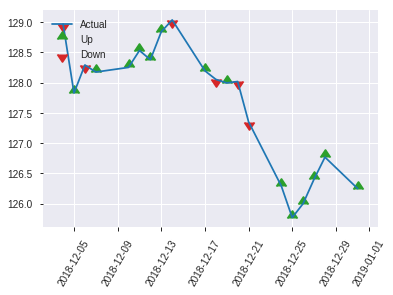


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16381724123518485
RMSE: 0.40474342642615563
LogLoss: 0.4876571689872409
Mean Per-Class Error: 0.20317460317460312
AUC: 0.8692307692307693
pr_auc: 0.8725727005951711
Gini: 0.7384615384615385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5144304033322084: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   42   0.3231   (42.0/130.0)
1      12   114  0.0952   (12.0/126.0)
Total  100  156  0.2109   (54.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51443      0.808511  151
max f2                       0.453421     0.870827  180
max f0point5                 0.579154     0.804878  70
max accuracy                 0.532764     0.796875  115
max precision                0.994089     1         0
max recall                   0.053755     1         248
max specificity              0.994089     1         0
max absolute_mcc             0.51443      0.59605   151
max min_per_class_accuracy   0.532176     0.793651  121
max mean_per_class_accuracy  0.532176     0.796825  121

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 53.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.990683           2.03175   2.03175            1                0.992663   1                           0.992663            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.989507           2.03175   2.03175            1                0.990226   1                           0.991445            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.986364           2.03175   2.03175            1                0.988203   1                           0.990634            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.984877           2.03175   2.03175            1                0.985397   1                           0.989206            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.984303           2.03175   2.03175            1                0.984491   1                           0.988481            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.970223           2.03175   2.03175            1                0.978074   1                           0.983277            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.94946            2.03175   2.03175            1                0.963789   1                           0.976781            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.738411           1.71917   1.9536             0.846154         0.858405   0.961538                    0.947187            0.0873016       0.396825                   71.917    95.3602
    9        0.300781                    0.567334           1.46286   1.79427            0.72             0.620756   0.883117                    0.841203            0.142857        0.539683                   46.2857   79.4269
    10       0.402344                    0.53542            1.32845   1.67668            0.653846         0.546728   0.825243                    0.76687             0.134921        0.674603                   32.8449   67.6684
    11       0.5                         0.531129           1.21905   1.5873             0.6              0.533113   0.78125                     0.721214            0.119048        0.793651                   21.9048   58.7302
    12       0.601562                    0.515034           1.01587   1.49083            0.5              0.524873   0.733766                    0.688066            0.103175        0.896825                   1.5873    49.0827
    13       0.699219                    0.479074           0.325079  1.32801            0.16             0.501667   0.653631                    0.662032            0.031746        0.928571                   -67.4921  32.8013
    14       0.800781                    0.337303           0.39072   1.20914            0.192308         0.405455   0.595122                    0.629491            0.0396825       0.968254                   -60.928   20.9137
    15       0.898438                    0.165547           0         1.07771            0                0.23707    0.530435                    0.586836            0               0.968254                   -100      7.77088
    16       1                           0.0218734          0.312576  1                  0.153846         0.0928725  0.492188                   

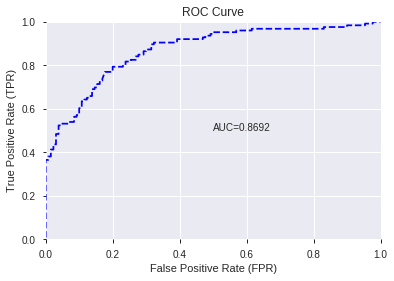

This function is available for GLM models only


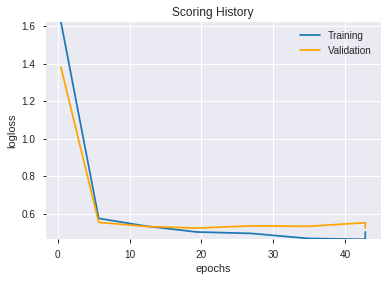

--2019-08-22 16:26:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_161544_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_161544_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLLONGLEGGEDDOJI',
 'PLUS_DI_8',
 'TRANGE',
 'MINUS_DI_8',
 'aroonup_8',
 'CCI_20',
 'HT_TRENDMODE',
 'WILLR_8',
 'PLUS_DI_14',
 'MINUS_DI_12',
 'BETA_12',
 'HT_DCPERIOD',
 'CDLSPINNINGTOP',
 'CDLHIGHWAVE',
 'MINUS_DM_12',
 'CCI_30',
 'BETA_14',
 'PLUS_DM_14',
 'ADXR_12',
 'MINUS_DI_24',
 'aroonup_30',
 'aroondown_12',
 'DX_14',
 'STOCH_slowd',
 'aroondown_8',
 'DX_24',
 'LINEARREG_ANGLE_12',
 'CMO_24',
 'LINEARREG_SLOPE_12',
 'MINUS_DI_20',
 'CDLLONGLINE',
 'CCI_24',
 'ATR_30',
 'CMO_30',
 'CORREL_12',
 'BOP',
 'WILLR_12',
 'WILLR_14',
 'STDDEV_12',
 'aroondown_20',
 'HT_PHASOR_quadrature',
 'NATR_30',
 'ATR_20',
 'CORREL_8',
 'STDDEV_8',
 'DX_20',
 'PLUS_DM_20',
 'VAR_12',
 'LINEARREG_ANGLE_8',
 'ATR_24',
 'RSI_14',
 'CDLSHORTLINE',
 'NATR_12',
 'LINEARREG_SLOPE_8',
 'ATR_8',
 'aroonup_12',
 'PLUS_DM_30',
 'PLUS_DI_20',
 'APO',
 'MACDFIX_signal_12',
 'aroondown_24',
 'ROC_20',
 

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_162641_model_1  0.87094  0.453776               0.19188  0.384959  0.148193

variable  relative_importance  scaled_importance  percentage
0                     SAR_0.2             1.149402           1.000000    0.048433
1                      CCI_20             0.879873           0.765506    0.037075
2                   PLUS_DI_8             0.858173           0.746626    0.036161
3                    MEDPRICE             0.754752           0.656647    0.031803
4                STOCHF_fastk             0.722846           0.628889    0.030459
..                        ...                  ...                ...         ...
163  BBANDS_middleband_14_7_2             0.001850           0.001609    0.000078
164                   MA_20_5             0.001837           0.001599    0.000077
165   BBANDS_upperband_20_0_3             0.001483           0.001291    0.000063
166           MACDFIX_hist_14             0.001194           0.001039    0.000050
167                     DX_24             0.000100           0.000087    0.000004

[168 rows x 4 columns]

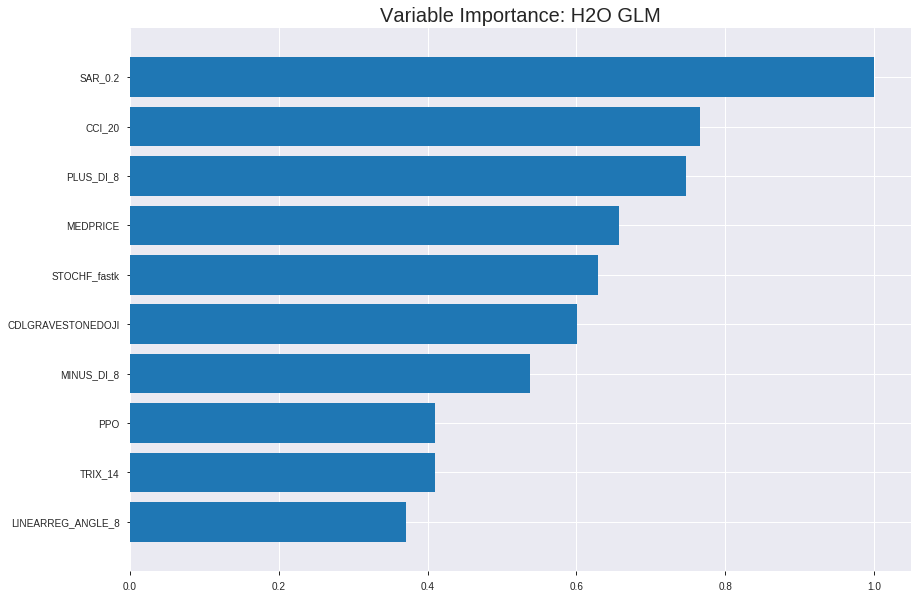

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_162641_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1710883298530739
RMSE: 0.41362825079178756
LogLoss: 0.507937265974299
Null degrees of freedom: 1787
Residual degrees of freedom: 1619
Null deviance: 2478.2558210117336
Residual deviance: 1816.3836631240933
AIC: 2154.3836631240933
AUC: 0.8236815428514217
pr_auc: 0.8281881440731537
Gini: 0.6473630857028434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3389232180398482: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      418  462   0.525    (462.0/880.0)
1      72   836   0.0793   (72.0/908.0)
Total  490  1298  0.2987   (534.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338923     0.757933  281
max f2                       0.161033     0.866149  342
max f0point5                 0.606376     0.759494  154
max accuracy                 0.538823     0.74217   188
max precision                0.997871     1         0
max recall                   0.0369534    1         390
max specificity              0.997871     1         0
max absolute_mcc             0.538823     0.486943  188
max min_per_class_accuracy   0.515443     0.732379  201
max mean_per_class_accuracy  0.538823     0.742816  188

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.984744           1.85977    1.85977            0.944444         0.989976   0.944444                    0.989976            0.0187225       0.0187225                  85.9765   85.9765
    2        0.0201342                   0.97684            1.96916    1.91446            1                0.980886   0.972222                    0.985431            0.0198238       0.0385463                  96.9163   91.4464
    3        0.0302013                   0.971807           1.85977    1.89623            0.944444         0.974327   0.962963                    0.98173             0.0187225       0.0572687                  85.9765   89.6231
    4        0.0402685                   0.966399           1.96916    1.91446            1                0.969239   0.972222                    0.978607            0.0198238       0.0770925                  96.9163   91.4464
    5        0.0503356                   0.960584           1.96916    1.9254             1                0.962697   0.977778                    0.975425            0.0198238       0.0969163                  96.9163   92.5404
    6        0.100112                    0.920718           1.90279    1.91416            0.966292         0.942916   0.972067                    0.959261            0.0947137       0.19163                    90.2787   91.4158
    7        0.150447                    0.834567           1.75037    1.85936            0.888889         0.881395   0.944238                    0.933209            0.0881057       0.279736                   75.0367   85.9358
    8        0.200224                    0.749588           1.54878    1.78215            0.786517         0.790574   0.905028                    0.89775             0.0770925       0.356828                   54.878    78.2148
    9        0.300336                    0.648397           1.43012    1.6648             0.726257         0.693402   0.845438                    0.829634            0.143172        0.5                        43.0118   66.4804
    10       0.399888                    0.578227           1.26115    1.56431            0.640449         0.613259   0.794406                    0.775767            0.125551        0.625551                   26.1149   56.4314
    11       0.5                         0.515316           1.05609    1.46256            0.536313         0.545797   0.742729                    0.729722            0.105727        0.731278                   5.60874   46.2555
    12       0.600112                    0.449008           0.858071   1.36171            0.435754         0.484005   0.691519                    0.688731            0.0859031       0.817181                   -14.1929  36.1714
    13       0.699664                    0.363672           0.829704   1.28602            0.421348         0.407348   0.653078                    0.648694            0.0825991       0.89978                    -17.0296  28.6016
    14       0.799776                    0.24397            0.561046   1.19527            0.284916         0.307237   0.606993                    0.605952            0.0561674       0.955947                   -43.8954  19.5268
    15       0.899888                    0.104995           0.341028   1.10023            0.173184         0.168291   0.558732                    0.557263            0.034141        0.990088                   -65.8972  10.0235
    16       1                           0.004079           0.0990082  1                  0.0502793        0.0634895  0.50783  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1656742833517938
RMSE: 0.4070310594436176
LogLoss: 0.5034161108704496
Null degrees of freedom: 510
Residual degrees of freedom: 342
Null deviance: 708.1145564513349
Residual deviance: 514.4912653095995
AIC: 852.4912653095995
AUC: 0.8339158159354977
pr_auc: 0.8392421587327384
Gini: 0.6678316318709954
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36163608654758417: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  109  0.4378   (109.0/249.0)
1      24   238  0.0916   (24.0/262.0)
Total  164  347  0.2603   (133.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361636     0.781609  266
max f2                       0.253049     0.868201  300
max f0point5                 0.677294     0.775281  115
max accuracy                 0.469126     0.759295  211
max precision                0.993727     1         0
max recall                   0.023199     1         395
max specificity              0.993727     1         0
max absolute_mcc             0.469126     0.518456  211
max min_per_class_accuracy   0.497475     0.746988  199
max mean_per_class_accuracy  0.469126     0.758392  211

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 50.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.981095           1.95038   1.95038            1                0.987146   1                           0.987146            0.0229008       0.0229008                  95.0382    95.0382
    2        0.0215264                   0.972493           1.95038   1.95038            1                0.978048   1                           0.98301             0.019084        0.0419847                  95.0382    95.0382
    3        0.0313112                   0.970276           1.95038   1.95038            1                0.971363   1                           0.97937             0.019084        0.0610687                  95.0382    95.0382
    4        0.0410959                   0.967925           1.95038   1.95038            1                0.969126   1                           0.976931            0.019084        0.0801527                  95.0382    95.0382
    5        0.0508806                   0.964708           1.56031   1.87537            0.8              0.966439   0.961538                    0.974913            0.0152672       0.0954198                  56.0305    87.5367
    6        0.101761                    0.930125           1.80035   1.83786            0.923077         0.943298   0.942308                    0.959106            0.0916031       0.187023                   80.0352    83.786
    7        0.150685                    0.879784           1.79435   1.82373            0.92             0.897217   0.935065                    0.939012            0.0877863       0.274809                   79.4351    82.3734
    8        0.201566                    0.798418           1.80035   1.81783            0.923077         0.833929   0.932039                    0.912486            0.0916031       0.366412                   80.0352    81.7831
    9        0.30137                     0.68375            1.52971   1.72241            0.784314         0.735103   0.883117                    0.853742            0.152672        0.519084                   52.9711    72.2415
    10       0.401174                    0.586077           0.994312  1.54128            0.509804         0.631654   0.790244                    0.798491            0.0992366       0.618321                   -0.568777  54.1277
    11       0.500978                    0.503549           1.22377   1.47802            0.627451         0.54472    0.757812                    0.747935            0.122137        0.740458                   22.3769    47.8024
    12       0.600783                    0.434604           0.917827  1.38496            0.470588         0.464739   0.710098                    0.700889            0.0916031       0.832061                   -8.21733   38.4962
    13       0.700587                    0.340229           0.841341  1.30752            0.431373         0.388686   0.670391                    0.656414            0.0839695       0.916031                   -15.8659   30.7518
    14       0.800391                    0.205788           0.420671  1.19693            0.215686         0.265959   0.613692                    0.607726            0.0419847       0.958015                   -57.9329   19.6934
    15       0.900196                    0.0946087          0.229457  1.08967            0.117647         0.138616   0.558696                    0.555716            0.0229008       0.980916                   -77.0543   8.96698
    16       1                           0.00486166         0.191214  1                  0.0980392        0.0570465  0.51272    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:26:41  0.000 sec   2            .17E2     168           1.3701534657872243  1.3690226191677566
     2019-08-22 16:26:42  0.085 sec   4            .12E2     169           1.3647691554817232  1.3632023612943978
     2019-08-22 16:26:42  0.167 sec   6            .9E1      169           1.3577262734861328  1.355530252240955
     2019-08-22 16:26:42  0.253 sec   8            .66E1     169           1.3486832347269393  1.3455927491240258
     2019-08-22 16:26:42  0.338 sec   10           .48E1     169           1.3372334308813654  1.3329185312422736
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:26:44  2.325 sec   52           .61E-2    169           1.0317451474631285  1.0172935668466663
     2019-08-22 16:26:44  2.428 sec   54           .44E-2    169           1.0275741091096697  1.0147232248289353
     2019-08-22 16:26:44  2.533 sec   56           .32E-2    169           1.0235546602221088  1.0121348787545144
     2019-08-22 16:26:44  2.635 sec   58           .23E-2    169           1.0196804112162912  1.0095390605009475
     2019-08-22 16:26:44  2.744 sec   60           .17E-2    169           1.015874531948598   1.0068322217408991


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.80859375)

('F1', 0.7999999999999999)

('auc', 0.870940170940171)

('logloss', 0.45377566441763184)

('mean_per_class_error', 0.19188034188034186)

('rmse', 0.3849589170288821)

('mse', 0.1481933678000497)

glm prediction progress: |████████████████████████████████████████████████| 100%


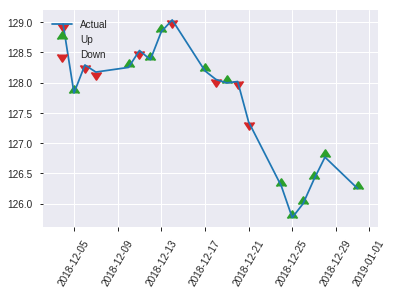


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1481933678000497
RMSE: 0.3849589170288821
LogLoss: 0.45377566441763184
Null degrees of freedom: 255
Residual degrees of freedom: 87
Null deviance: 355.07943398521934
Residual deviance: 232.33314018182756
AIC: 570.3331401818275
AUC: 0.870940170940171
pr_auc: 0.8784445154380306
Gini: 0.7418803418803419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.523681513247562: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      109  21   0.1615   (21.0/130.0)
1      28   98   0.2222   (28.0/126.0)
Total  137  119  0.1914   (49.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523682     0.8       118
max f2                       0.268073     0.869253  191
max f0point5                 0.641115     0.833333  80
max accuracy                 0.523682     0.808594  118
max precision                0.990771     1         0
max recall                   0.0630409    1         245
max specificity              0.990771     1         0
max absolute_mcc             0.523682     0.617693  118
max min_per_class_accuracy   0.510234     0.793651  124
max mean_per_class_accuracy  0.523682     0.80812   118

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.979746           2.03175    2.03175            1                0.986653   1                           0.986653            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.9772             2.03175    2.03175            1                0.978161   1                           0.982407            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.973118           2.03175    2.03175            1                0.975572   1                           0.980698            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.966977           2.03175    2.03175            1                0.970293   1                           0.97786             0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.963872           2.03175    2.03175            1                0.965667   1                           0.975985            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.939873           2.03175    2.03175            1                0.949051   1                           0.962518            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.904827           2.03175    2.03175            1                0.925111   1                           0.950049            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.808776           1.87546    1.99267            0.923077         0.860533   0.980769                    0.92767             0.0952381       0.404762                   87.5458   99.2674
    9        0.300781                    0.651526           1.6254     1.87343            0.8              0.713778   0.922078                    0.858224            0.15873         0.563492                   62.5397   87.3428
    10       0.402344                    0.572281           1.25031    1.71613            0.615385         0.610867   0.84466                     0.795785            0.126984        0.690476                   25.0305   71.6135
    11       0.5                         0.492982           1.05651    1.5873             0.52             0.531002   0.78125                     0.744069            0.103175        0.793651                   5.65079   58.7302
    12       0.601562                    0.419697           0.625153   1.42486            0.307692         0.456062   0.701299                    0.695445            0.0634921       0.857143                   -37.4847  42.4861
    13       0.699219                    0.317836           0.731429   1.32801            0.36             0.365719   0.653631                    0.649394            0.0714286       0.928571                   -26.8571  32.8013
    14       0.800781                    0.219494           0.39072    1.20914            0.192308         0.267464   0.595122                    0.600954            0.0396825       0.968254                   -60.928   20.9137
    15       0.898438                    0.118381           0.0812698  1.08654            0.04             0.161207   0.534783                    0.553155            0.00793651      0.97619                    -91.873   8.65424
    16       1                           0.0282137          0.234432   1                  0.115385         0.0653078  0.492188 

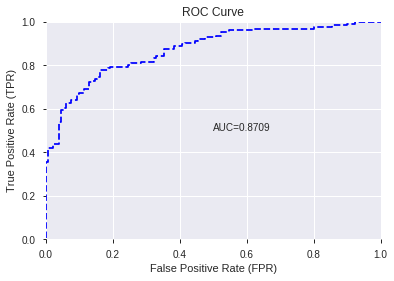

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


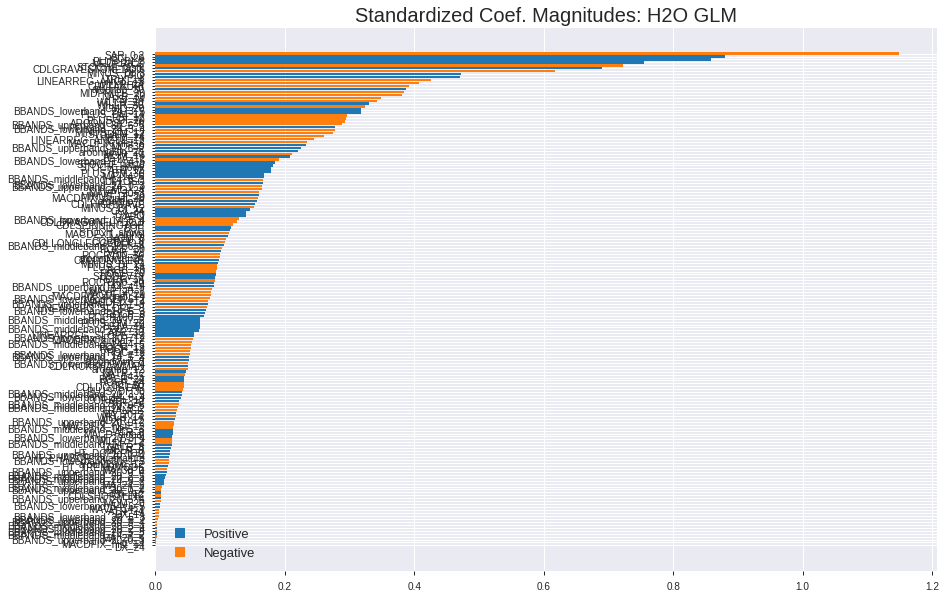

'log_likelihood'
--2019-08-22 16:26:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_162641_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_162641_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['SAR_0.2',
 'CCI_20',
 'PLUS_DI_8',
 'MEDPRICE',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'PPO',
 'TRIX_14',
 'LINEARREG_ANGLE_8',
 'WILLR_24',
 'CDLTAKURI',
 'aroonup_30',
 'MIDPRICE_20',
 'NATR_30',
 'RSI_14',
 'WILLR_20',
 'WILLR_30',
 'CMO_20',
 'BBANDS_lowerband_24_3_5',
 'PLUS_DM_14',
 'RSI_12',
 'PLUS_DI_20',
 'AROONOSC_30',
 'BBANDS_upperband_30_6_5',
 'BBANDS_lowerband_24_3_4',
 'MINUS_DM_12',
 'STDDEV_12',
 'MOM_24',
 'LINEARREG_ANGLE_12',
 'MACDFIX_hist_8',
 'CMO_30',
 'BBANDS_upperband_14_6_2',
 'aroondown_20',
 'MOM_14',
 'BETA_12',
 'BBANDS_lowerband_14_4_5',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ATR_12',
 'PLUS_DM_30',
 'MA_14_6',
 'BBANDS_middleband_14_6_3',
 'ULTOSC',
 'BBANDS_lowerband_24_0_3',
 'BBANDS_upperband_24_1_4',
 'CMO_24',
 'MAVP_20_3',
 'MINUS_DI_20',
 'MACDFIX_signal_20',
 'aroonup_8',
 'CDLHIGHWAVE',
 'MINUS_DI_12',
 'CCI_24',
 'DX_20',
 'APO',
 'BBANDS_lowerband_14_5_4',
 'CDLDRAGONFLYDOJI',
 'CDLSPINNINGTOP',
 'BOP',
 'STOCH_slowd',
 'MACDEX

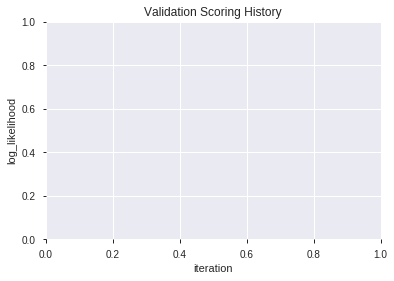

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_162658_model_2  0.862393  0.476314              0.228388  0.395852  0.156699
1               XGBoost_2_AutoML_20190822_162658  0.857143  0.475470              0.236325  0.395400  0.156342
2               XGBoost_3_AutoML_20190822_162658  0.856899  0.478453              0.232601  0.398683  0.158948
3  XGBoost_grid_1_AutoML_20190822_162658_model_4  0.855311  0.485778              0.247375  0.400189  0.160151
4  XGBoost_grid_1_AutoML_20190822_162658_model_3  0.854762  0.474461              0.225275  0.397461  0.157975
5               XGBoost_1_AutoML_20190822_162658  0.853053  0.484446              0.251954  0.401623  0.161301
6  XGBoost_grid_1_AutoML_20190822_162658_model_1  0.851587  0.477710              0.243651  0.398085  0.158472
7  XGBoost_grid_1_AutoML_20190822_162658_model_6  0.851526  0.485578              0.236203  0.402519  0.162022
8  XGBoost_grid_1_AutoML_20190822_162658_model_5  0.849512  0.488816              0.225397  0.402500  0.162006
9  XGBoost_grid_1_AutoML_20190822_162658_model_7  0.846886  0.481565              0.233455  0.399939  0.159951

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI          1494.866821           1.000000    0.138325
1                   CDLTAKURI          1479.764160           0.989897    0.136928
2                STOCHF_fastk           548.420288           0.366869    0.050747
3                     WILLR_8           398.564484           0.266622    0.036881
4                 aroondown_8           368.322876           0.246392    0.034082
..                        ...                  ...                ...         ...
139                  MEDPRICE             2.146948           0.001436    0.000199
140   BBANDS_lowerband_14_7_2             1.515360           0.001014    0.000140
141                   ROCR_14             0.752866           0.000504    0.000070
142               MIDPRICE_20             0.523210           0.000350    0.000048
143  BBANDS_middleband_20_0_4             0.184788           0.000124    0.000017

[144 rows x 4 columns]

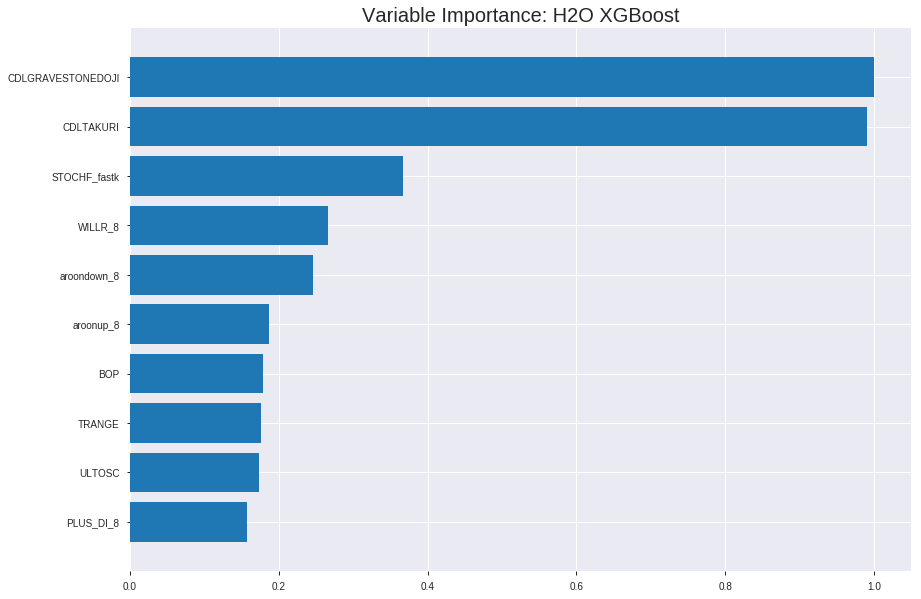

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_162658_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13016153264816122
RMSE: 0.36077906348368
LogLoss: 0.41817888757508015
Mean Per-Class Error: 0.13665648778534245
AUC: 0.9368191830196235
pr_auc: 0.9370853666699834
Gini: 0.873638366039247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49626412987709045: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      749  131  0.1489   (131.0/880.0)
1      113  795  0.1244   (113.0/908.0)
Total  862  926  0.1365   (244.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496264     0.866957  201
max f2                       0.400143     0.909561  255
max f0point5                 0.54266      0.882927  175
max accuracy                 0.496264     0.863535  201
max precision                0.955113     1         0
max recall                   0.113984     1         364
max specificity              0.955113     1         0
max absolute_mcc             0.496264     0.727064  201
max min_per_class_accuracy   0.501048     0.859091  198
max mean_per_class_accuracy  0.496264     0.863344  201

Gains/Lift Table: Avg response rate: 50.78 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.946627           1.96916    1.96916            1                0.951708   1                           0.951708            0.0198238       0.0198238                  96.9163   96.9163
    2        0.0201342                   0.938397           1.96916    1.96916            1                0.942701   1                           0.947205            0.0198238       0.0396476                  96.9163   96.9163
    3        0.0302013                   0.93328            1.96916    1.96916            1                0.935778   1                           0.943396            0.0198238       0.0594714                  96.9163   96.9163
    4        0.0402685                   0.929853           1.96916    1.96916            1                0.931481   1                           0.940417            0.0198238       0.0792952                  96.9163   96.9163
    5        0.0503356                   0.924541           1.96916    1.96916            1                0.927661   1                           0.937866            0.0198238       0.0991189                  96.9163   96.9163
    6        0.100112                    0.887151           1.96916    1.96916            1                0.908611   1                           0.92332             0.0980176       0.197137                   96.9163   96.9163
    7        0.150447                    0.798812           1.94728    1.96184            0.988889         0.840725   0.996283                    0.895686            0.0980176       0.295154                   94.7283   96.1843
    8        0.200224                    0.724893           1.94704    1.95816            0.988764         0.757988   0.994413                    0.861454            0.0969163       0.39207                    94.7038   95.8162
    9        0.300336                    0.635287           1.78215    1.89949            0.905028         0.680048   0.964618                    0.800985            0.178414        0.570485                   78.2148   89.9491
    10       0.399888                    0.573127           1.61516    1.82871            0.820225         0.602672   0.928671                    0.751615            0.160793        0.731278                   61.5156   82.8705
    11       0.5                         0.504005           1.2101     1.70485            0.614525         0.539464   0.865772                    0.709137            0.121145        0.852423                   21.01     70.4846
    12       0.600112                    0.446559           0.792066   1.55257            0.402235         0.475261   0.788444                    0.670122            0.0792952       0.931718                   -20.7934  55.2574
    13       0.699664                    0.378587           0.420383   1.39148            0.213483         0.414038   0.706635                    0.633684            0.0418502       0.973568                   -57.9617  39.1479
    14       0.799776                    0.283506           0.0990082  1.22969            0.0502793        0.340531   0.624476                    0.596989            0.00991189      0.98348                    -90.0992  22.9694
    15       0.899888                    0.119036           0.154013   1.11003            0.0782123        0.191355   0.563704                    0.551862            0.0154185       0.998899                   -84.5987  11.0025
    16       1                           0.047049           0.0110009  1                  0.00558659       0.0892227  0.50783  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16908723573293555
RMSE: 0.4112021835216048
LogLoss: 0.5071567008286152
Mean Per-Class Error: 0.23770655139642538
AUC: 0.8385680125080475
pr_auc: 0.8492600905106276
Gini: 0.6771360250160949
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4905458092689514: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  96   0.3855   (96.0/249.0)
1      36   226  0.1374   (36.0/262.0)
Total  189  322  0.2583   (132.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490546     0.773973  240
max f2                       0.234582     0.864993  326
max f0point5                 0.672322     0.799574  129
max accuracy                 0.5708       0.761252  182
max precision                0.955767     1         0
max recall                   0.0754424    1         394
max specificity              0.955767     1         0
max absolute_mcc             0.652053     0.528657  137
max min_per_class_accuracy   0.552654     0.751004  195
max mean_per_class_accuracy  0.5708       0.762293  182

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 54.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.948497           1.95038   1.95038            1                0.952117  1                           0.952117            0.0229008       0.0229008                  95.0382    95.0382
    2        0.0215264                   0.939794           1.95038   1.95038            1                0.943345  1                           0.94813             0.019084        0.0419847                  95.0382    95.0382
    3        0.0313112                   0.932319           1.95038   1.95038            1                0.934578  1                           0.943895            0.019084        0.0610687                  95.0382    95.0382
    4        0.0410959                   0.928485           1.95038   1.95038            1                0.93065   1                           0.940741            0.019084        0.0801527                  95.0382    95.0382
    5        0.0508806                   0.925968           1.95038   1.95038            1                0.927065  1                           0.938111            0.019084        0.0992366                  95.0382    95.0382
    6        0.101761                    0.90172            1.80035   1.87537            0.923077         0.916835  0.961538                    0.927473            0.0916031       0.19084                    80.0352    87.5367
    7        0.150685                    0.845591           1.63832   1.7984             0.84             0.879278  0.922078                    0.911825            0.0801527       0.270992                   63.8321    79.8404
    8        0.201566                    0.793871           1.95038   1.83677            1                0.815879  0.941748                    0.887606            0.0992366       0.370229                   95.0382    83.6767
    9        0.30137                     0.700095           1.45323   1.70975            0.745098         0.742761  0.876623                    0.839638            0.145038        0.515267                   45.3226    70.975
    10       0.401174                    0.610048           1.30025   1.60788            0.666667         0.650599  0.82439                     0.792609            0.129771        0.645038                   30.0254    60.7876
    11       0.500978                    0.554997           0.994312  1.48564            0.509804         0.58298   0.761719                    0.750847            0.0992366       0.744275                   -0.568777  48.5642
    12       0.600783                    0.503993           0.879584  1.38496            0.45098          0.531479  0.710098                    0.714405            0.0877863       0.832061                   -12.0416   38.4962
    13       0.700587                    0.444193           0.726613  1.29117            0.372549         0.477008  0.662011                    0.680585            0.0725191       0.90458                    -27.3387   29.1174
    14       0.800391                    0.29892            0.382428  1.17786            0.196078         0.382494  0.603912                    0.643415            0.0381679       0.942748                   -61.7572   17.7859
    15       0.900196                    0.131702           0.458913  1.09815            0.235294         0.20223   0.563043                    0.594501            0.0458015       0.98855                    -54.1087   9.81497
    16       1                           0.0604951          0.114728  1                  0.0588235        0.098836  0.51272                     0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:27:08  1.865 sec   0                  0.5              0.693147            0.5             0                  1                0.49217                          0.5                0.693147              0.5               0                    1                  0.48728
    2019-08-22 16:27:09  2.123 sec   5                  0.475213         0.644461            0.838491        0.719847           1.96916          0.261186                         0.474631           0.643346              0.828719          0.68513              1.82318            0.273973
    2019-08-22 16:27:09  2.240 sec   10                 0.456432         0.607957            0.843107        0.807263           1.96916          0.26566                          0.456177           0.607488              0.833793          0.777115             1.84773            0.260274
    2019-08-22 16:27:09  2.323 sec   15                 0.442941         0.581207            0.853579        0.818147           1.96916          0.242729                         0.443782           0.582778              0.836844          0.785315             1.83565            0.262231
    2019-08-22 16:27:09  2.409 sec   20                 0.432299         0.559478            0.85921         0.830555           1.96916          0.23434                          0.435556           0.565541              0.838016          0.807747             1.95038            0.234834
    2019-08-22 16:27:09  2.507 sec   25                 0.424631         0.543044            0.867909        0.837544           1.96916          0.22651                          0.431036           0.554813              0.8381            0.808826             1.95038            0.240705
    2019-08-22 16:27:09  2.599 sec   30                 0.417482         0.527667            0.871713        0.844453           1.96916          0.220917                         0.425188           0.542027              0.840936          0.810856             1.95038            0.242661
    2019-08-22 16:27:09  2.699 sec   35                 0.412391         0.516135            0.876465        0.852151           1.96916          0.209732                         0.423304           0.53643               0.837242          0.807945             1.95038            0.27593
    2019-08-22 16:27:09  2.795 sec   40                 0.406633         0.50437             0.881948        0.88833            1.96916          0.201342                         0.42057            0.530294              0.837871          0.840763             1.95038            0.252446
    2019-08-22 16:27:09  2.896 sec   45                 0.401058         0.493032            0.888243        0.894073           1.96916          0.189038                         0.418174           0.524837              0.839702          0.843521             1.95038            0.258317
    2019-08-22 16:27:10  2.996 sec   50                 0.396376         0.483381            0.895648        0.898364           1.96916          0.183445                         0.41631            0.520415              0.840936          0.844515             1.95038            0.232877
    2019-08-22 16:27:10  3.102 sec   55                 0.391116         0.473199            0.902101        0.905985           1.96916          0.176174                         0.414405           0.516183              0.840262          0.8

Variable Importances: 


variable                  relative_importance    scaled_importance       percentage
------------------------  ---------------------  ----------------------  ----------------------
CDLGRAVESTONEDOJI         1494.8668212890625     1.0                     0.13832525919157268
CDLTAKURI                 1479.76416015625       0.9898969855255807      0.13692775709578242
STOCHF_fastk              548.4202880859375      0.36686899479983137     0.050747248795038405
WILLR_8                   398.5644836425781      0.2666220682447722      0.0368805666961513
aroondown_8               368.3228759765625      0.24639176596276857     0.03408220488946928
---                       ---                    ---                     ---
MEDPRICE                  2.1469478607177734     0.0014362134674086916   0.0001986646001337346
BBANDS_lowerband_14_7_2   1.5153601169586182     0.0010137091113253045   0.00014022157556893154
ROCR_14                   0.7528656125068665     0.0005036339035591484   6.966529024748272e-05
MIDPRICE_20               0.5232100486755371     0.00035000445606543027  4.841445710345606e-05
BBANDS_middleband_20_0_4  0.1847883015871048     0.00012361522709277675  1.7099108327633464e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.794425087108014)

('auc', 0.8623931623931624)

('logloss', 0.4763140164025072)

('mean_per_class_error', 0.22002442002442002)

('rmse', 0.39585223289532256)

('mse', 0.1566989902882127)

xgboost prediction progress: |████████████████████████████████████████████| 100%


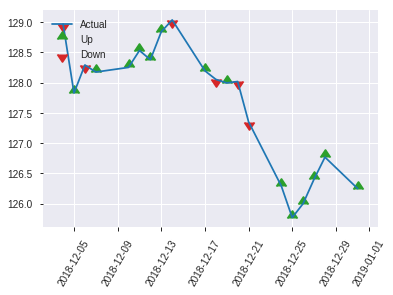


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1566989902882127
RMSE: 0.39585223289532256
LogLoss: 0.4763140164025072
Mean Per-Class Error: 0.22002442002442002
AUC: 0.8623931623931624
pr_auc: 0.8702138872689529
Gini: 0.7247863247863249
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46910208463668823: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      83   47   0.3615   (47.0/130.0)
1      12   114  0.0952   (12.0/126.0)
Total  95   161  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469102     0.794425  160
max f2                       0.313199     0.860832  192
max f0point5                 0.656511     0.801435  72
max accuracy                 0.586232     0.78125   105
max precision                0.956631     1         0
max recall                   0.0950014    1         243
max specificity              0.956631     1         0
max absolute_mcc             0.586232     0.56834   105
max min_per_class_accuracy   0.544415     0.761905  125
max mean_per_class_accuracy  0.586232     0.779976  105

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.952287           2.03175    2.03175            1                0.954317   1                           0.954317            0.0238095       0.0238095                  103.175   103.175
    2        0.0234375                   0.950205           2.03175    2.03175            1                0.951427   1                           0.952872            0.0238095       0.047619                   103.175   103.175
    3        0.03125                     0.94479            2.03175    2.03175            1                0.946601   1                           0.951304            0.015873        0.0634921                  103.175   103.175
    4        0.0429688                   0.939713           2.03175    2.03175            1                0.942584   1                           0.948926            0.0238095       0.0873016                  103.175   103.175
    5        0.0507812                   0.937447           2.03175    2.03175            1                0.938502   1                           0.947322            0.015873        0.103175                   103.175   103.175
    6        0.101562                    0.919232           2.03175    2.03175            1                0.929756   1                           0.938539            0.103175        0.206349                   103.175   103.175
    7        0.152344                    0.882335           2.03175    2.03175            1                0.900658   1                           0.925912            0.103175        0.309524                   103.175   103.175
    8        0.203125                    0.773755           2.03175    2.03175            1                0.824377   1                           0.900528            0.103175        0.412698                   103.175   103.175
    9        0.300781                    0.648116           1.30032    1.79427            0.64             0.702003   0.883117                    0.836072            0.126984        0.539683                   30.0317   79.4269
    10       0.402344                    0.591529           1.32845    1.67668            0.653846         0.620624   0.825243                    0.781687            0.134921        0.674603                   32.8449   67.6684
    11       0.5                         0.541512           0.975238   1.53968            0.48             0.565204   0.757812                    0.739405            0.0952381       0.769841                   -2.47619  53.9683
    12       0.601562                    0.498204           1.01587    1.45125            0.5              0.521066   0.714286                    0.702543            0.103175        0.873016                   1.5873    45.1247
    13       0.699219                    0.418478           0.568889   1.32801            0.28             0.45444    0.653631                    0.667892            0.0555556       0.928571                   -43.1111  32.8013
    14       0.800781                    0.250431           0.312576   1.19923            0.153846         0.328503   0.590244                    0.624847            0.031746        0.960317                   -68.7424  19.9226
    15       0.898438                    0.129556           0.0812698  1.07771            0.04             0.20271    0.530435                    0.578963            0.00793651      0.968254                   -91.873   7.77088
    16       1                           0.0702685          0.312576   1                  0.153846         0.0958728  0.492188 

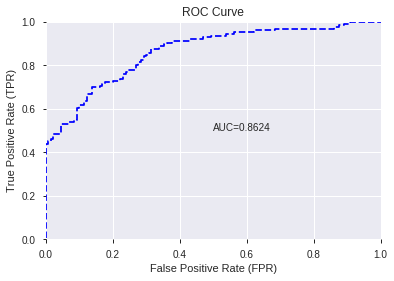

This function is available for GLM models only


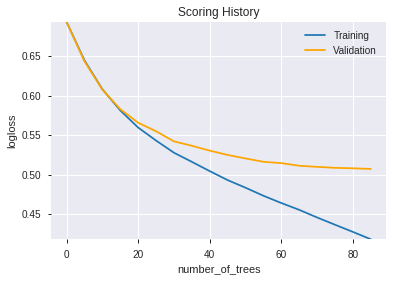

--2019-08-22 16:27:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_162658_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_162658_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_98dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'WILLR_8',
 'aroondown_8',
 'aroonup_8',
 'BOP',
 'TRANGE',
 'ULTOSC',
 'PLUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'HT_DCPERIOD',
 'ATR_30',
 'WILLR_12',
 'BETA_12',
 'ATR_8',
 'HT_PHASOR_quadrature',
 'MINUS_DI_8',
 'WILLR_24',
 'CDLSHORTLINE',
 'NATR_30',
 'PLUS_DI_14',
 'MINUS_DI_12',
 'BETA_14',
 'ADXR_12',
 'RSI_12',
 'CCI_20',
 'LINEARREG_ANGLE_12',
 'MINUS_DM_12',
 'CDLRICKSHAWMAN',
 'MOM_20',
 'aroondown_12',
 'STDDEV_8',
 'WILLR_30',
 'CORREL_8',
 'ATR_20',
 'DX_14',
 'STOCH_slowk',
 'BBANDS_upperband_30_6_5',
 'MACDFIX_signal_20',
 'WILLR_14',
 'AROONOSC_30',
 'APO',
 'PLUS_DI_30',
 'BBANDS_upperband_30_0_4',
 'PLUS_DM_14',
 'BBANDS_upperband_14_4_5',
 'CORREL_12',
 'MACDEXT_signal',
 'MACDFIX_signal_14',
 'PLUS_DM_30',
 'WILLR_20',
 'MACDFIX_14',
 'MINUS_DI_20',
 'NATR_8',
 'MACDFIX_signal_12',
 'DX_24',
 'aroonup_12',
 'RSI_14',
 'aroonup_30',
 'CMO_30',
 'LINEARREG_ANGLE_8',
 'CCI_30',
 'BBANDS_middleband_30_1_2',
 'CDLLONGLINE

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.797
GLM             0.809
XGBoost         0.801
dtype: float64

DeepLearning    GLM  XGBoost
All          0.777  0.789    0.801
DLF          0.766  0.758    0.777
Fwe          0.785  0.766    0.754
RFE          0.797  0.809    0.781
XGBF         0.762  0.758    0.773





F1


DeepLearning    0.809
GLM             0.800
XGBoost         0.799
dtype: float64

DeepLearning    GLM  XGBoost
All          0.778  0.796    0.790
DLF          0.765  0.764    0.799
Fwe          0.779  0.779    0.770
RFE          0.809  0.800    0.794
XGBF         0.766  0.764    0.792





auc


DeepLearning    0.869
GLM             0.871
XGBoost         0.862
dtype: float64

DeepLearning    GLM  XGBoost
All          0.860  0.861    0.861
DLF          0.838  0.841    0.853
Fwe          0.855  0.843    0.835
RFE          0.869  0.871    0.862
XGBF         0.841  0.841    0.856





logloss


DeepLearning    0.505
GLM             0.488
XGBoost         0.494
dtype: float64

DeepLearning    GLM  XGBoost
All          0.479  0.486    0.479
DLF          0.505  0.488    0.477
Fwe          0.500  0.482    0.494
RFE          0.488  0.454    0.476
XGBF         0.500  0.488    0.476





mean_per_class_error


DeepLearning    0.238
GLM             0.242
XGBoost         0.247
dtype: float64

DeepLearning    GLM  XGBoost
All          0.223  0.210    0.200
DLF          0.236  0.242    0.221
Fwe          0.215  0.233    0.247
RFE          0.203  0.192    0.220
XGBF         0.238  0.242    0.226





rmse


DeepLearning    0.411
GLM             0.404
XGBoost         0.406
dtype: float64

DeepLearning    GLM  XGBoost
All          0.394  0.390    0.398
DLF          0.410  0.404    0.397
Fwe          0.411  0.402    0.406
RFE          0.405  0.385    0.396
XGBF         0.410  0.404    0.396





mse


DeepLearning    0.169
GLM             0.164
XGBoost         0.165
dtype: float64

DeepLearning    GLM  XGBoost
All          0.155  0.152    0.159
DLF          0.168  0.164    0.157
Fwe          0.169  0.161    0.165
RFE          0.164  0.148    0.157
XGBF         0.168  0.164    0.157

{'F1':       DeepLearning    GLM  XGBoost
 All          0.778    NaN      NaN
 DLF          0.765    NaN      NaN
 DLF            NaN  0.764      NaN
 DLF            NaN    NaN    0.799
 All            NaN  0.796      NaN
 All            NaN    NaN    0.790
 XGBF         0.766    NaN      NaN
 XGBF           NaN  0.764      NaN
 XGBF           NaN    NaN    0.792
 Fwe          0.779    NaN      NaN
 Fwe            NaN  0.779      NaN
 Fwe            NaN    NaN    0.770
 RFE          0.809    NaN      NaN
 RFE            NaN  0.800      NaN
 RFE            NaN    NaN    0.794,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.777    NaN      NaN
 DLF          0.766    NaN      NaN
 DLF            NaN  0.758      NaN
 DLF            NaN    NaN    0.777
 All            NaN  0.789      NaN
 All            NaN    NaN    0.801
 XGBF         0.762    NaN      NaN
 XGBF           NaN  0.758      NaN
 XGBF           NaN    NaN    0.773
 Fwe          0.785    NaN      NaN
 Fwe     